# Conditional GAN (C-GAN)

Originally proposed by [Mirza et al.](https://arxiv.org/pdf/1411.1784.pdf) is their work titled Conditional Generative Adversarial Nets. This network uses a basic implementation where generator and discriminator models are MLPs with additional inputs for conditioning with class labels.
This notebook trains both networks using ADAM optimizer to play the minimax game. We showcase the effectiveness using MNIST digit generation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PacktPublishing/Hands-On-Generative-AI-with-Python-and-TensorFlow-2/blob/master/Chapter_6/conditional_gan.ipynb)

## Load Libraries

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import datasets
import numpy as np

## Load Utility Functions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys

# Add the directory to the Python path
sys.path.append('/content/drive/MyDrive/')

from gan_utils import build_conditional_discriminator
from gan_utils import build_conditional_generator
from gan_utils import sample_images

## Conditional GAN Training Loop
- As proposed in the original paper
- Randomly sample class labels as additional input for both discriminator and generator models
- Calculate Discriminator loss
- Fix the discriminator and calculate GAN/generator loss

_Note : This is same as Vanilla GAN training_

In [ ]:
def train(generator=None,discriminator=None,gan_model=None,
          epochs=1000, batch_size=128, sample_interval=50,
          z_dim=100):
    # Load MNIST train samples
    (X_train, y_train), (_, _) = datasets.mnist.load_data()

    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1
    X_train = np.expand_dims(X_train, axis=3)
    y_train = y_train.reshape(-1, 1)

    # Prepare GAN output labels
    real_y = np.ones((batch_size, 1))
    fake_y = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # train disriminator
        # pick random real samples from X_train
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs, labels = X_train[idx], y_train[idx]

        # pick random noise samples (z) from a normal distribution
        noise = np.random.normal(0, 1, (batch_size, z_dim))
        # use generator model to generate output samples
        fake_imgs = generator.predict([noise, labels])

        # calculate discriminator loss on real samples
        disc_loss_real = discriminator.train_on_batch([real_imgs, labels], real_y)

        # calculate discriminator loss on fake samples
        disc_loss_fake = discriminator.train_on_batch([fake_imgs, labels], fake_y)

        # overall discriminator loss
        discriminator_loss = 0.5 * np.add(disc_loss_real, disc_loss_fake)

        # train generator
        # pick random noise samples (z) from a normal distribution
        noise = np.random.normal(0, 1, (batch_size, z_dim))

        # pick random labels for conditioning
        sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

        # use trained discriminator to improve generator
        gen_loss = gan_model.train_on_batch([noise, sampled_labels], real_y)

        # training updates
        print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch,
                                                                                   discriminator_loss[0],
                                                                                   100*discriminator_loss[1],
                                                                                   gen_loss))

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            sample_images(epoch,generator)

## Prepare Discriminator Model

In [ ]:
discriminator = build_conditional_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(0.0002, 0.5),
                      metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 784)               7840      ['input_2[0][0]']             
                                                                                                  
 flatten (Flatten)           (None, 784)                  0         ['input_1[0][0]']             
                                                                                              

## Prepare Generator Model

In [ ]:
generator=build_conditional_generator()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 100)               1000      ['input_4[0][0]']             
                                                                                                  
 input_3 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 flatten_2 (Flatten)         (None, 100)                  0         ['embedding_1[0][0]']         
                                                                                            

## Prepare GAN Model

In [ ]:
# Noise for generator
z_dim = 100
z = Input(shape=(z_dim,))
label = Input(shape=(1,))
img = generator([z, label])

# Fix the discriminator
discriminator.trainable = False

# Get discriminator output
validity = discriminator([img, label])

# Stack discriminator on top of generator
gan_model = Model([z, label], validity)
gan_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
gan_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 model_1 (Functional)        (None, 28, 28, 1)            1492472   ['input_5[0][0]',             
                                                                     'input_6[0][0]']             
                                                                                                  
 model (Functional)          (None, 1)                    935585    ['model_1[0][0]',       

## Train Conditional GAN

In [ ]:
import os

# Create the "images" directory if it doesn't exist
os.makedirs('images', exist_ok=True)

1/1 [==============================] - 0s 18ms/step
0 [Discriminator loss: 0.680536, acc.: 46.88%] [Generator loss: 0.673730]
1/1 [==============================] - 0s 19ms/step


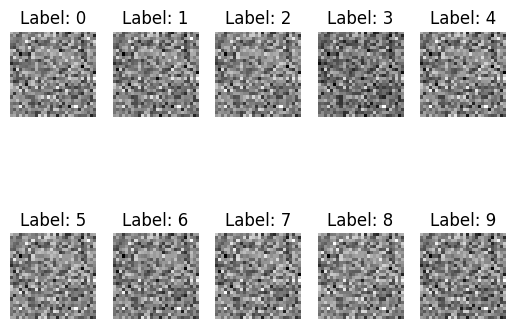

1/1 [==============================] - 0s 16ms/step
1 [Discriminator loss: 0.671028, acc.: 50.00%] [Generator loss: 0.664909]
1/1 [==============================] - 0s 18ms/step
2 [Discriminator loss: 0.658879, acc.: 50.00%] [Generator loss: 0.649667]
1/1 [==============================] - 0s 19ms/step
3 [Discriminator loss: 0.654521, acc.: 50.00%] [Generator loss: 0.644957]
1/1 [==============================] - 0s 16ms/step
4 [Discriminator loss: 0.640253, acc.: 50.00%] [Generator loss: 0.638852]
1/1 [==============================] - 0s 18ms/step
5 [Discriminator loss: 0.630505, acc.: 50.00%] [Generator loss: 0.622985]
1/1 [==============================] - 0s 18ms/step
6 [Discriminator loss: 0.614528, acc.: 50.00%] [Generator loss: 0.619933]
1/1 [==============================] - 0s 16ms/step
7 [Discriminator loss: 0.602559, acc.: 50.00%] [Generator loss: 0.598008]
1/1 [==============================] - 0s 18ms/step
8 [Discriminator loss: 0.576772, acc.: 50.00%] [Generator loss: 0.

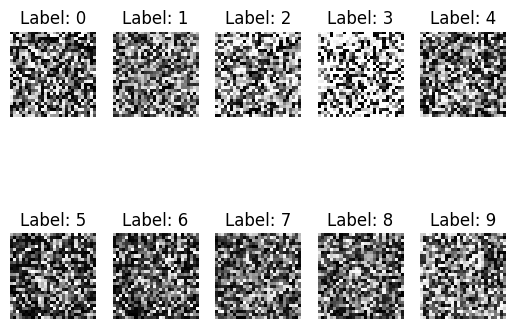

1/1 [==============================] - 0s 16ms/step
101 [Discriminator loss: 0.017910, acc.: 100.00%] [Generator loss: 7.250720]
1/1 [==============================] - 0s 16ms/step
102 [Discriminator loss: 0.078620, acc.: 96.88%] [Generator loss: 6.611618]
1/1 [==============================] - 0s 15ms/step
103 [Discriminator loss: 0.031835, acc.: 98.44%] [Generator loss: 7.007277]
1/1 [==============================] - 0s 17ms/step
104 [Discriminator loss: 0.032442, acc.: 98.44%] [Generator loss: 7.393554]
1/1 [==============================] - 0s 20ms/step
105 [Discriminator loss: 0.062216, acc.: 98.44%] [Generator loss: 6.792821]
1/1 [==============================] - 0s 22ms/step
106 [Discriminator loss: 0.007941, acc.: 100.00%] [Generator loss: 6.881287]
1/1 [==============================] - 0s 16ms/step
107 [Discriminator loss: 0.008964, acc.: 100.00%] [Generator loss: 6.834381]
1/1 [==============================] - 0s 15ms/step
108 [Discriminator loss: 0.036471, acc.: 98.44%] 

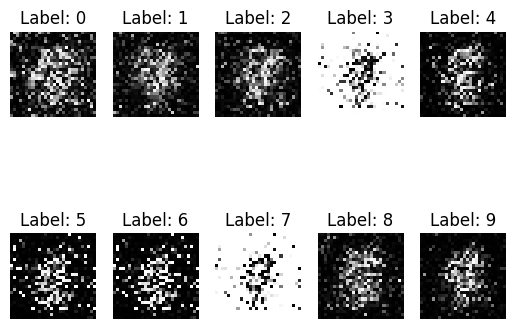

1/1 [==============================] - 0s 18ms/step
201 [Discriminator loss: 0.151347, acc.: 92.19%] [Generator loss: 6.517473]
1/1 [==============================] - 0s 16ms/step
202 [Discriminator loss: 0.121126, acc.: 93.75%] [Generator loss: 7.595399]
1/1 [==============================] - 0s 16ms/step
203 [Discriminator loss: 0.281659, acc.: 89.06%] [Generator loss: 5.882698]
1/1 [==============================] - 0s 16ms/step
204 [Discriminator loss: 0.060076, acc.: 98.44%] [Generator loss: 6.285594]
1/1 [==============================] - 0s 16ms/step
205 [Discriminator loss: 0.165014, acc.: 92.19%] [Generator loss: 6.692391]
1/1 [==============================] - 0s 19ms/step
206 [Discriminator loss: 0.137188, acc.: 95.31%] [Generator loss: 8.069174]
1/1 [==============================] - 0s 20ms/step
207 [Discriminator loss: 0.272146, acc.: 89.06%] [Generator loss: 6.780663]
1/1 [==============================] - 0s 16ms/step
208 [Discriminator loss: 0.279566, acc.: 89.06%] [Ge

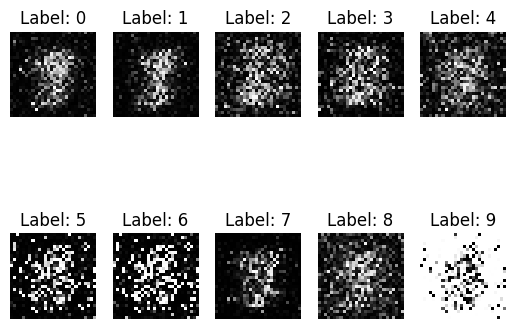

1/1 [==============================] - 0s 26ms/step
301 [Discriminator loss: 0.237266, acc.: 89.06%] [Generator loss: 5.273375]
1/1 [==============================] - 0s 15ms/step
302 [Discriminator loss: 0.216493, acc.: 90.62%] [Generator loss: 6.288711]
1/1 [==============================] - 0s 15ms/step
303 [Discriminator loss: 0.120262, acc.: 95.31%] [Generator loss: 6.157628]
1/1 [==============================] - 0s 18ms/step
304 [Discriminator loss: 0.193732, acc.: 95.31%] [Generator loss: 5.851885]
1/1 [==============================] - 0s 18ms/step
305 [Discriminator loss: 0.261558, acc.: 90.62%] [Generator loss: 5.057670]
1/1 [==============================] - 0s 22ms/step
306 [Discriminator loss: 0.105909, acc.: 98.44%] [Generator loss: 5.924870]
1/1 [==============================] - 0s 18ms/step
307 [Discriminator loss: 0.152846, acc.: 92.19%] [Generator loss: 5.564112]
1/1 [==============================] - 0s 16ms/step
308 [Discriminator loss: 0.113594, acc.: 95.31%] [Ge

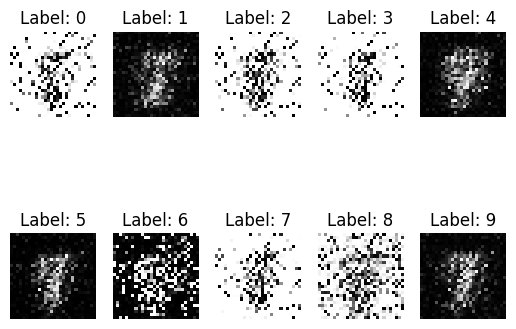

1/1 [==============================] - 0s 39ms/step
401 [Discriminator loss: 0.189500, acc.: 92.19%] [Generator loss: 4.040530]
1/1 [==============================] - 0s 27ms/step
402 [Discriminator loss: 0.292320, acc.: 85.94%] [Generator loss: 3.656036]
1/1 [==============================] - 0s 24ms/step
403 [Discriminator loss: 0.251591, acc.: 85.94%] [Generator loss: 4.352230]
1/1 [==============================] - 0s 28ms/step
404 [Discriminator loss: 0.243101, acc.: 90.62%] [Generator loss: 4.343959]
1/1 [==============================] - 0s 24ms/step
405 [Discriminator loss: 0.238300, acc.: 90.62%] [Generator loss: 3.353282]
1/1 [==============================] - 0s 25ms/step
406 [Discriminator loss: 0.287524, acc.: 85.94%] [Generator loss: 3.577538]
1/1 [==============================] - 0s 27ms/step
407 [Discriminator loss: 0.254692, acc.: 90.62%] [Generator loss: 3.863994]
1/1 [==============================] - 0s 25ms/step
408 [Discriminator loss: 0.200431, acc.: 93.75%] [Ge

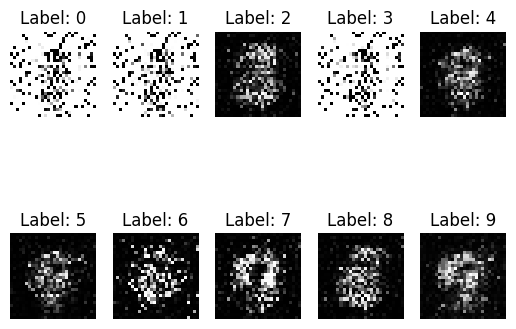

1/1 [==============================] - 0s 26ms/step
501 [Discriminator loss: 0.131727, acc.: 98.44%] [Generator loss: 3.107774]
1/1 [==============================] - 0s 17ms/step
502 [Discriminator loss: 0.301284, acc.: 85.94%] [Generator loss: 2.949690]
1/1 [==============================] - 0s 16ms/step
503 [Discriminator loss: 0.342950, acc.: 89.06%] [Generator loss: 2.727048]
1/1 [==============================] - 0s 17ms/step
504 [Discriminator loss: 0.470760, acc.: 84.38%] [Generator loss: 2.599030]
1/1 [==============================] - 0s 15ms/step
505 [Discriminator loss: 0.367749, acc.: 82.81%] [Generator loss: 3.321549]
1/1 [==============================] - 0s 17ms/step
506 [Discriminator loss: 0.411216, acc.: 81.25%] [Generator loss: 2.815888]
1/1 [==============================] - 0s 19ms/step
507 [Discriminator loss: 0.522598, acc.: 71.88%] [Generator loss: 3.069102]
1/1 [==============================] - 0s 18ms/step
508 [Discriminator loss: 0.446861, acc.: 87.50%] [Ge

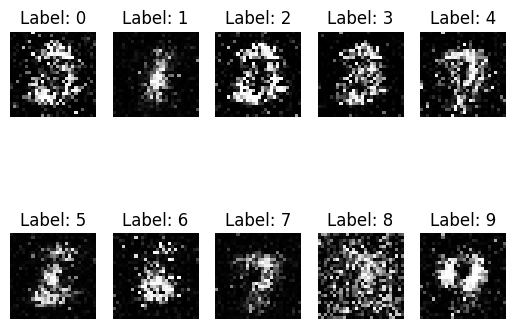

1/1 [==============================] - 0s 19ms/step
601 [Discriminator loss: 0.442016, acc.: 78.12%] [Generator loss: 2.191652]
1/1 [==============================] - 0s 19ms/step
602 [Discriminator loss: 0.421785, acc.: 82.81%] [Generator loss: 2.404049]
1/1 [==============================] - 0s 16ms/step
603 [Discriminator loss: 0.393227, acc.: 78.12%] [Generator loss: 2.270546]
1/1 [==============================] - 0s 15ms/step
604 [Discriminator loss: 0.370375, acc.: 84.38%] [Generator loss: 2.405023]
1/1 [==============================] - 0s 18ms/step
605 [Discriminator loss: 0.379696, acc.: 82.81%] [Generator loss: 2.101008]
1/1 [==============================] - 0s 17ms/step
606 [Discriminator loss: 0.491105, acc.: 75.00%] [Generator loss: 2.125602]
1/1 [==============================] - 0s 15ms/step
607 [Discriminator loss: 0.319135, acc.: 84.38%] [Generator loss: 2.389102]
1/1 [==============================] - 0s 17ms/step
608 [Discriminator loss: 0.492261, acc.: 78.12%] [Ge

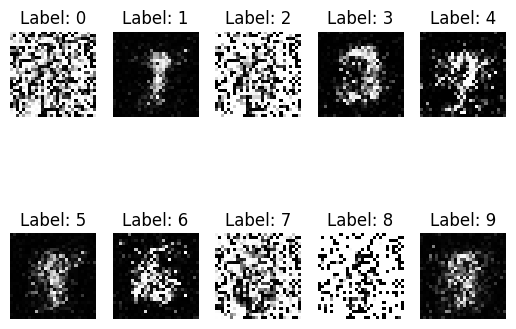

1/1 [==============================] - 0s 23ms/step
701 [Discriminator loss: 0.431377, acc.: 81.25%] [Generator loss: 2.129789]
1/1 [==============================] - 0s 19ms/step
702 [Discriminator loss: 0.539134, acc.: 71.88%] [Generator loss: 2.170515]
1/1 [==============================] - 0s 19ms/step
703 [Discriminator loss: 0.453383, acc.: 73.44%] [Generator loss: 2.176547]
1/1 [==============================] - 0s 18ms/step
704 [Discriminator loss: 0.297034, acc.: 84.38%] [Generator loss: 2.295249]
1/1 [==============================] - 0s 20ms/step
705 [Discriminator loss: 0.405336, acc.: 82.81%] [Generator loss: 2.200009]
1/1 [==============================] - 0s 20ms/step
706 [Discriminator loss: 0.359180, acc.: 82.81%] [Generator loss: 2.169431]
1/1 [==============================] - 0s 21ms/step
707 [Discriminator loss: 0.517907, acc.: 70.31%] [Generator loss: 2.049811]
1/1 [==============================] - 0s 20ms/step
708 [Discriminator loss: 0.376309, acc.: 84.38%] [Ge

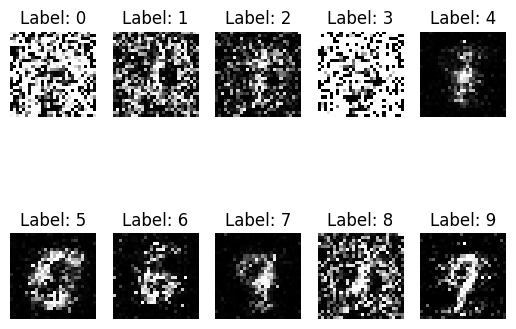

1/1 [==============================] - 0s 17ms/step
801 [Discriminator loss: 0.501585, acc.: 82.81%] [Generator loss: 2.087660]
1/1 [==============================] - 0s 16ms/step
802 [Discriminator loss: 0.436575, acc.: 79.69%] [Generator loss: 2.176925]
1/1 [==============================] - 0s 16ms/step
803 [Discriminator loss: 0.510417, acc.: 78.12%] [Generator loss: 1.943764]
1/1 [==============================] - 0s 18ms/step
804 [Discriminator loss: 0.729571, acc.: 53.12%] [Generator loss: 2.284238]
1/1 [==============================] - 0s 19ms/step
805 [Discriminator loss: 0.530427, acc.: 73.44%] [Generator loss: 2.174195]
1/1 [==============================] - 0s 16ms/step
806 [Discriminator loss: 0.377911, acc.: 81.25%] [Generator loss: 2.173535]
1/1 [==============================] - 0s 16ms/step
807 [Discriminator loss: 0.349335, acc.: 81.25%] [Generator loss: 1.875975]
1/1 [==============================] - 0s 16ms/step
808 [Discriminator loss: 0.324699, acc.: 89.06%] [Ge

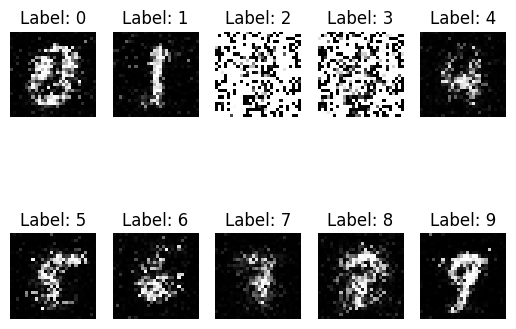

1/1 [==============================] - 0s 25ms/step
901 [Discriminator loss: 0.320829, acc.: 87.50%] [Generator loss: 2.231945]
1/1 [==============================] - 0s 24ms/step
902 [Discriminator loss: 0.496125, acc.: 67.19%] [Generator loss: 1.988063]
1/1 [==============================] - 0s 27ms/step
903 [Discriminator loss: 0.642177, acc.: 67.19%] [Generator loss: 2.461323]
1/1 [==============================] - 0s 25ms/step
904 [Discriminator loss: 0.465707, acc.: 75.00%] [Generator loss: 2.156054]
1/1 [==============================] - 0s 27ms/step
905 [Discriminator loss: 0.519943, acc.: 79.69%] [Generator loss: 2.356879]
1/1 [==============================] - 0s 25ms/step
906 [Discriminator loss: 0.380089, acc.: 82.81%] [Generator loss: 1.841479]
1/1 [==============================] - 0s 28ms/step
907 [Discriminator loss: 0.371486, acc.: 82.81%] [Generator loss: 1.743032]
1/1 [==============================] - 0s 31ms/step
908 [Discriminator loss: 0.327301, acc.: 85.94%] [Ge

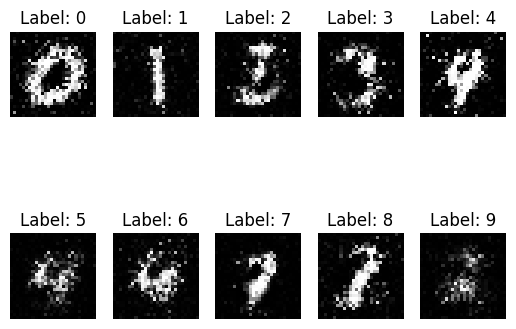

1/1 [==============================] - 0s 17ms/step
1001 [Discriminator loss: 0.412105, acc.: 75.00%] [Generator loss: 2.311623]
1/1 [==============================] - 0s 23ms/step
1002 [Discriminator loss: 0.451223, acc.: 78.12%] [Generator loss: 1.876566]
1/1 [==============================] - 0s 15ms/step
1003 [Discriminator loss: 0.517211, acc.: 68.75%] [Generator loss: 1.844458]
1/1 [==============================] - 0s 17ms/step
1004 [Discriminator loss: 0.362532, acc.: 89.06%] [Generator loss: 2.073239]
1/1 [==============================] - 0s 17ms/step
1005 [Discriminator loss: 0.398215, acc.: 82.81%] [Generator loss: 2.254508]
1/1 [==============================] - 0s 20ms/step
1006 [Discriminator loss: 0.424233, acc.: 81.25%] [Generator loss: 1.979713]
1/1 [==============================] - 0s 16ms/step
1007 [Discriminator loss: 0.431565, acc.: 84.38%] [Generator loss: 1.954447]
1/1 [==============================] - 0s 17ms/step
1008 [Discriminator loss: 0.365944, acc.: 84.

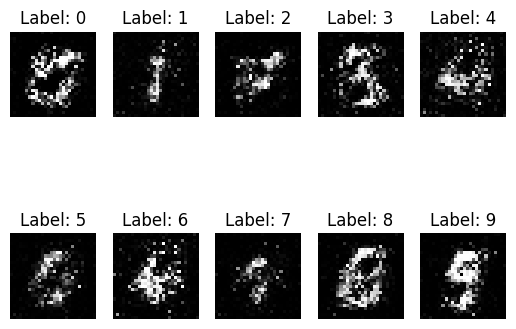

1/1 [==============================] - 0s 24ms/step
1101 [Discriminator loss: 0.587813, acc.: 67.19%] [Generator loss: 1.963252]
1/1 [==============================] - 0s 21ms/step
1102 [Discriminator loss: 0.456008, acc.: 78.12%] [Generator loss: 1.910398]
1/1 [==============================] - 0s 25ms/step
1103 [Discriminator loss: 0.412970, acc.: 79.69%] [Generator loss: 1.936557]
1/1 [==============================] - 0s 27ms/step
1104 [Discriminator loss: 0.615121, acc.: 60.94%] [Generator loss: 1.827758]
1/1 [==============================] - 0s 26ms/step
1105 [Discriminator loss: 0.395813, acc.: 81.25%] [Generator loss: 1.572443]
1/1 [==============================] - 0s 26ms/step
1106 [Discriminator loss: 0.342499, acc.: 85.94%] [Generator loss: 1.790121]
1/1 [==============================] - 0s 29ms/step
1107 [Discriminator loss: 0.387179, acc.: 90.62%] [Generator loss: 1.897927]
1/1 [==============================] - 0s 24ms/step
1108 [Discriminator loss: 0.506378, acc.: 73.

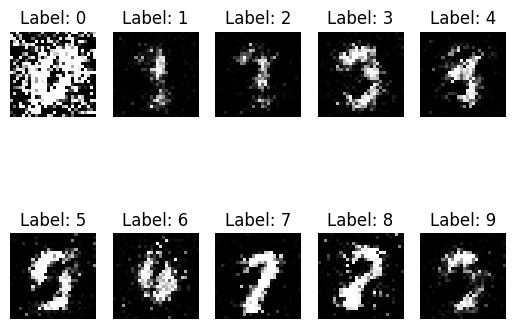

1/1 [==============================] - 0s 16ms/step
1201 [Discriminator loss: 0.465636, acc.: 76.56%] [Generator loss: 1.751236]
1/1 [==============================] - 0s 15ms/step
1202 [Discriminator loss: 0.560633, acc.: 70.31%] [Generator loss: 1.397016]
1/1 [==============================] - 0s 15ms/step
1203 [Discriminator loss: 0.705194, acc.: 65.62%] [Generator loss: 2.017114]
1/1 [==============================] - 0s 16ms/step
1204 [Discriminator loss: 0.482906, acc.: 78.12%] [Generator loss: 1.989560]
1/1 [==============================] - 0s 17ms/step
1205 [Discriminator loss: 0.609312, acc.: 60.94%] [Generator loss: 1.696433]
1/1 [==============================] - 0s 16ms/step
1206 [Discriminator loss: 0.413120, acc.: 81.25%] [Generator loss: 1.324863]
1/1 [==============================] - 0s 17ms/step
1207 [Discriminator loss: 0.626108, acc.: 65.62%] [Generator loss: 1.864499]
1/1 [==============================] - 0s 17ms/step
1208 [Discriminator loss: 0.589528, acc.: 67.

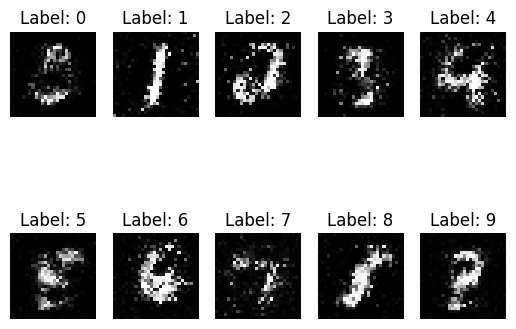

1/1 [==============================] - 0s 17ms/step
1301 [Discriminator loss: 0.563424, acc.: 68.75%] [Generator loss: 1.639764]
1/1 [==============================] - 0s 16ms/step
1302 [Discriminator loss: 0.620282, acc.: 65.62%] [Generator loss: 1.879380]
1/1 [==============================] - 0s 17ms/step
1303 [Discriminator loss: 0.506207, acc.: 76.56%] [Generator loss: 1.839874]
1/1 [==============================] - 0s 15ms/step
1304 [Discriminator loss: 0.479022, acc.: 76.56%] [Generator loss: 1.872849]
1/1 [==============================] - 0s 18ms/step
1305 [Discriminator loss: 0.502058, acc.: 68.75%] [Generator loss: 1.448524]
1/1 [==============================] - 0s 17ms/step
1306 [Discriminator loss: 0.445854, acc.: 75.00%] [Generator loss: 1.678477]
1/1 [==============================] - 0s 16ms/step
1307 [Discriminator loss: 0.432418, acc.: 82.81%] [Generator loss: 1.565730]
1/1 [==============================] - 0s 16ms/step
1308 [Discriminator loss: 0.515817, acc.: 75.

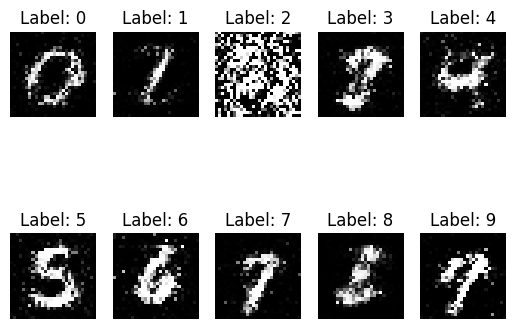

1/1 [==============================] - 0s 26ms/step
1401 [Discriminator loss: 0.497364, acc.: 73.44%] [Generator loss: 1.465178]
1/1 [==============================] - 0s 28ms/step
1402 [Discriminator loss: 0.522208, acc.: 71.88%] [Generator loss: 1.459083]
1/1 [==============================] - 0s 16ms/step
1403 [Discriminator loss: 0.485000, acc.: 76.56%] [Generator loss: 1.459803]
1/1 [==============================] - 0s 24ms/step
1404 [Discriminator loss: 0.656868, acc.: 57.81%] [Generator loss: 1.494583]
1/1 [==============================] - 0s 18ms/step
1405 [Discriminator loss: 0.426891, acc.: 84.38%] [Generator loss: 1.672159]
1/1 [==============================] - 0s 16ms/step
1406 [Discriminator loss: 0.578019, acc.: 67.19%] [Generator loss: 1.543587]
1/1 [==============================] - 0s 16ms/step
1407 [Discriminator loss: 0.681385, acc.: 59.38%] [Generator loss: 1.495212]
1/1 [==============================] - 0s 18ms/step
1408 [Discriminator loss: 0.476144, acc.: 79.

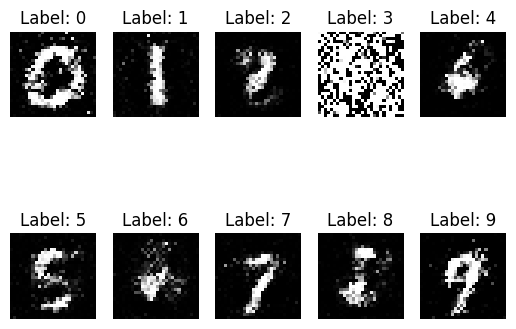

1/1 [==============================] - 0s 31ms/step
1501 [Discriminator loss: 0.645684, acc.: 62.50%] [Generator loss: 1.294650]
1/1 [==============================] - 0s 27ms/step
1502 [Discriminator loss: 0.643754, acc.: 67.19%] [Generator loss: 1.390211]
1/1 [==============================] - 0s 32ms/step
1503 [Discriminator loss: 0.618482, acc.: 64.06%] [Generator loss: 1.245605]
1/1 [==============================] - 0s 27ms/step
1504 [Discriminator loss: 0.568885, acc.: 67.19%] [Generator loss: 1.316093]
1/1 [==============================] - 0s 38ms/step
1505 [Discriminator loss: 0.614070, acc.: 62.50%] [Generator loss: 1.461926]
1/1 [==============================] - 0s 40ms/step
1506 [Discriminator loss: 0.634979, acc.: 67.19%] [Generator loss: 1.417335]
1/1 [==============================] - 0s 36ms/step
1507 [Discriminator loss: 0.650821, acc.: 64.06%] [Generator loss: 1.365026]
1/1 [==============================] - 0s 49ms/step
1508 [Discriminator loss: 0.609796, acc.: 70.

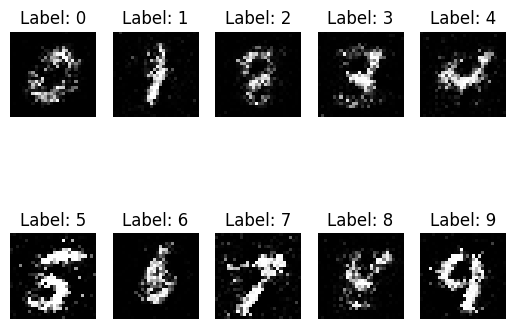

1/1 [==============================] - 0s 18ms/step
1601 [Discriminator loss: 0.618260, acc.: 62.50%] [Generator loss: 1.169427]
1/1 [==============================] - 0s 16ms/step
1602 [Discriminator loss: 0.655857, acc.: 67.19%] [Generator loss: 1.110145]
1/1 [==============================] - 0s 16ms/step
1603 [Discriminator loss: 0.574366, acc.: 68.75%] [Generator loss: 1.140541]
1/1 [==============================] - 0s 15ms/step
1604 [Discriminator loss: 0.570484, acc.: 64.06%] [Generator loss: 1.129292]
1/1 [==============================] - 0s 15ms/step
1605 [Discriminator loss: 0.575449, acc.: 68.75%] [Generator loss: 1.159586]
1/1 [==============================] - 0s 15ms/step
1606 [Discriminator loss: 0.461693, acc.: 78.12%] [Generator loss: 1.268019]
1/1 [==============================] - 0s 15ms/step
1607 [Discriminator loss: 0.608993, acc.: 62.50%] [Generator loss: 1.078603]
1/1 [==============================] - 0s 24ms/step
1608 [Discriminator loss: 0.595109, acc.: 65.

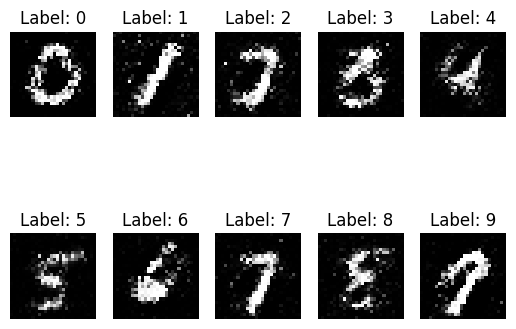

1/1 [==============================] - 0s 17ms/step
1701 [Discriminator loss: 0.597021, acc.: 70.31%] [Generator loss: 1.056690]
1/1 [==============================] - 0s 16ms/step
1702 [Discriminator loss: 0.765987, acc.: 48.44%] [Generator loss: 1.063674]
1/1 [==============================] - 0s 17ms/step
1703 [Discriminator loss: 0.599515, acc.: 68.75%] [Generator loss: 1.152525]
1/1 [==============================] - 0s 16ms/step
1704 [Discriminator loss: 0.657244, acc.: 59.38%] [Generator loss: 1.118564]
1/1 [==============================] - 0s 19ms/step
1705 [Discriminator loss: 0.653455, acc.: 60.94%] [Generator loss: 1.072828]
1/1 [==============================] - 0s 15ms/step
1706 [Discriminator loss: 0.579930, acc.: 60.94%] [Generator loss: 1.020507]
1/1 [==============================] - 0s 16ms/step
1707 [Discriminator loss: 0.606394, acc.: 65.62%] [Generator loss: 1.101408]
1/1 [==============================] - 0s 20ms/step
1708 [Discriminator loss: 0.618411, acc.: 67.

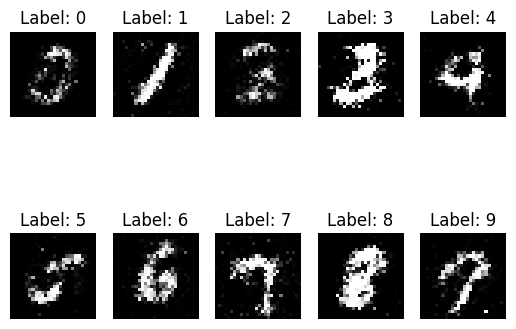

1/1 [==============================] - 0s 28ms/step
1801 [Discriminator loss: 0.657009, acc.: 62.50%] [Generator loss: 1.053956]
1/1 [==============================] - 0s 20ms/step
1802 [Discriminator loss: 0.613332, acc.: 68.75%] [Generator loss: 1.119351]
1/1 [==============================] - 0s 22ms/step
1803 [Discriminator loss: 0.652856, acc.: 56.25%] [Generator loss: 0.998871]
1/1 [==============================] - 0s 30ms/step
1804 [Discriminator loss: 0.605357, acc.: 59.38%] [Generator loss: 0.973318]
1/1 [==============================] - 0s 22ms/step
1805 [Discriminator loss: 0.637654, acc.: 67.19%] [Generator loss: 0.928166]
1/1 [==============================] - 0s 20ms/step
1806 [Discriminator loss: 0.618353, acc.: 65.62%] [Generator loss: 0.881861]
1/1 [==============================] - 0s 19ms/step
1807 [Discriminator loss: 0.700316, acc.: 54.69%] [Generator loss: 1.007744]
1/1 [==============================] - 0s 21ms/step
1808 [Discriminator loss: 0.578226, acc.: 68.

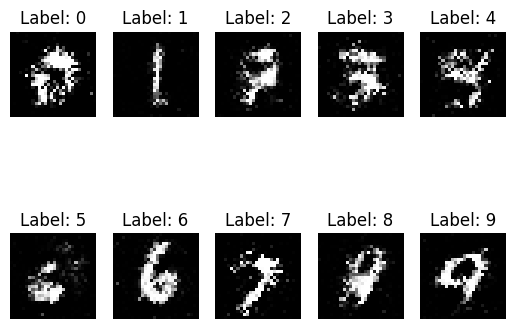

1/1 [==============================] - 0s 16ms/step
1901 [Discriminator loss: 0.745478, acc.: 54.69%] [Generator loss: 1.069331]
1/1 [==============================] - 0s 18ms/step
1902 [Discriminator loss: 0.627300, acc.: 64.06%] [Generator loss: 1.021634]
1/1 [==============================] - 0s 15ms/step
1903 [Discriminator loss: 0.690755, acc.: 62.50%] [Generator loss: 0.920479]
1/1 [==============================] - 0s 15ms/step
1904 [Discriminator loss: 0.602627, acc.: 62.50%] [Generator loss: 0.956855]
1/1 [==============================] - 0s 15ms/step
1905 [Discriminator loss: 0.699762, acc.: 51.56%] [Generator loss: 1.081221]
1/1 [==============================] - 0s 20ms/step
1906 [Discriminator loss: 0.700423, acc.: 56.25%] [Generator loss: 1.104967]
1/1 [==============================] - 0s 15ms/step
1907 [Discriminator loss: 0.694398, acc.: 60.94%] [Generator loss: 0.957878]
1/1 [==============================] - 0s 18ms/step
1908 [Discriminator loss: 0.679018, acc.: 56.

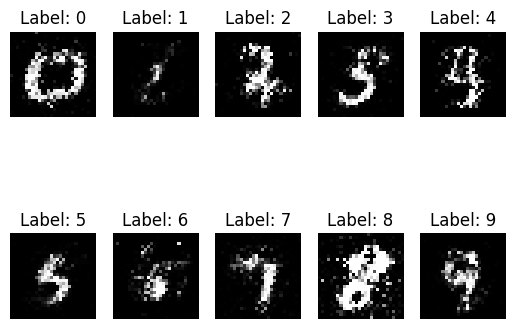

1/1 [==============================] - 0s 17ms/step
2001 [Discriminator loss: 0.595775, acc.: 67.19%] [Generator loss: 0.948979]
1/1 [==============================] - 0s 18ms/step
2002 [Discriminator loss: 0.583884, acc.: 67.19%] [Generator loss: 0.942008]
1/1 [==============================] - 0s 15ms/step
2003 [Discriminator loss: 0.659741, acc.: 60.94%] [Generator loss: 0.871511]
1/1 [==============================] - 0s 17ms/step
2004 [Discriminator loss: 0.578215, acc.: 65.62%] [Generator loss: 1.043307]
1/1 [==============================] - 0s 20ms/step
2005 [Discriminator loss: 0.645901, acc.: 64.06%] [Generator loss: 0.928266]
1/1 [==============================] - 0s 24ms/step
2006 [Discriminator loss: 0.566446, acc.: 70.31%] [Generator loss: 0.955168]
1/1 [==============================] - 0s 15ms/step
2007 [Discriminator loss: 0.587776, acc.: 68.75%] [Generator loss: 0.910887]
1/1 [==============================] - 0s 16ms/step
2008 [Discriminator loss: 0.666863, acc.: 57.

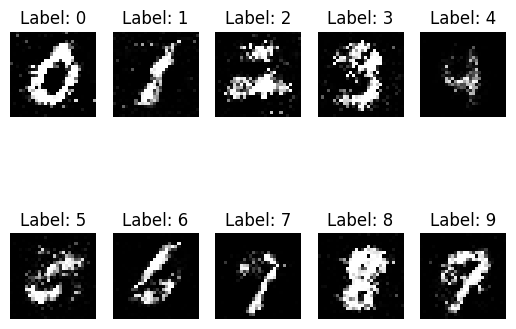

1/1 [==============================] - 0s 25ms/step
2101 [Discriminator loss: 0.647703, acc.: 60.94%] [Generator loss: 0.796510]
1/1 [==============================] - 0s 23ms/step
2102 [Discriminator loss: 0.575541, acc.: 70.31%] [Generator loss: 0.857848]
1/1 [==============================] - 0s 39ms/step
2103 [Discriminator loss: 0.684237, acc.: 51.56%] [Generator loss: 0.945844]
1/1 [==============================] - 0s 38ms/step
2104 [Discriminator loss: 0.666552, acc.: 56.25%] [Generator loss: 0.947810]
1/1 [==============================] - 0s 25ms/step
2105 [Discriminator loss: 0.714393, acc.: 51.56%] [Generator loss: 0.936218]
1/1 [==============================] - 0s 24ms/step
2106 [Discriminator loss: 0.634269, acc.: 64.06%] [Generator loss: 0.996985]
1/1 [==============================] - 0s 26ms/step
2107 [Discriminator loss: 0.708750, acc.: 50.00%] [Generator loss: 0.911903]
1/1 [==============================] - 0s 42ms/step
2108 [Discriminator loss: 0.734169, acc.: 54.

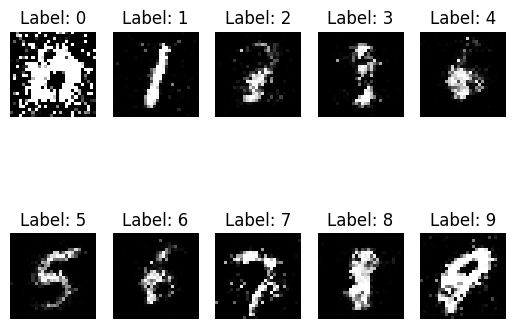

1/1 [==============================] - 0s 24ms/step
2201 [Discriminator loss: 0.671517, acc.: 56.25%] [Generator loss: 0.845709]
1/1 [==============================] - 0s 23ms/step
2202 [Discriminator loss: 0.651276, acc.: 59.38%] [Generator loss: 0.882812]
1/1 [==============================] - 0s 21ms/step
2203 [Discriminator loss: 0.677213, acc.: 64.06%] [Generator loss: 0.858110]
1/1 [==============================] - 0s 24ms/step
2204 [Discriminator loss: 0.636932, acc.: 62.50%] [Generator loss: 0.882251]
1/1 [==============================] - 0s 29ms/step
2205 [Discriminator loss: 0.625318, acc.: 62.50%] [Generator loss: 0.870784]
1/1 [==============================] - 0s 23ms/step
2206 [Discriminator loss: 0.618568, acc.: 62.50%] [Generator loss: 0.916593]
1/1 [==============================] - 0s 37ms/step
2207 [Discriminator loss: 0.569987, acc.: 67.19%] [Generator loss: 0.898896]
1/1 [==============================] - 0s 29ms/step
2208 [Discriminator loss: 0.692956, acc.: 56.

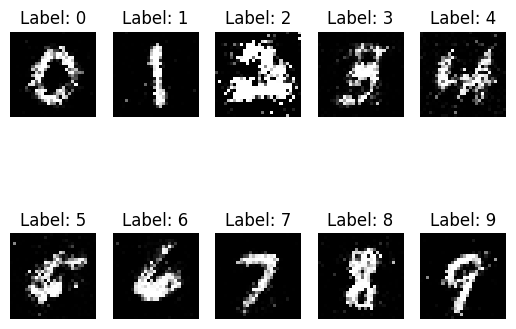

1/1 [==============================] - 0s 19ms/step
2301 [Discriminator loss: 0.630087, acc.: 67.19%] [Generator loss: 0.923532]
1/1 [==============================] - 0s 16ms/step
2302 [Discriminator loss: 0.680650, acc.: 59.38%] [Generator loss: 0.986483]
1/1 [==============================] - 0s 24ms/step
2303 [Discriminator loss: 0.628736, acc.: 67.19%] [Generator loss: 0.888932]
1/1 [==============================] - 0s 16ms/step
2304 [Discriminator loss: 0.701735, acc.: 50.00%] [Generator loss: 0.934623]
1/1 [==============================] - 0s 16ms/step
2305 [Discriminator loss: 0.645151, acc.: 62.50%] [Generator loss: 1.013589]
1/1 [==============================] - 0s 16ms/step
2306 [Discriminator loss: 0.699689, acc.: 51.56%] [Generator loss: 0.927818]
1/1 [==============================] - 0s 18ms/step
2307 [Discriminator loss: 0.654745, acc.: 62.50%] [Generator loss: 0.968726]
1/1 [==============================] - 0s 23ms/step
2308 [Discriminator loss: 0.592807, acc.: 75.

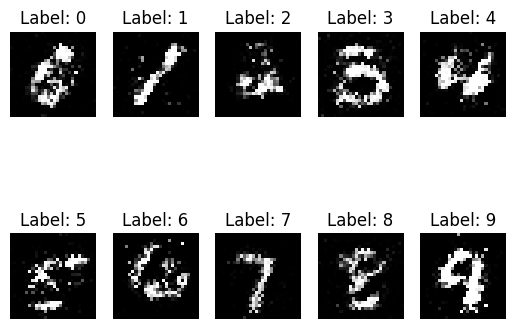

1/1 [==============================] - 0s 18ms/step
2401 [Discriminator loss: 0.642647, acc.: 54.69%] [Generator loss: 0.909049]
1/1 [==============================] - 0s 25ms/step
2402 [Discriminator loss: 0.617035, acc.: 60.94%] [Generator loss: 0.958478]
1/1 [==============================] - 0s 23ms/step
2403 [Discriminator loss: 0.626896, acc.: 64.06%] [Generator loss: 0.926453]
1/1 [==============================] - 0s 16ms/step
2404 [Discriminator loss: 0.651863, acc.: 60.94%] [Generator loss: 0.950373]
1/1 [==============================] - 0s 17ms/step
2405 [Discriminator loss: 0.600581, acc.: 71.88%] [Generator loss: 0.949337]
1/1 [==============================] - 0s 22ms/step
2406 [Discriminator loss: 0.683207, acc.: 57.81%] [Generator loss: 0.790662]
1/1 [==============================] - 0s 21ms/step
2407 [Discriminator loss: 0.650497, acc.: 65.62%] [Generator loss: 0.955740]
1/1 [==============================] - 0s 20ms/step
2408 [Discriminator loss: 0.674964, acc.: 64.

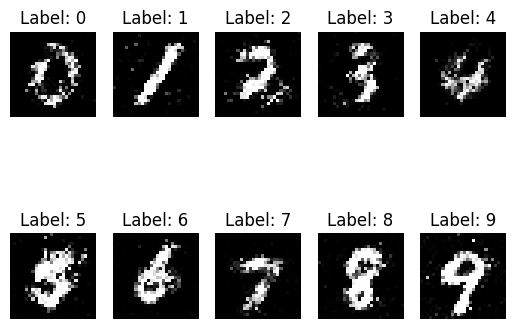

1/1 [==============================] - 0s 22ms/step
2501 [Discriminator loss: 0.635494, acc.: 57.81%] [Generator loss: 0.848576]
1/1 [==============================] - 0s 17ms/step
2502 [Discriminator loss: 0.701188, acc.: 50.00%] [Generator loss: 0.932685]
1/1 [==============================] - 0s 21ms/step
2503 [Discriminator loss: 0.626770, acc.: 60.94%] [Generator loss: 0.842683]
1/1 [==============================] - 0s 25ms/step
2504 [Discriminator loss: 0.667171, acc.: 56.25%] [Generator loss: 0.886082]
1/1 [==============================] - 0s 21ms/step
2505 [Discriminator loss: 0.628850, acc.: 70.31%] [Generator loss: 1.001013]
1/1 [==============================] - 0s 20ms/step
2506 [Discriminator loss: 0.669953, acc.: 62.50%] [Generator loss: 0.946884]
1/1 [==============================] - 0s 16ms/step
2507 [Discriminator loss: 0.679207, acc.: 62.50%] [Generator loss: 0.931007]
1/1 [==============================] - 0s 16ms/step
2508 [Discriminator loss: 0.675759, acc.: 57.

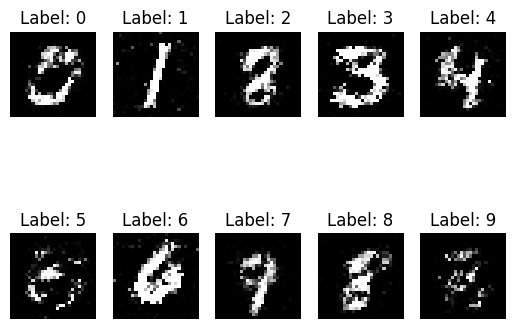

1/1 [==============================] - 0s 19ms/step
2601 [Discriminator loss: 0.666439, acc.: 57.81%] [Generator loss: 0.819085]
1/1 [==============================] - 0s 24ms/step
2602 [Discriminator loss: 0.718722, acc.: 46.88%] [Generator loss: 0.817270]
1/1 [==============================] - 0s 20ms/step
2603 [Discriminator loss: 0.643988, acc.: 64.06%] [Generator loss: 0.874959]
1/1 [==============================] - 0s 17ms/step
2604 [Discriminator loss: 0.586621, acc.: 71.88%] [Generator loss: 1.011067]
1/1 [==============================] - 0s 23ms/step
2605 [Discriminator loss: 0.666164, acc.: 51.56%] [Generator loss: 1.020889]
1/1 [==============================] - 0s 18ms/step
2606 [Discriminator loss: 0.606351, acc.: 65.62%] [Generator loss: 1.035483]
1/1 [==============================] - 0s 17ms/step
2607 [Discriminator loss: 0.738467, acc.: 46.88%] [Generator loss: 1.070393]
1/1 [==============================] - 0s 20ms/step
2608 [Discriminator loss: 0.671730, acc.: 60.

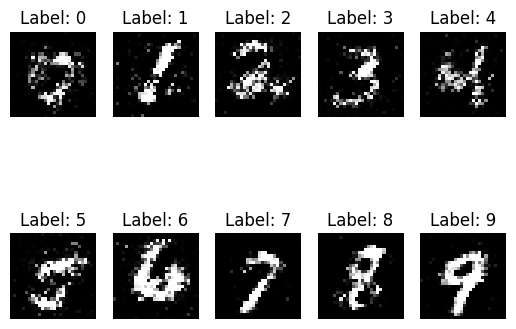

1/1 [==============================] - 0s 18ms/step
2701 [Discriminator loss: 0.662167, acc.: 64.06%] [Generator loss: 0.873735]
1/1 [==============================] - 0s 17ms/step
2702 [Discriminator loss: 0.656141, acc.: 59.38%] [Generator loss: 0.898468]
1/1 [==============================] - 0s 15ms/step
2703 [Discriminator loss: 0.679126, acc.: 59.38%] [Generator loss: 0.864959]
1/1 [==============================] - 0s 18ms/step
2704 [Discriminator loss: 0.657020, acc.: 60.94%] [Generator loss: 0.898046]
1/1 [==============================] - 0s 17ms/step
2705 [Discriminator loss: 0.668443, acc.: 56.25%] [Generator loss: 0.851738]
1/1 [==============================] - 0s 16ms/step
2706 [Discriminator loss: 0.644534, acc.: 62.50%] [Generator loss: 0.793864]
1/1 [==============================] - 0s 17ms/step
2707 [Discriminator loss: 0.693080, acc.: 59.38%] [Generator loss: 0.933445]
1/1 [==============================] - 0s 16ms/step
2708 [Discriminator loss: 0.642326, acc.: 59.

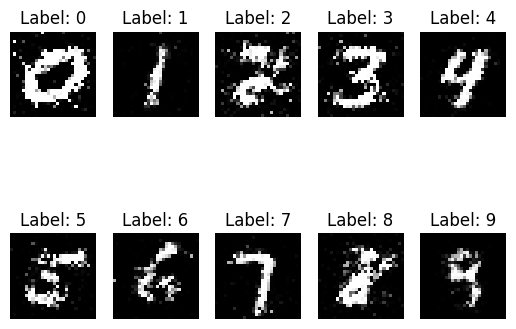

1/1 [==============================] - 0s 25ms/step
2801 [Discriminator loss: 0.682233, acc.: 56.25%] [Generator loss: 0.832402]
1/1 [==============================] - 0s 24ms/step
2802 [Discriminator loss: 0.726272, acc.: 46.88%] [Generator loss: 0.888170]
1/1 [==============================] - 0s 24ms/step
2803 [Discriminator loss: 0.677765, acc.: 60.94%] [Generator loss: 0.828534]
1/1 [==============================] - 0s 31ms/step
2804 [Discriminator loss: 0.651389, acc.: 62.50%] [Generator loss: 0.893547]
1/1 [==============================] - 0s 46ms/step
2805 [Discriminator loss: 0.659934, acc.: 60.94%] [Generator loss: 0.843428]
1/1 [==============================] - 0s 37ms/step
2806 [Discriminator loss: 0.666317, acc.: 64.06%] [Generator loss: 0.820161]
1/1 [==============================] - 0s 26ms/step
2807 [Discriminator loss: 0.654989, acc.: 60.94%] [Generator loss: 0.826526]
1/1 [==============================] - 0s 25ms/step
2808 [Discriminator loss: 0.715510, acc.: 56.

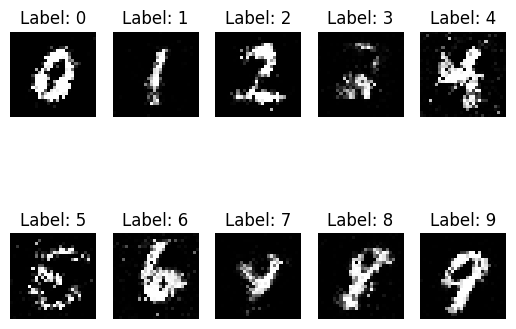

1/1 [==============================] - 0s 34ms/step
2901 [Discriminator loss: 0.656329, acc.: 57.81%] [Generator loss: 0.930012]
1/1 [==============================] - 0s 28ms/step
2902 [Discriminator loss: 0.662066, acc.: 62.50%] [Generator loss: 0.850281]
1/1 [==============================] - 0s 31ms/step
2903 [Discriminator loss: 0.677380, acc.: 62.50%] [Generator loss: 0.834979]
1/1 [==============================] - 0s 30ms/step
2904 [Discriminator loss: 0.637011, acc.: 67.19%] [Generator loss: 0.860547]
1/1 [==============================] - 0s 36ms/step
2905 [Discriminator loss: 0.673317, acc.: 57.81%] [Generator loss: 0.857070]
1/1 [==============================] - 0s 32ms/step
2906 [Discriminator loss: 0.665958, acc.: 53.12%] [Generator loss: 0.829512]
1/1 [==============================] - 0s 40ms/step
2907 [Discriminator loss: 0.687064, acc.: 56.25%] [Generator loss: 0.867656]
1/1 [==============================] - 0s 32ms/step
2908 [Discriminator loss: 0.683201, acc.: 57.

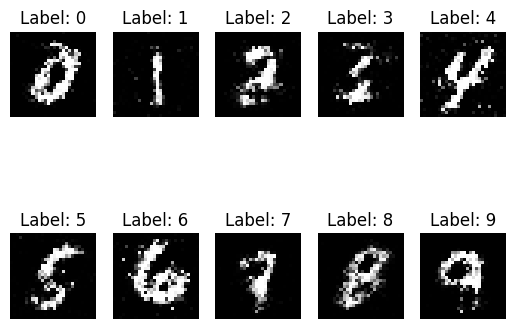

1/1 [==============================] - 0s 29ms/step
3001 [Discriminator loss: 0.662012, acc.: 57.81%] [Generator loss: 0.808949]
1/1 [==============================] - 0s 26ms/step
3002 [Discriminator loss: 0.671484, acc.: 62.50%] [Generator loss: 0.796472]
1/1 [==============================] - 0s 23ms/step
3003 [Discriminator loss: 0.667432, acc.: 64.06%] [Generator loss: 0.764717]
1/1 [==============================] - 0s 34ms/step
3004 [Discriminator loss: 0.672226, acc.: 51.56%] [Generator loss: 0.858999]
1/1 [==============================] - 0s 36ms/step
3005 [Discriminator loss: 0.620061, acc.: 65.62%] [Generator loss: 0.830898]
1/1 [==============================] - 0s 29ms/step
3006 [Discriminator loss: 0.641391, acc.: 68.75%] [Generator loss: 0.867083]
1/1 [==============================] - 0s 34ms/step
3007 [Discriminator loss: 0.723332, acc.: 45.31%] [Generator loss: 0.887402]
1/1 [==============================] - 0s 41ms/step
3008 [Discriminator loss: 0.668094, acc.: 54.

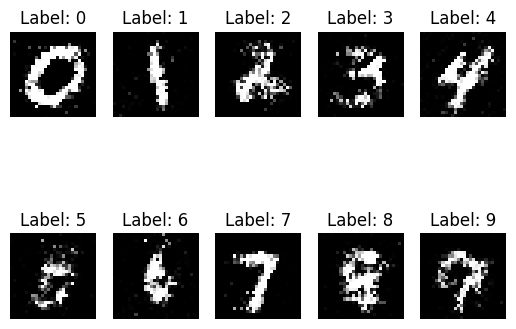

1/1 [==============================] - 0s 18ms/step
3101 [Discriminator loss: 0.668471, acc.: 59.38%] [Generator loss: 0.935417]
1/1 [==============================] - 0s 16ms/step
3102 [Discriminator loss: 0.704402, acc.: 50.00%] [Generator loss: 0.851298]
1/1 [==============================] - 0s 16ms/step
3103 [Discriminator loss: 0.652337, acc.: 60.94%] [Generator loss: 0.851087]
1/1 [==============================] - 0s 18ms/step
3104 [Discriminator loss: 0.647269, acc.: 57.81%] [Generator loss: 0.954494]
1/1 [==============================] - 0s 16ms/step
3105 [Discriminator loss: 0.655075, acc.: 56.25%] [Generator loss: 0.805809]
1/1 [==============================] - 0s 18ms/step
3106 [Discriminator loss: 0.721838, acc.: 53.12%] [Generator loss: 0.814422]
1/1 [==============================] - 0s 20ms/step
3107 [Discriminator loss: 0.638488, acc.: 59.38%] [Generator loss: 0.764052]
1/1 [==============================] - 0s 19ms/step
3108 [Discriminator loss: 0.708337, acc.: 46.

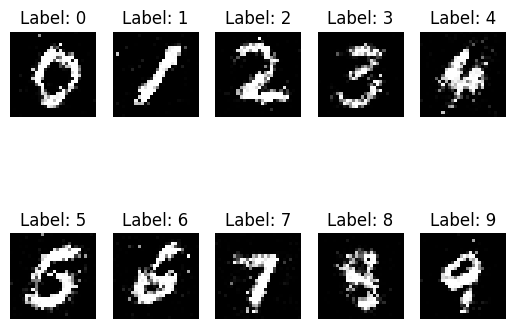

1/1 [==============================] - 0s 16ms/step
3201 [Discriminator loss: 0.690158, acc.: 59.38%] [Generator loss: 0.798903]
1/1 [==============================] - 0s 20ms/step
3202 [Discriminator loss: 0.658307, acc.: 65.62%] [Generator loss: 0.893212]
1/1 [==============================] - 0s 15ms/step
3203 [Discriminator loss: 0.625019, acc.: 67.19%] [Generator loss: 0.912030]
1/1 [==============================] - 0s 18ms/step
3204 [Discriminator loss: 0.658988, acc.: 59.38%] [Generator loss: 0.854573]
1/1 [==============================] - 0s 19ms/step
3205 [Discriminator loss: 0.699806, acc.: 51.56%] [Generator loss: 0.897091]
1/1 [==============================] - 0s 16ms/step
3206 [Discriminator loss: 0.667473, acc.: 59.38%] [Generator loss: 0.873980]
1/1 [==============================] - 0s 17ms/step
3207 [Discriminator loss: 0.644166, acc.: 64.06%] [Generator loss: 0.914351]
1/1 [==============================] - 0s 16ms/step
3208 [Discriminator loss: 0.698251, acc.: 51.

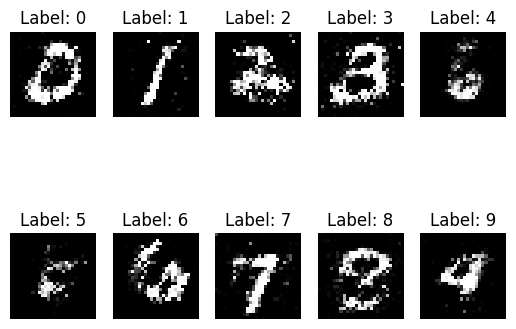

1/1 [==============================] - 0s 20ms/step
3301 [Discriminator loss: 0.667553, acc.: 53.12%] [Generator loss: 0.935378]
1/1 [==============================] - 0s 19ms/step
3302 [Discriminator loss: 0.630929, acc.: 57.81%] [Generator loss: 0.988550]
1/1 [==============================] - 0s 28ms/step
3303 [Discriminator loss: 0.652705, acc.: 54.69%] [Generator loss: 0.921515]
1/1 [==============================] - 0s 29ms/step
3304 [Discriminator loss: 0.670569, acc.: 59.38%] [Generator loss: 0.956531]
1/1 [==============================] - 0s 21ms/step
3305 [Discriminator loss: 0.638966, acc.: 64.06%] [Generator loss: 0.874067]
1/1 [==============================] - 0s 21ms/step
3306 [Discriminator loss: 0.663804, acc.: 51.56%] [Generator loss: 0.944738]
1/1 [==============================] - 0s 30ms/step
3307 [Discriminator loss: 0.683855, acc.: 53.12%] [Generator loss: 0.984814]
1/1 [==============================] - 0s 25ms/step
3308 [Discriminator loss: 0.649652, acc.: 57.

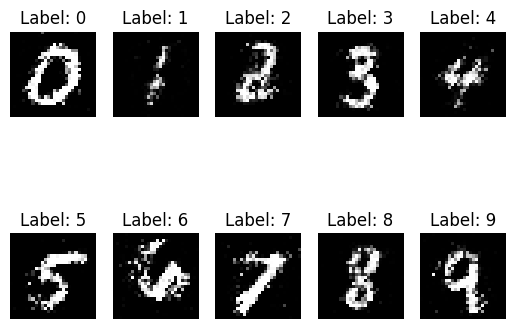

1/1 [==============================] - 0s 19ms/step
3401 [Discriminator loss: 0.641337, acc.: 62.50%] [Generator loss: 0.824342]
1/1 [==============================] - 0s 21ms/step
3402 [Discriminator loss: 0.689592, acc.: 54.69%] [Generator loss: 0.969277]
1/1 [==============================] - 0s 17ms/step
3403 [Discriminator loss: 0.656356, acc.: 56.25%] [Generator loss: 1.014141]
1/1 [==============================] - 0s 16ms/step
3404 [Discriminator loss: 0.622473, acc.: 71.88%] [Generator loss: 0.923051]
1/1 [==============================] - 0s 17ms/step
3405 [Discriminator loss: 0.703223, acc.: 53.12%] [Generator loss: 0.866672]
1/1 [==============================] - 0s 20ms/step
3406 [Discriminator loss: 0.689936, acc.: 56.25%] [Generator loss: 0.922079]
1/1 [==============================] - 0s 26ms/step
3407 [Discriminator loss: 0.644992, acc.: 56.25%] [Generator loss: 0.886676]
1/1 [==============================] - 0s 19ms/step
3408 [Discriminator loss: 0.657656, acc.: 62.

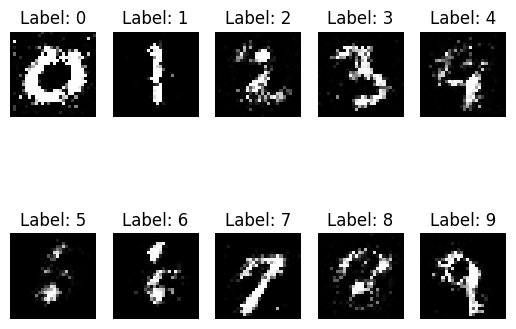

1/1 [==============================] - 0s 16ms/step
3501 [Discriminator loss: 0.653557, acc.: 53.12%] [Generator loss: 0.861183]
1/1 [==============================] - 0s 15ms/step
3502 [Discriminator loss: 0.642571, acc.: 64.06%] [Generator loss: 0.861240]
1/1 [==============================] - 0s 16ms/step
3503 [Discriminator loss: 0.672035, acc.: 62.50%] [Generator loss: 0.874355]
1/1 [==============================] - 0s 16ms/step
3504 [Discriminator loss: 0.708060, acc.: 46.88%] [Generator loss: 0.882722]
1/1 [==============================] - 0s 17ms/step
3505 [Discriminator loss: 0.635102, acc.: 59.38%] [Generator loss: 0.871787]
1/1 [==============================] - 0s 25ms/step
3506 [Discriminator loss: 0.685269, acc.: 53.12%] [Generator loss: 0.864753]
1/1 [==============================] - 0s 20ms/step
3507 [Discriminator loss: 0.589457, acc.: 67.19%] [Generator loss: 0.896810]
1/1 [==============================] - 0s 25ms/step
3508 [Discriminator loss: 0.648169, acc.: 60.

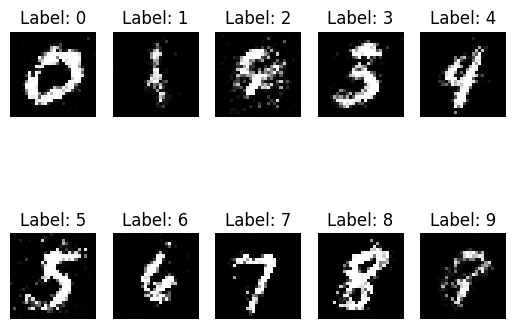

1/1 [==============================] - 0s 17ms/step
3601 [Discriminator loss: 0.641076, acc.: 54.69%] [Generator loss: 0.883372]
1/1 [==============================] - 0s 17ms/step
3602 [Discriminator loss: 0.630586, acc.: 59.38%] [Generator loss: 0.835789]
1/1 [==============================] - 0s 20ms/step
3603 [Discriminator loss: 0.607556, acc.: 62.50%] [Generator loss: 0.852864]
1/1 [==============================] - 0s 22ms/step
3604 [Discriminator loss: 0.700402, acc.: 54.69%] [Generator loss: 0.788850]
1/1 [==============================] - 0s 19ms/step
3605 [Discriminator loss: 0.641219, acc.: 56.25%] [Generator loss: 0.789029]
1/1 [==============================] - 0s 23ms/step
3606 [Discriminator loss: 0.678199, acc.: 57.81%] [Generator loss: 0.912299]
1/1 [==============================] - 0s 19ms/step
3607 [Discriminator loss: 0.694347, acc.: 54.69%] [Generator loss: 0.889837]
1/1 [==============================] - 0s 21ms/step
3608 [Discriminator loss: 0.670929, acc.: 56.

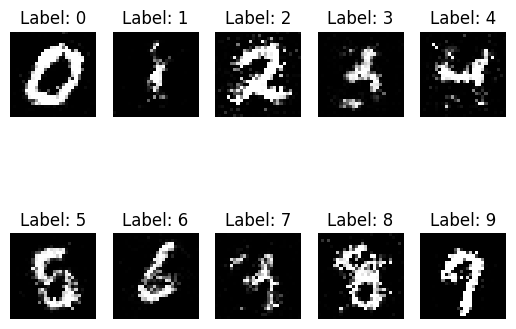

1/1 [==============================] - 0s 28ms/step
3701 [Discriminator loss: 0.682153, acc.: 54.69%] [Generator loss: 0.835575]
1/1 [==============================] - 0s 31ms/step
3702 [Discriminator loss: 0.679985, acc.: 51.56%] [Generator loss: 0.812595]
1/1 [==============================] - 0s 19ms/step
3703 [Discriminator loss: 0.679946, acc.: 54.69%] [Generator loss: 0.867055]
1/1 [==============================] - 0s 23ms/step
3704 [Discriminator loss: 0.589642, acc.: 70.31%] [Generator loss: 0.823553]
1/1 [==============================] - 0s 28ms/step
3705 [Discriminator loss: 0.710581, acc.: 48.44%] [Generator loss: 0.835239]
1/1 [==============================] - 0s 21ms/step
3706 [Discriminator loss: 0.661351, acc.: 56.25%] [Generator loss: 0.769138]
1/1 [==============================] - 0s 25ms/step
3707 [Discriminator loss: 0.647379, acc.: 57.81%] [Generator loss: 0.877056]
1/1 [==============================] - 0s 25ms/step
3708 [Discriminator loss: 0.715842, acc.: 50.

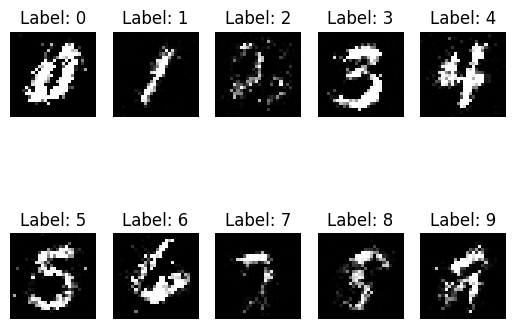

1/1 [==============================] - 0s 26ms/step
3801 [Discriminator loss: 0.624310, acc.: 64.06%] [Generator loss: 0.833110]
1/1 [==============================] - 0s 28ms/step
3802 [Discriminator loss: 0.647462, acc.: 62.50%] [Generator loss: 0.834853]
1/1 [==============================] - 0s 34ms/step
3803 [Discriminator loss: 0.650916, acc.: 65.62%] [Generator loss: 0.787623]
1/1 [==============================] - 0s 31ms/step
3804 [Discriminator loss: 0.634352, acc.: 62.50%] [Generator loss: 0.833517]
1/1 [==============================] - 0s 34ms/step
3805 [Discriminator loss: 0.690609, acc.: 53.12%] [Generator loss: 0.828374]
1/1 [==============================] - 0s 24ms/step
3806 [Discriminator loss: 0.672759, acc.: 64.06%] [Generator loss: 0.803021]
1/1 [==============================] - 0s 42ms/step
3807 [Discriminator loss: 0.661507, acc.: 59.38%] [Generator loss: 0.827634]
1/1 [==============================] - 0s 26ms/step
3808 [Discriminator loss: 0.637126, acc.: 60.

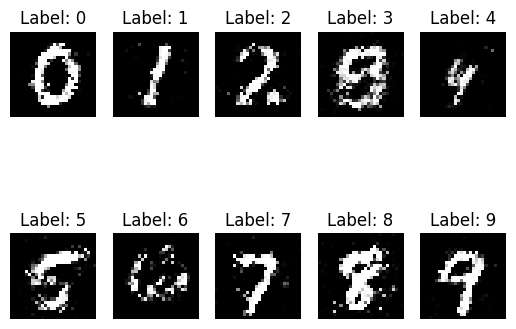

1/1 [==============================] - 0s 18ms/step
3901 [Discriminator loss: 0.722882, acc.: 43.75%] [Generator loss: 0.834282]
1/1 [==============================] - 0s 17ms/step
3902 [Discriminator loss: 0.620109, acc.: 67.19%] [Generator loss: 0.893601]
1/1 [==============================] - 0s 18ms/step
3903 [Discriminator loss: 0.664082, acc.: 57.81%] [Generator loss: 0.897587]
1/1 [==============================] - 0s 27ms/step
3904 [Discriminator loss: 0.667909, acc.: 64.06%] [Generator loss: 0.797042]
1/1 [==============================] - 0s 33ms/step
3905 [Discriminator loss: 0.706954, acc.: 54.69%] [Generator loss: 0.775336]
1/1 [==============================] - 0s 42ms/step
3906 [Discriminator loss: 0.673294, acc.: 57.81%] [Generator loss: 0.815867]
1/1 [==============================] - 0s 28ms/step
3907 [Discriminator loss: 0.647664, acc.: 60.94%] [Generator loss: 0.875017]
1/1 [==============================] - 0s 28ms/step
3908 [Discriminator loss: 0.657967, acc.: 60.

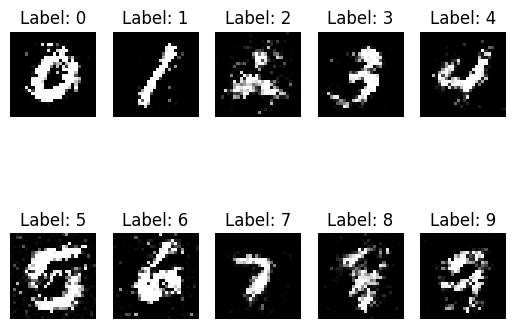

1/1 [==============================] - 0s 24ms/step
4001 [Discriminator loss: 0.642777, acc.: 64.06%] [Generator loss: 0.797876]
1/1 [==============================] - 0s 22ms/step
4002 [Discriminator loss: 0.624392, acc.: 64.06%] [Generator loss: 0.849141]
1/1 [==============================] - 0s 27ms/step
4003 [Discriminator loss: 0.659666, acc.: 57.81%] [Generator loss: 0.785968]
1/1 [==============================] - 0s 28ms/step
4004 [Discriminator loss: 0.672640, acc.: 56.25%] [Generator loss: 0.816240]
1/1 [==============================] - 0s 25ms/step
4005 [Discriminator loss: 0.671333, acc.: 54.69%] [Generator loss: 0.868601]
1/1 [==============================] - 0s 27ms/step
4006 [Discriminator loss: 0.677418, acc.: 54.69%] [Generator loss: 0.821694]
1/1 [==============================] - 0s 31ms/step
4007 [Discriminator loss: 0.699908, acc.: 48.44%] [Generator loss: 0.825944]
1/1 [==============================] - 0s 28ms/step
4008 [Discriminator loss: 0.679462, acc.: 56.

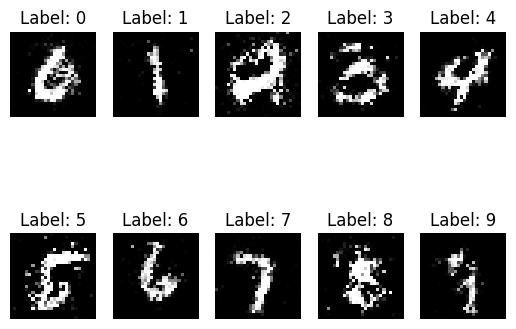

1/1 [==============================] - 0s 18ms/step
4101 [Discriminator loss: 0.680834, acc.: 53.12%] [Generator loss: 0.863448]
1/1 [==============================] - 0s 16ms/step
4102 [Discriminator loss: 0.667501, acc.: 57.81%] [Generator loss: 0.861573]
1/1 [==============================] - 0s 18ms/step
4103 [Discriminator loss: 0.656268, acc.: 59.38%] [Generator loss: 0.848490]
1/1 [==============================] - 0s 22ms/step
4104 [Discriminator loss: 0.682554, acc.: 51.56%] [Generator loss: 0.821030]
1/1 [==============================] - 0s 21ms/step
4105 [Discriminator loss: 0.693137, acc.: 53.12%] [Generator loss: 0.774516]
1/1 [==============================] - 0s 18ms/step
4106 [Discriminator loss: 0.681347, acc.: 59.38%] [Generator loss: 0.775302]
1/1 [==============================] - 0s 16ms/step
4107 [Discriminator loss: 0.642625, acc.: 64.06%] [Generator loss: 0.791431]
1/1 [==============================] - 0s 23ms/step
4108 [Discriminator loss: 0.680434, acc.: 53.

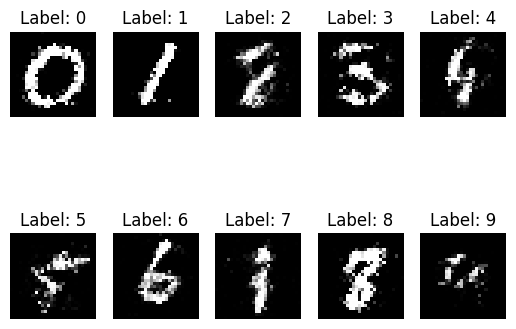

1/1 [==============================] - 0s 18ms/step
4201 [Discriminator loss: 0.678021, acc.: 62.50%] [Generator loss: 0.765108]
1/1 [==============================] - 0s 15ms/step
4202 [Discriminator loss: 0.648610, acc.: 68.75%] [Generator loss: 0.804485]
1/1 [==============================] - 0s 15ms/step
4203 [Discriminator loss: 0.641074, acc.: 62.50%] [Generator loss: 0.759063]
1/1 [==============================] - 0s 15ms/step
4204 [Discriminator loss: 0.648648, acc.: 65.62%] [Generator loss: 0.759141]
1/1 [==============================] - 0s 23ms/step
4205 [Discriminator loss: 0.688167, acc.: 57.81%] [Generator loss: 0.778384]
1/1 [==============================] - 0s 15ms/step
4206 [Discriminator loss: 0.673710, acc.: 54.69%] [Generator loss: 0.873497]
1/1 [==============================] - 0s 15ms/step
4207 [Discriminator loss: 0.738312, acc.: 48.44%] [Generator loss: 0.759491]
1/1 [==============================] - 0s 18ms/step
4208 [Discriminator loss: 0.643497, acc.: 68.

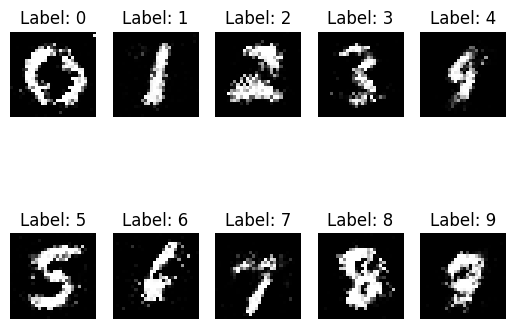

1/1 [==============================] - 0s 16ms/step
4301 [Discriminator loss: 0.678886, acc.: 64.06%] [Generator loss: 0.770958]
1/1 [==============================] - 0s 18ms/step
4302 [Discriminator loss: 0.700751, acc.: 53.12%] [Generator loss: 0.795239]
1/1 [==============================] - 0s 19ms/step
4303 [Discriminator loss: 0.630461, acc.: 60.94%] [Generator loss: 0.783078]
1/1 [==============================] - 0s 19ms/step
4304 [Discriminator loss: 0.672626, acc.: 56.25%] [Generator loss: 0.784625]
1/1 [==============================] - 0s 20ms/step
4305 [Discriminator loss: 0.681747, acc.: 56.25%] [Generator loss: 0.790635]
1/1 [==============================] - 0s 15ms/step
4306 [Discriminator loss: 0.682315, acc.: 53.12%] [Generator loss: 0.780860]
1/1 [==============================] - 0s 16ms/step
4307 [Discriminator loss: 0.679789, acc.: 53.12%] [Generator loss: 0.857991]
1/1 [==============================] - 0s 16ms/step
4308 [Discriminator loss: 0.674861, acc.: 56.

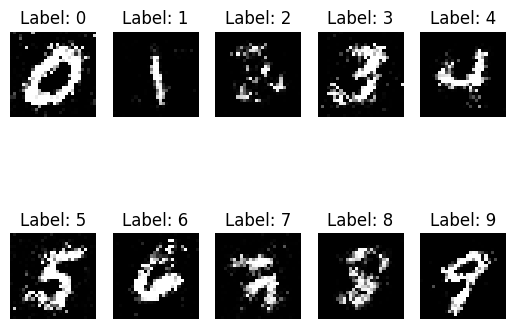

1/1 [==============================] - 0s 21ms/step
4401 [Discriminator loss: 0.680219, acc.: 60.94%] [Generator loss: 0.775069]
1/1 [==============================] - 0s 21ms/step
4402 [Discriminator loss: 0.675363, acc.: 54.69%] [Generator loss: 0.820047]
1/1 [==============================] - 0s 26ms/step
4403 [Discriminator loss: 0.675082, acc.: 57.81%] [Generator loss: 0.786623]
1/1 [==============================] - 0s 30ms/step
4404 [Discriminator loss: 0.648419, acc.: 65.62%] [Generator loss: 0.839947]
1/1 [==============================] - 0s 20ms/step
4405 [Discriminator loss: 0.639277, acc.: 65.62%] [Generator loss: 0.760817]
1/1 [==============================] - 0s 24ms/step
4406 [Discriminator loss: 0.684470, acc.: 57.81%] [Generator loss: 0.813891]
1/1 [==============================] - 0s 27ms/step
4407 [Discriminator loss: 0.673010, acc.: 53.12%] [Generator loss: 0.792840]
1/1 [==============================] - 0s 26ms/step
4408 [Discriminator loss: 0.694388, acc.: 43.

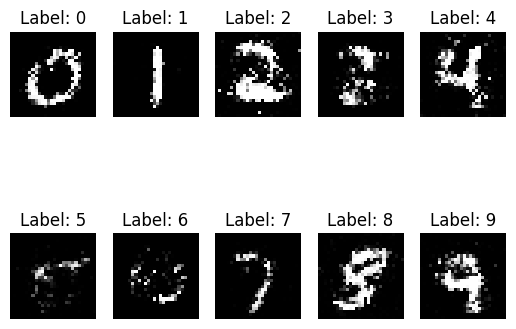

1/1 [==============================] - 0s 18ms/step
4501 [Discriminator loss: 0.644848, acc.: 56.25%] [Generator loss: 0.840513]
1/1 [==============================] - 0s 16ms/step
4502 [Discriminator loss: 0.699644, acc.: 45.31%] [Generator loss: 0.841372]
1/1 [==============================] - 0s 29ms/step
4503 [Discriminator loss: 0.671943, acc.: 56.25%] [Generator loss: 0.825719]
1/1 [==============================] - 0s 31ms/step
4504 [Discriminator loss: 0.638777, acc.: 57.81%] [Generator loss: 0.801140]
1/1 [==============================] - 0s 22ms/step
4505 [Discriminator loss: 0.679819, acc.: 59.38%] [Generator loss: 0.862710]
1/1 [==============================] - 0s 20ms/step
4506 [Discriminator loss: 0.655439, acc.: 62.50%] [Generator loss: 0.804066]
1/1 [==============================] - 0s 26ms/step
4507 [Discriminator loss: 0.662863, acc.: 54.69%] [Generator loss: 0.813582]
1/1 [==============================] - 0s 21ms/step
4508 [Discriminator loss: 0.689009, acc.: 53.

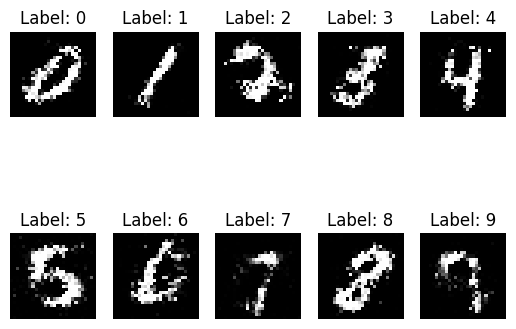

1/1 [==============================] - 0s 17ms/step
4601 [Discriminator loss: 0.717629, acc.: 46.88%] [Generator loss: 0.803451]
1/1 [==============================] - 0s 15ms/step
4602 [Discriminator loss: 0.690442, acc.: 48.44%] [Generator loss: 0.796971]
1/1 [==============================] - 0s 15ms/step
4603 [Discriminator loss: 0.687769, acc.: 56.25%] [Generator loss: 0.772083]
1/1 [==============================] - 0s 16ms/step
4604 [Discriminator loss: 0.685679, acc.: 56.25%] [Generator loss: 0.792698]
1/1 [==============================] - 0s 26ms/step
4605 [Discriminator loss: 0.654857, acc.: 65.62%] [Generator loss: 0.746985]
1/1 [==============================] - 0s 21ms/step
4606 [Discriminator loss: 0.687767, acc.: 60.94%] [Generator loss: 0.784208]
1/1 [==============================] - 0s 23ms/step
4607 [Discriminator loss: 0.675013, acc.: 51.56%] [Generator loss: 0.780948]
1/1 [==============================] - 0s 26ms/step
4608 [Discriminator loss: 0.648649, acc.: 57.

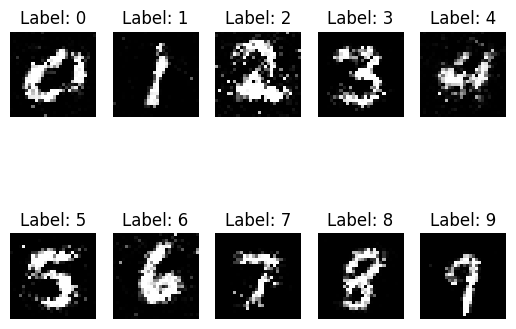

1/1 [==============================] - 0s 26ms/step
4701 [Discriminator loss: 0.685167, acc.: 60.94%] [Generator loss: 0.780659]
1/1 [==============================] - 0s 27ms/step
4702 [Discriminator loss: 0.692612, acc.: 54.69%] [Generator loss: 0.799977]
1/1 [==============================] - 0s 25ms/step
4703 [Discriminator loss: 0.668249, acc.: 53.12%] [Generator loss: 0.818725]
1/1 [==============================] - 0s 28ms/step
4704 [Discriminator loss: 0.638695, acc.: 62.50%] [Generator loss: 0.851130]
1/1 [==============================] - 0s 41ms/step
4705 [Discriminator loss: 0.676857, acc.: 54.69%] [Generator loss: 0.799551]
1/1 [==============================] - 0s 26ms/step
4706 [Discriminator loss: 0.705226, acc.: 53.12%] [Generator loss: 0.733108]
1/1 [==============================] - 0s 34ms/step
4707 [Discriminator loss: 0.643300, acc.: 59.38%] [Generator loss: 0.780604]
1/1 [==============================] - 0s 24ms/step
4708 [Discriminator loss: 0.665549, acc.: 56.

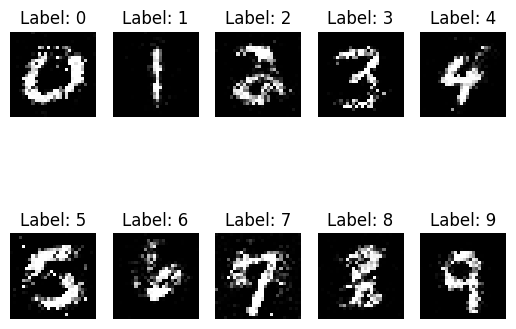

1/1 [==============================] - 0s 26ms/step
4801 [Discriminator loss: 0.725740, acc.: 46.88%] [Generator loss: 0.839364]
1/1 [==============================] - 0s 24ms/step
4802 [Discriminator loss: 0.698888, acc.: 57.81%] [Generator loss: 0.837997]
1/1 [==============================] - 0s 32ms/step
4803 [Discriminator loss: 0.660260, acc.: 68.75%] [Generator loss: 0.839037]
1/1 [==============================] - 0s 25ms/step
4804 [Discriminator loss: 0.668993, acc.: 56.25%] [Generator loss: 0.846537]
1/1 [==============================] - 0s 45ms/step
4805 [Discriminator loss: 0.645983, acc.: 60.94%] [Generator loss: 0.812217]
1/1 [==============================] - 0s 33ms/step
4806 [Discriminator loss: 0.694832, acc.: 50.00%] [Generator loss: 0.797598]
1/1 [==============================] - 0s 32ms/step
4807 [Discriminator loss: 0.699761, acc.: 48.44%] [Generator loss: 0.770671]
1/1 [==============================] - 0s 24ms/step
4808 [Discriminator loss: 0.686460, acc.: 48.

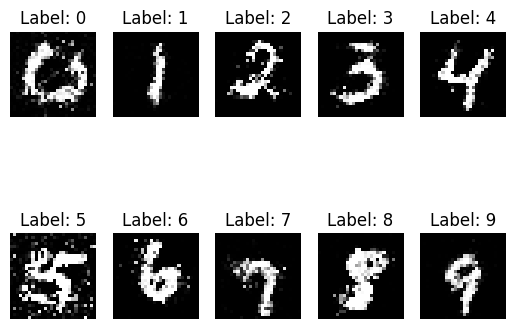

1/1 [==============================] - 0s 17ms/step
4901 [Discriminator loss: 0.669127, acc.: 56.25%] [Generator loss: 0.782541]
1/1 [==============================] - 0s 16ms/step
4902 [Discriminator loss: 0.682036, acc.: 53.12%] [Generator loss: 0.835793]
1/1 [==============================] - 0s 28ms/step
4903 [Discriminator loss: 0.669922, acc.: 50.00%] [Generator loss: 0.763218]
1/1 [==============================] - 0s 35ms/step
4904 [Discriminator loss: 0.691530, acc.: 57.81%] [Generator loss: 0.846003]
1/1 [==============================] - 0s 29ms/step
4905 [Discriminator loss: 0.702716, acc.: 54.69%] [Generator loss: 0.821653]
1/1 [==============================] - 0s 44ms/step
4906 [Discriminator loss: 0.731181, acc.: 48.44%] [Generator loss: 0.846033]
1/1 [==============================] - 0s 28ms/step
4907 [Discriminator loss: 0.708878, acc.: 50.00%] [Generator loss: 0.850629]
1/1 [==============================] - 0s 28ms/step
4908 [Discriminator loss: 0.707407, acc.: 53.

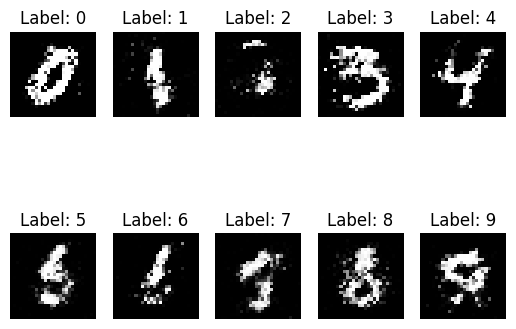

1/1 [==============================] - 0s 26ms/step
5001 [Discriminator loss: 0.641452, acc.: 59.38%] [Generator loss: 0.793856]
1/1 [==============================] - 0s 23ms/step
5002 [Discriminator loss: 0.661261, acc.: 60.94%] [Generator loss: 0.739182]
1/1 [==============================] - 0s 39ms/step
5003 [Discriminator loss: 0.689158, acc.: 60.94%] [Generator loss: 0.776696]
1/1 [==============================] - 0s 41ms/step
5004 [Discriminator loss: 0.668733, acc.: 59.38%] [Generator loss: 0.772143]
1/1 [==============================] - 0s 34ms/step
5005 [Discriminator loss: 0.684170, acc.: 50.00%] [Generator loss: 0.773984]
1/1 [==============================] - 0s 36ms/step
5006 [Discriminator loss: 0.675213, acc.: 59.38%] [Generator loss: 0.774425]
1/1 [==============================] - 0s 41ms/step
5007 [Discriminator loss: 0.700497, acc.: 50.00%] [Generator loss: 0.736311]
1/1 [==============================] - 0s 39ms/step
5008 [Discriminator loss: 0.683046, acc.: 57.

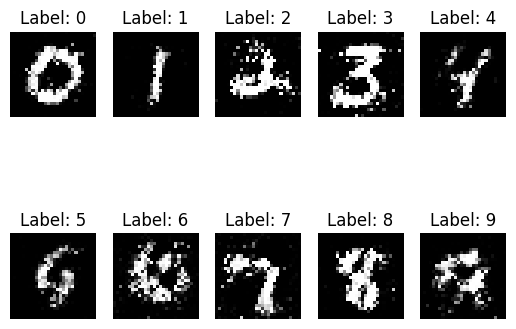

1/1 [==============================] - 0s 23ms/step
5101 [Discriminator loss: 0.703810, acc.: 51.56%] [Generator loss: 0.746273]
1/1 [==============================] - 0s 20ms/step
5102 [Discriminator loss: 0.665452, acc.: 59.38%] [Generator loss: 0.749766]
1/1 [==============================] - 0s 36ms/step
5103 [Discriminator loss: 0.694533, acc.: 54.69%] [Generator loss: 0.793487]
1/1 [==============================] - 0s 20ms/step
5104 [Discriminator loss: 0.688733, acc.: 56.25%] [Generator loss: 0.824524]
1/1 [==============================] - 0s 27ms/step
5105 [Discriminator loss: 0.652959, acc.: 56.25%] [Generator loss: 0.791194]
1/1 [==============================] - 0s 21ms/step
5106 [Discriminator loss: 0.687064, acc.: 50.00%] [Generator loss: 0.791892]
1/1 [==============================] - 0s 31ms/step
5107 [Discriminator loss: 0.646077, acc.: 60.94%] [Generator loss: 0.796786]
1/1 [==============================] - 0s 26ms/step
5108 [Discriminator loss: 0.662614, acc.: 51.

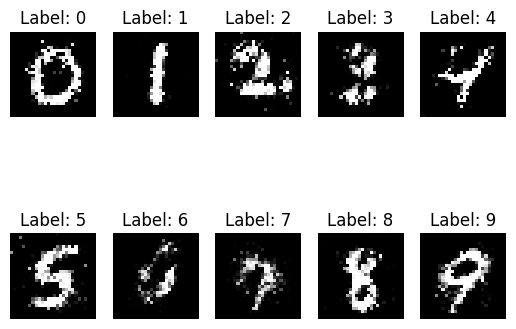

1/1 [==============================] - 0s 16ms/step
5201 [Discriminator loss: 0.737448, acc.: 50.00%] [Generator loss: 0.794186]
1/1 [==============================] - 0s 23ms/step
5202 [Discriminator loss: 0.686263, acc.: 48.44%] [Generator loss: 0.845990]
1/1 [==============================] - 0s 21ms/step
5203 [Discriminator loss: 0.693853, acc.: 59.38%] [Generator loss: 0.825294]
1/1 [==============================] - 0s 29ms/step
5204 [Discriminator loss: 0.680109, acc.: 53.12%] [Generator loss: 0.835065]
1/1 [==============================] - 0s 25ms/step
5205 [Discriminator loss: 0.689291, acc.: 50.00%] [Generator loss: 0.810288]
1/1 [==============================] - 0s 20ms/step
5206 [Discriminator loss: 0.704427, acc.: 50.00%] [Generator loss: 0.823242]
1/1 [==============================] - 0s 21ms/step
5207 [Discriminator loss: 0.645803, acc.: 70.31%] [Generator loss: 0.823825]
1/1 [==============================] - 0s 17ms/step
5208 [Discriminator loss: 0.695115, acc.: 48.

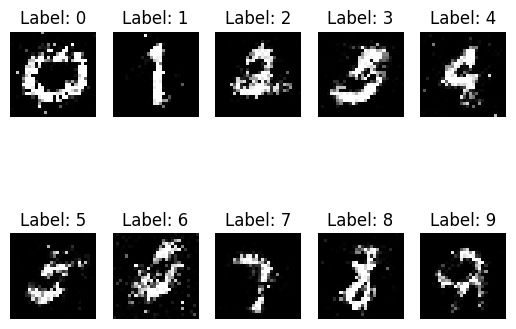

1/1 [==============================] - 0s 20ms/step
5301 [Discriminator loss: 0.701913, acc.: 50.00%] [Generator loss: 0.765135]
1/1 [==============================] - 0s 16ms/step
5302 [Discriminator loss: 0.694397, acc.: 48.44%] [Generator loss: 0.818496]
1/1 [==============================] - 0s 19ms/step
5303 [Discriminator loss: 0.652243, acc.: 54.69%] [Generator loss: 0.813761]
1/1 [==============================] - 0s 20ms/step
5304 [Discriminator loss: 0.697357, acc.: 54.69%] [Generator loss: 0.785093]
1/1 [==============================] - 0s 20ms/step
5305 [Discriminator loss: 0.683311, acc.: 51.56%] [Generator loss: 0.777101]
1/1 [==============================] - 0s 19ms/step
5306 [Discriminator loss: 0.649915, acc.: 64.06%] [Generator loss: 0.781833]
1/1 [==============================] - 0s 16ms/step
5307 [Discriminator loss: 0.671154, acc.: 56.25%] [Generator loss: 0.839656]
1/1 [==============================] - 0s 20ms/step
5308 [Discriminator loss: 0.674841, acc.: 54.

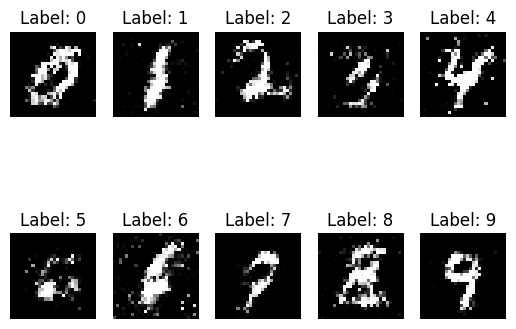

1/1 [==============================] - 0s 17ms/step
5401 [Discriminator loss: 0.646432, acc.: 62.50%] [Generator loss: 0.748992]
1/1 [==============================] - 0s 15ms/step
5402 [Discriminator loss: 0.699895, acc.: 50.00%] [Generator loss: 0.770251]
1/1 [==============================] - 0s 19ms/step
5403 [Discriminator loss: 0.683967, acc.: 64.06%] [Generator loss: 0.798619]
1/1 [==============================] - 0s 21ms/step
5404 [Discriminator loss: 0.628322, acc.: 67.19%] [Generator loss: 0.732912]
1/1 [==============================] - 0s 27ms/step
5405 [Discriminator loss: 0.668341, acc.: 51.56%] [Generator loss: 0.804595]
1/1 [==============================] - 0s 23ms/step
5406 [Discriminator loss: 0.663027, acc.: 60.94%] [Generator loss: 0.792476]
1/1 [==============================] - 0s 19ms/step
5407 [Discriminator loss: 0.673750, acc.: 60.94%] [Generator loss: 0.737807]
1/1 [==============================] - 0s 30ms/step
5408 [Discriminator loss: 0.679201, acc.: 54.

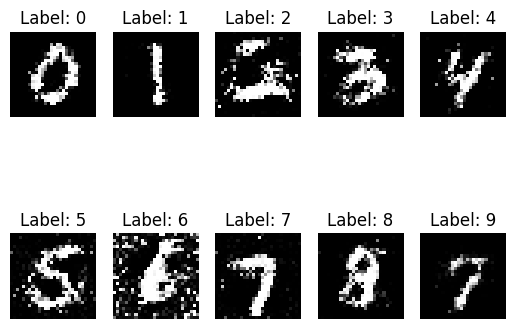

1/1 [==============================] - 0s 20ms/step
5501 [Discriminator loss: 0.674216, acc.: 54.69%] [Generator loss: 0.768776]
1/1 [==============================] - 0s 19ms/step
5502 [Discriminator loss: 0.686879, acc.: 54.69%] [Generator loss: 0.792363]
1/1 [==============================] - 0s 28ms/step
5503 [Discriminator loss: 0.654265, acc.: 67.19%] [Generator loss: 0.771565]
1/1 [==============================] - 0s 21ms/step
5504 [Discriminator loss: 0.673204, acc.: 56.25%] [Generator loss: 0.775985]
1/1 [==============================] - 0s 19ms/step
5505 [Discriminator loss: 0.669970, acc.: 53.12%] [Generator loss: 0.748188]
1/1 [==============================] - 0s 25ms/step
5506 [Discriminator loss: 0.682267, acc.: 64.06%] [Generator loss: 0.778431]
1/1 [==============================] - 0s 19ms/step
5507 [Discriminator loss: 0.685576, acc.: 54.69%] [Generator loss: 0.688091]
1/1 [==============================] - 0s 26ms/step
5508 [Discriminator loss: 0.635134, acc.: 53.

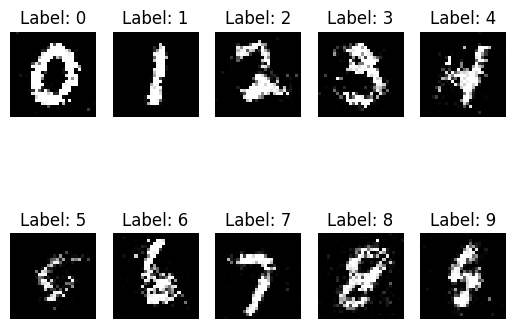

1/1 [==============================] - 0s 18ms/step
5601 [Discriminator loss: 0.648379, acc.: 62.50%] [Generator loss: 0.811865]
1/1 [==============================] - 0s 16ms/step
5602 [Discriminator loss: 0.633119, acc.: 64.06%] [Generator loss: 0.842480]
1/1 [==============================] - 0s 21ms/step
5603 [Discriminator loss: 0.668980, acc.: 57.81%] [Generator loss: 0.819672]
1/1 [==============================] - 0s 26ms/step
5604 [Discriminator loss: 0.641016, acc.: 57.81%] [Generator loss: 0.823083]
1/1 [==============================] - 0s 24ms/step
5605 [Discriminator loss: 0.618197, acc.: 70.31%] [Generator loss: 0.838383]
1/1 [==============================] - 0s 25ms/step
5606 [Discriminator loss: 0.650556, acc.: 62.50%] [Generator loss: 0.825357]
1/1 [==============================] - 0s 25ms/step
5607 [Discriminator loss: 0.675815, acc.: 57.81%] [Generator loss: 0.868356]
1/1 [==============================] - 0s 32ms/step
5608 [Discriminator loss: 0.670119, acc.: 54.

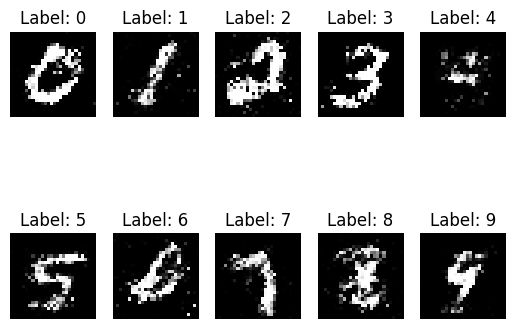

1/1 [==============================] - 0s 16ms/step
5701 [Discriminator loss: 0.708971, acc.: 45.31%] [Generator loss: 0.836947]
1/1 [==============================] - 0s 17ms/step
5702 [Discriminator loss: 0.695336, acc.: 54.69%] [Generator loss: 0.827013]
1/1 [==============================] - 0s 16ms/step
5703 [Discriminator loss: 0.690758, acc.: 50.00%] [Generator loss: 0.774192]
1/1 [==============================] - 0s 17ms/step
5704 [Discriminator loss: 0.666479, acc.: 65.62%] [Generator loss: 0.778358]
1/1 [==============================] - 0s 21ms/step
5705 [Discriminator loss: 0.670031, acc.: 57.81%] [Generator loss: 0.806434]
1/1 [==============================] - 0s 30ms/step
5706 [Discriminator loss: 0.663488, acc.: 57.81%] [Generator loss: 0.841233]
1/1 [==============================] - 0s 24ms/step
5707 [Discriminator loss: 0.669436, acc.: 59.38%] [Generator loss: 0.812401]
1/1 [==============================] - 0s 15ms/step
5708 [Discriminator loss: 0.664574, acc.: 57.

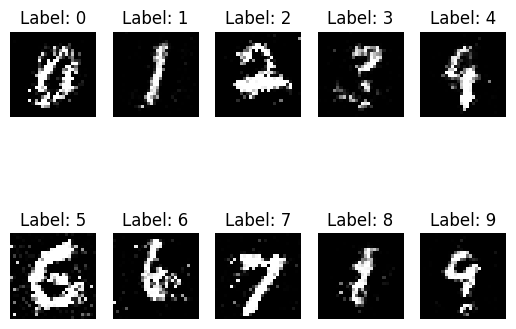

1/1 [==============================] - 0s 17ms/step
5801 [Discriminator loss: 0.675566, acc.: 51.56%] [Generator loss: 0.721387]
1/1 [==============================] - 0s 16ms/step
5802 [Discriminator loss: 0.727253, acc.: 51.56%] [Generator loss: 0.757737]
1/1 [==============================] - 0s 21ms/step
5803 [Discriminator loss: 0.686898, acc.: 51.56%] [Generator loss: 0.727886]
1/1 [==============================] - 0s 23ms/step
5804 [Discriminator loss: 0.670994, acc.: 54.69%] [Generator loss: 0.822514]
1/1 [==============================] - 0s 29ms/step
5805 [Discriminator loss: 0.686524, acc.: 59.38%] [Generator loss: 0.835671]
1/1 [==============================] - 0s 23ms/step
5806 [Discriminator loss: 0.679414, acc.: 51.56%] [Generator loss: 0.808049]
1/1 [==============================] - 0s 28ms/step
5807 [Discriminator loss: 0.683560, acc.: 56.25%] [Generator loss: 0.794746]
1/1 [==============================] - 0s 24ms/step
5808 [Discriminator loss: 0.673805, acc.: 57.

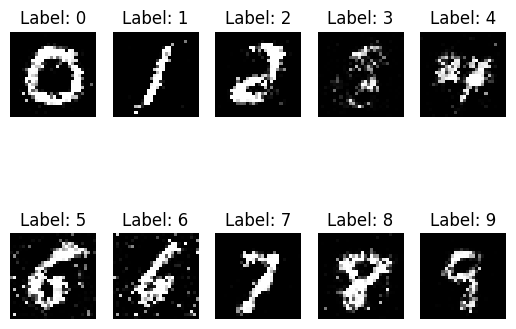

1/1 [==============================] - 0s 18ms/step
5901 [Discriminator loss: 0.705223, acc.: 46.88%] [Generator loss: 0.867051]
1/1 [==============================] - 0s 21ms/step
5902 [Discriminator loss: 0.682509, acc.: 59.38%] [Generator loss: 0.799030]
1/1 [==============================] - 0s 30ms/step
5903 [Discriminator loss: 0.696216, acc.: 51.56%] [Generator loss: 0.800055]
1/1 [==============================] - 0s 23ms/step
5904 [Discriminator loss: 0.629371, acc.: 62.50%] [Generator loss: 0.829827]
1/1 [==============================] - 0s 22ms/step
5905 [Discriminator loss: 0.681879, acc.: 59.38%] [Generator loss: 0.842362]
1/1 [==============================] - 0s 22ms/step
5906 [Discriminator loss: 0.592639, acc.: 67.19%] [Generator loss: 0.814748]
1/1 [==============================] - 0s 23ms/step
5907 [Discriminator loss: 0.680273, acc.: 54.69%] [Generator loss: 0.804246]
1/1 [==============================] - 0s 25ms/step
5908 [Discriminator loss: 0.680055, acc.: 48.

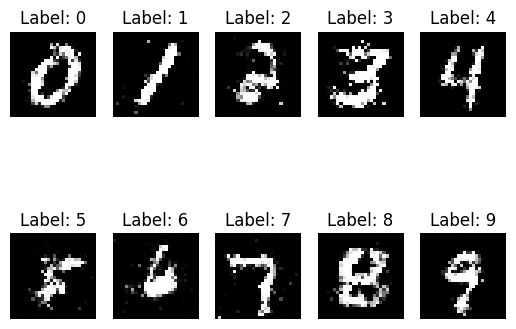

1/1 [==============================] - 0s 17ms/step
6001 [Discriminator loss: 0.735785, acc.: 45.31%] [Generator loss: 0.761516]
1/1 [==============================] - 0s 16ms/step
6002 [Discriminator loss: 0.680790, acc.: 56.25%] [Generator loss: 0.826694]
1/1 [==============================] - 0s 21ms/step
6003 [Discriminator loss: 0.688670, acc.: 53.12%] [Generator loss: 0.809817]
1/1 [==============================] - 0s 33ms/step
6004 [Discriminator loss: 0.659409, acc.: 60.94%] [Generator loss: 0.808539]
1/1 [==============================] - 0s 17ms/step
6005 [Discriminator loss: 0.675771, acc.: 60.94%] [Generator loss: 0.801259]
1/1 [==============================] - 0s 17ms/step
6006 [Discriminator loss: 0.686242, acc.: 54.69%] [Generator loss: 0.803466]
1/1 [==============================] - 0s 23ms/step
6007 [Discriminator loss: 0.697162, acc.: 51.56%] [Generator loss: 0.775059]
1/1 [==============================] - 0s 24ms/step
6008 [Discriminator loss: 0.665455, acc.: 56.

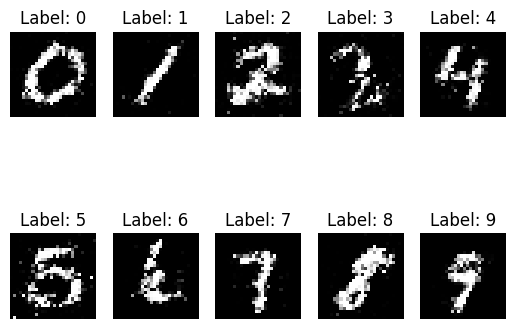

1/1 [==============================] - 0s 25ms/step
6101 [Discriminator loss: 0.698050, acc.: 50.00%] [Generator loss: 0.843505]
1/1 [==============================] - 0s 23ms/step
6102 [Discriminator loss: 0.686960, acc.: 51.56%] [Generator loss: 0.784885]
1/1 [==============================] - 0s 35ms/step
6103 [Discriminator loss: 0.633643, acc.: 65.62%] [Generator loss: 0.808534]
1/1 [==============================] - 0s 32ms/step
6104 [Discriminator loss: 0.660942, acc.: 59.38%] [Generator loss: 0.776278]
1/1 [==============================] - 0s 24ms/step
6105 [Discriminator loss: 0.751415, acc.: 45.31%] [Generator loss: 0.773688]
1/1 [==============================] - 0s 17ms/step
6106 [Discriminator loss: 0.684633, acc.: 62.50%] [Generator loss: 0.828517]
1/1 [==============================] - 0s 31ms/step
6107 [Discriminator loss: 0.693620, acc.: 50.00%] [Generator loss: 0.812927]
1/1 [==============================] - 0s 26ms/step
6108 [Discriminator loss: 0.696167, acc.: 56.

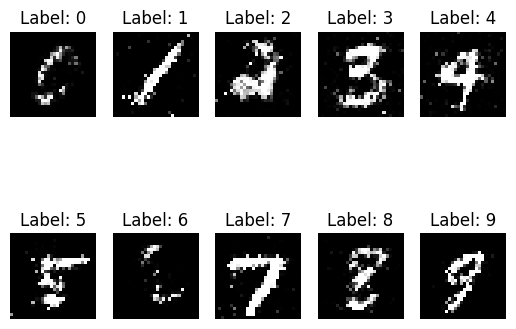

1/1 [==============================] - 0s 33ms/step
6201 [Discriminator loss: 0.664453, acc.: 54.69%] [Generator loss: 0.865733]
1/1 [==============================] - 0s 27ms/step
6202 [Discriminator loss: 0.644041, acc.: 57.81%] [Generator loss: 0.817835]
1/1 [==============================] - 0s 40ms/step
6203 [Discriminator loss: 0.662834, acc.: 57.81%] [Generator loss: 0.790103]
1/1 [==============================] - 0s 46ms/step
6204 [Discriminator loss: 0.669427, acc.: 57.81%] [Generator loss: 0.779207]
1/1 [==============================] - 0s 50ms/step
6205 [Discriminator loss: 0.655324, acc.: 60.94%] [Generator loss: 0.759316]
1/1 [==============================] - 0s 30ms/step
6206 [Discriminator loss: 0.712434, acc.: 54.69%] [Generator loss: 0.826841]
1/1 [==============================] - 0s 40ms/step
6207 [Discriminator loss: 0.672311, acc.: 57.81%] [Generator loss: 0.775626]
1/1 [==============================] - 0s 30ms/step
6208 [Discriminator loss: 0.673040, acc.: 53.

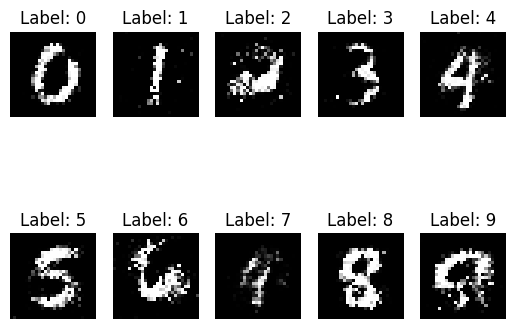

1/1 [==============================] - 0s 25ms/step
6301 [Discriminator loss: 0.685192, acc.: 50.00%] [Generator loss: 0.859589]
1/1 [==============================] - 0s 34ms/step
6302 [Discriminator loss: 0.658383, acc.: 53.12%] [Generator loss: 0.822349]
1/1 [==============================] - 0s 29ms/step
6303 [Discriminator loss: 0.672229, acc.: 57.81%] [Generator loss: 0.807679]
1/1 [==============================] - 0s 42ms/step
6304 [Discriminator loss: 0.670509, acc.: 56.25%] [Generator loss: 0.835661]
1/1 [==============================] - 0s 44ms/step
6305 [Discriminator loss: 0.683759, acc.: 51.56%] [Generator loss: 0.779302]
1/1 [==============================] - 0s 43ms/step
6306 [Discriminator loss: 0.646291, acc.: 57.81%] [Generator loss: 0.825590]
1/1 [==============================] - 0s 26ms/step
6307 [Discriminator loss: 0.615050, acc.: 67.19%] [Generator loss: 0.825804]
1/1 [==============================] - 0s 26ms/step
6308 [Discriminator loss: 0.641990, acc.: 59.

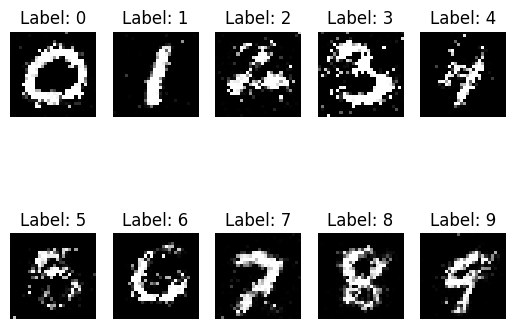

1/1 [==============================] - 0s 25ms/step
6401 [Discriminator loss: 0.667069, acc.: 60.94%] [Generator loss: 0.739605]
1/1 [==============================] - 0s 29ms/step
6402 [Discriminator loss: 0.729607, acc.: 50.00%] [Generator loss: 0.854109]
1/1 [==============================] - 0s 28ms/step
6403 [Discriminator loss: 0.643531, acc.: 59.38%] [Generator loss: 0.790215]
1/1 [==============================] - 0s 29ms/step
6404 [Discriminator loss: 0.672113, acc.: 59.38%] [Generator loss: 0.803000]
1/1 [==============================] - 0s 30ms/step
6405 [Discriminator loss: 0.673729, acc.: 59.38%] [Generator loss: 0.794425]
1/1 [==============================] - 0s 29ms/step
6406 [Discriminator loss: 0.677976, acc.: 50.00%] [Generator loss: 0.786027]
1/1 [==============================] - 0s 29ms/step
6407 [Discriminator loss: 0.703822, acc.: 51.56%] [Generator loss: 0.801825]
1/1 [==============================] - 0s 42ms/step
6408 [Discriminator loss: 0.675603, acc.: 59.

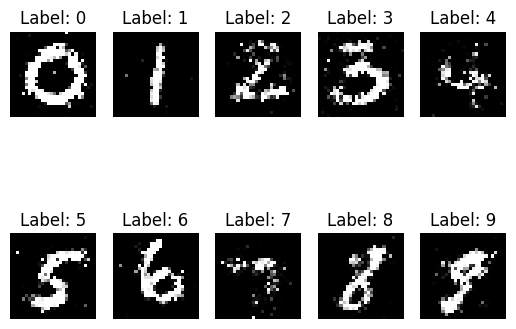

1/1 [==============================] - 0s 28ms/step
6501 [Discriminator loss: 0.665776, acc.: 65.62%] [Generator loss: 0.811884]
1/1 [==============================] - 0s 42ms/step
6502 [Discriminator loss: 0.670298, acc.: 54.69%] [Generator loss: 0.789841]
1/1 [==============================] - 0s 26ms/step
6503 [Discriminator loss: 0.676450, acc.: 57.81%] [Generator loss: 0.722091]
1/1 [==============================] - 0s 38ms/step
6504 [Discriminator loss: 0.679382, acc.: 60.94%] [Generator loss: 0.764814]
1/1 [==============================] - 0s 39ms/step
6505 [Discriminator loss: 0.704564, acc.: 51.56%] [Generator loss: 0.768984]
1/1 [==============================] - 0s 37ms/step
6506 [Discriminator loss: 0.664354, acc.: 65.62%] [Generator loss: 0.835536]
1/1 [==============================] - 0s 35ms/step
6507 [Discriminator loss: 0.651517, acc.: 62.50%] [Generator loss: 0.817904]
1/1 [==============================] - 0s 45ms/step
6508 [Discriminator loss: 0.682770, acc.: 53.

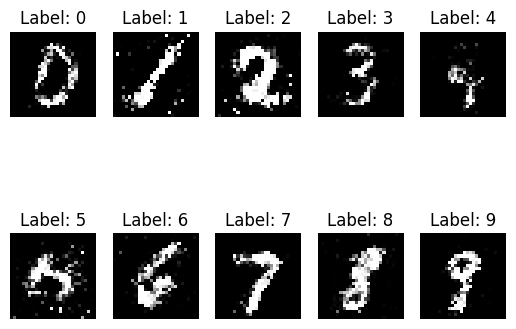

1/1 [==============================] - 0s 29ms/step
6601 [Discriminator loss: 0.621621, acc.: 64.06%] [Generator loss: 0.805676]
1/1 [==============================] - 0s 30ms/step
6602 [Discriminator loss: 0.645822, acc.: 60.94%] [Generator loss: 0.791772]
1/1 [==============================] - 0s 47ms/step
6603 [Discriminator loss: 0.682239, acc.: 54.69%] [Generator loss: 0.798411]
1/1 [==============================] - 0s 60ms/step
6604 [Discriminator loss: 0.662597, acc.: 53.12%] [Generator loss: 0.778090]
1/1 [==============================] - 0s 32ms/step
6605 [Discriminator loss: 0.665664, acc.: 60.94%] [Generator loss: 0.810824]
1/1 [==============================] - 0s 40ms/step
6606 [Discriminator loss: 0.669655, acc.: 62.50%] [Generator loss: 0.781239]
1/1 [==============================] - 0s 45ms/step
6607 [Discriminator loss: 0.670829, acc.: 56.25%] [Generator loss: 0.787501]
1/1 [==============================] - 0s 43ms/step
6608 [Discriminator loss: 0.705354, acc.: 51.

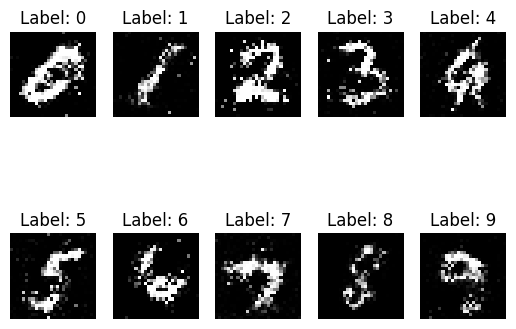

1/1 [==============================] - 0s 24ms/step
6701 [Discriminator loss: 0.647323, acc.: 65.62%] [Generator loss: 0.847268]
1/1 [==============================] - 0s 25ms/step
6702 [Discriminator loss: 0.663894, acc.: 65.62%] [Generator loss: 0.792623]
1/1 [==============================] - 0s 42ms/step
6703 [Discriminator loss: 0.674876, acc.: 57.81%] [Generator loss: 0.802305]
1/1 [==============================] - 0s 44ms/step
6704 [Discriminator loss: 0.649088, acc.: 62.50%] [Generator loss: 0.797784]
1/1 [==============================] - 0s 41ms/step
6705 [Discriminator loss: 0.642427, acc.: 56.25%] [Generator loss: 0.886517]
1/1 [==============================] - 0s 24ms/step
6706 [Discriminator loss: 0.621994, acc.: 59.38%] [Generator loss: 0.776902]
1/1 [==============================] - 0s 25ms/step
6707 [Discriminator loss: 0.671835, acc.: 57.81%] [Generator loss: 0.847554]
1/1 [==============================] - 0s 42ms/step
6708 [Discriminator loss: 0.683094, acc.: 51.

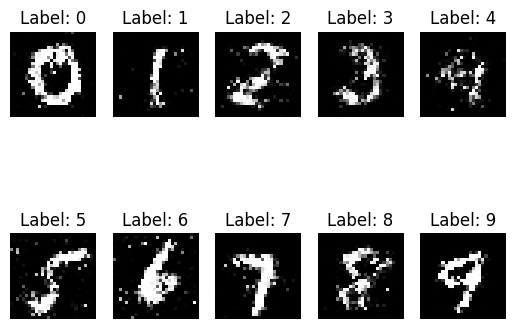

1/1 [==============================] - 0s 29ms/step
6801 [Discriminator loss: 0.659075, acc.: 59.38%] [Generator loss: 0.879363]
1/1 [==============================] - 0s 32ms/step
6802 [Discriminator loss: 0.711217, acc.: 51.56%] [Generator loss: 0.865369]
1/1 [==============================] - 0s 32ms/step
6803 [Discriminator loss: 0.664147, acc.: 54.69%] [Generator loss: 0.790274]
1/1 [==============================] - 0s 30ms/step
6804 [Discriminator loss: 0.719363, acc.: 57.81%] [Generator loss: 0.815243]
1/1 [==============================] - 0s 53ms/step
6805 [Discriminator loss: 0.672544, acc.: 57.81%] [Generator loss: 0.824845]
1/1 [==============================] - 0s 28ms/step
6806 [Discriminator loss: 0.689513, acc.: 51.56%] [Generator loss: 0.833158]
1/1 [==============================] - 0s 25ms/step
6807 [Discriminator loss: 0.720501, acc.: 50.00%] [Generator loss: 0.789468]
1/1 [==============================] - 0s 30ms/step
6808 [Discriminator loss: 0.670625, acc.: 60.

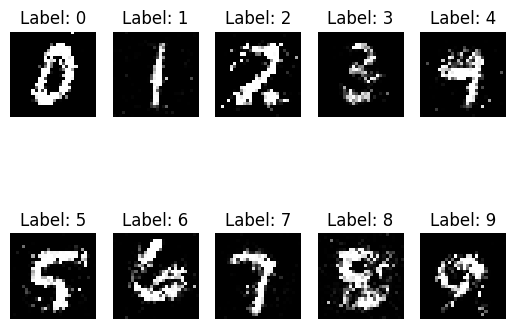

1/1 [==============================] - 0s 19ms/step
6901 [Discriminator loss: 0.669637, acc.: 56.25%] [Generator loss: 0.847397]
1/1 [==============================] - 0s 16ms/step
6902 [Discriminator loss: 0.647298, acc.: 56.25%] [Generator loss: 0.822679]
1/1 [==============================] - 0s 38ms/step
6903 [Discriminator loss: 0.658205, acc.: 57.81%] [Generator loss: 0.831486]
1/1 [==============================] - 0s 26ms/step
6904 [Discriminator loss: 0.647428, acc.: 67.19%] [Generator loss: 0.847618]
1/1 [==============================] - 0s 43ms/step
6905 [Discriminator loss: 0.707547, acc.: 62.50%] [Generator loss: 0.787384]
1/1 [==============================] - 0s 30ms/step
6906 [Discriminator loss: 0.629793, acc.: 57.81%] [Generator loss: 0.838460]
1/1 [==============================] - 0s 25ms/step
6907 [Discriminator loss: 0.699688, acc.: 45.31%] [Generator loss: 0.838895]
1/1 [==============================] - 0s 37ms/step
6908 [Discriminator loss: 0.679815, acc.: 54.

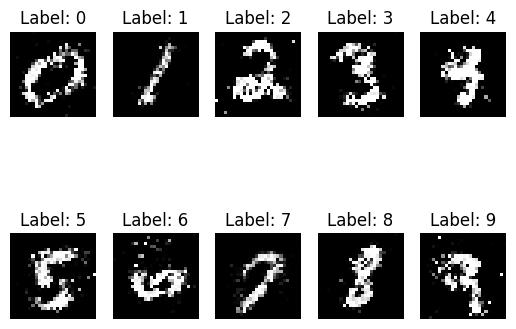

1/1 [==============================] - 0s 38ms/step
7001 [Discriminator loss: 0.651183, acc.: 56.25%] [Generator loss: 0.818529]
1/1 [==============================] - 0s 29ms/step
7002 [Discriminator loss: 0.685549, acc.: 57.81%] [Generator loss: 0.797951]
1/1 [==============================] - 0s 43ms/step
7003 [Discriminator loss: 0.604241, acc.: 68.75%] [Generator loss: 0.797895]
1/1 [==============================] - 0s 32ms/step
7004 [Discriminator loss: 0.672886, acc.: 54.69%] [Generator loss: 0.737773]
1/1 [==============================] - 0s 37ms/step
7005 [Discriminator loss: 0.626119, acc.: 56.25%] [Generator loss: 0.840655]
1/1 [==============================] - 0s 44ms/step
7006 [Discriminator loss: 0.665892, acc.: 59.38%] [Generator loss: 0.814216]
1/1 [==============================] - 0s 37ms/step
7007 [Discriminator loss: 0.646231, acc.: 60.94%] [Generator loss: 0.825580]
1/1 [==============================] - 0s 31ms/step
7008 [Discriminator loss: 0.666553, acc.: 56.

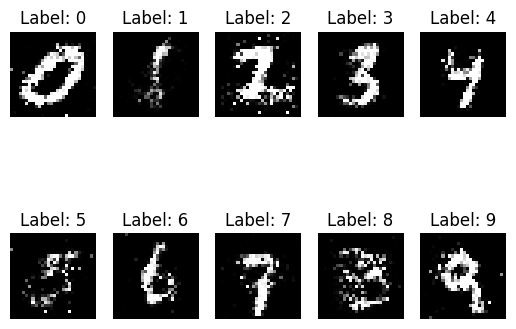

1/1 [==============================] - 0s 32ms/step
7101 [Discriminator loss: 0.673621, acc.: 62.50%] [Generator loss: 0.921534]
1/1 [==============================] - 0s 24ms/step
7102 [Discriminator loss: 0.652271, acc.: 54.69%] [Generator loss: 0.823011]
1/1 [==============================] - 0s 47ms/step
7103 [Discriminator loss: 0.678485, acc.: 56.25%] [Generator loss: 0.895014]
1/1 [==============================] - 0s 58ms/step
7104 [Discriminator loss: 0.695785, acc.: 54.69%] [Generator loss: 0.824855]
1/1 [==============================] - 0s 37ms/step
7105 [Discriminator loss: 0.652510, acc.: 54.69%] [Generator loss: 0.859849]
1/1 [==============================] - 0s 34ms/step
7106 [Discriminator loss: 0.695269, acc.: 48.44%] [Generator loss: 0.909596]
1/1 [==============================] - 0s 52ms/step
7107 [Discriminator loss: 0.686693, acc.: 51.56%] [Generator loss: 0.827314]
1/1 [==============================] - 0s 24ms/step
7108 [Discriminator loss: 0.650270, acc.: 59.

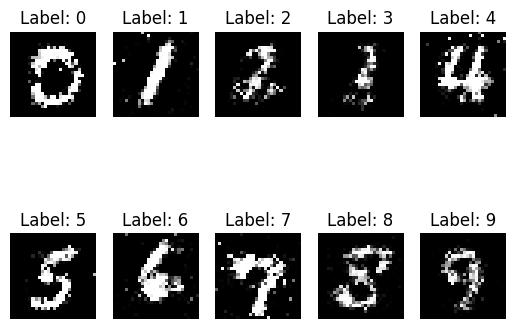

1/1 [==============================] - 0s 28ms/step
7201 [Discriminator loss: 0.675102, acc.: 51.56%] [Generator loss: 0.803926]
1/1 [==============================] - 0s 29ms/step
7202 [Discriminator loss: 0.669658, acc.: 56.25%] [Generator loss: 0.732737]
1/1 [==============================] - 0s 55ms/step
7203 [Discriminator loss: 0.670731, acc.: 54.69%] [Generator loss: 0.723121]
1/1 [==============================] - 0s 46ms/step
7204 [Discriminator loss: 0.665846, acc.: 67.19%] [Generator loss: 0.799780]
1/1 [==============================] - 0s 26ms/step
7205 [Discriminator loss: 0.683853, acc.: 54.69%] [Generator loss: 0.751855]
1/1 [==============================] - 0s 36ms/step
7206 [Discriminator loss: 0.717809, acc.: 56.25%] [Generator loss: 0.754075]
1/1 [==============================] - 0s 25ms/step
7207 [Discriminator loss: 0.692120, acc.: 54.69%] [Generator loss: 0.746409]
1/1 [==============================] - 0s 41ms/step
7208 [Discriminator loss: 0.652650, acc.: 59.

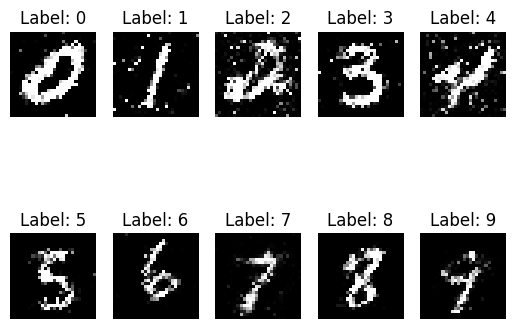

1/1 [==============================] - 0s 21ms/step
7301 [Discriminator loss: 0.672265, acc.: 56.25%] [Generator loss: 0.828000]
1/1 [==============================] - 0s 21ms/step
7302 [Discriminator loss: 0.665422, acc.: 62.50%] [Generator loss: 0.804290]
1/1 [==============================] - 0s 36ms/step
7303 [Discriminator loss: 0.669190, acc.: 56.25%] [Generator loss: 0.788329]
1/1 [==============================] - 0s 47ms/step
7304 [Discriminator loss: 0.667037, acc.: 59.38%] [Generator loss: 0.842298]
1/1 [==============================] - 0s 36ms/step
7305 [Discriminator loss: 0.714363, acc.: 51.56%] [Generator loss: 0.778226]
1/1 [==============================] - 0s 31ms/step
7306 [Discriminator loss: 0.656601, acc.: 60.94%] [Generator loss: 0.760961]
1/1 [==============================] - 0s 48ms/step
7307 [Discriminator loss: 0.675776, acc.: 60.94%] [Generator loss: 0.784163]
1/1 [==============================] - 0s 43ms/step
7308 [Discriminator loss: 0.663495, acc.: 53.

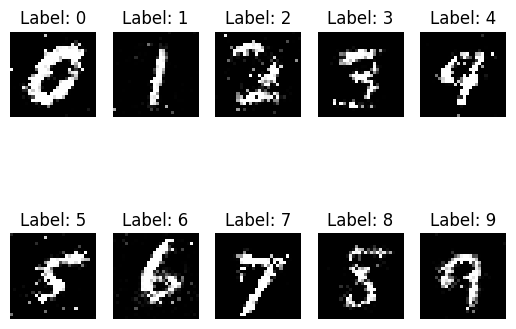

1/1 [==============================] - 0s 16ms/step
7401 [Discriminator loss: 0.745935, acc.: 43.75%] [Generator loss: 0.717930]
1/1 [==============================] - 0s 16ms/step
7402 [Discriminator loss: 0.690688, acc.: 59.38%] [Generator loss: 0.845375]
1/1 [==============================] - 0s 21ms/step
7403 [Discriminator loss: 0.706773, acc.: 43.75%] [Generator loss: 0.810472]
1/1 [==============================] - 0s 18ms/step
7404 [Discriminator loss: 0.661702, acc.: 59.38%] [Generator loss: 0.833788]
1/1 [==============================] - 0s 27ms/step
7405 [Discriminator loss: 0.686826, acc.: 48.44%] [Generator loss: 0.773037]
1/1 [==============================] - 0s 46ms/step
7406 [Discriminator loss: 0.654631, acc.: 65.62%] [Generator loss: 0.805164]
1/1 [==============================] - 0s 28ms/step
7407 [Discriminator loss: 0.629200, acc.: 60.94%] [Generator loss: 0.818165]
1/1 [==============================] - 0s 30ms/step
7408 [Discriminator loss: 0.662120, acc.: 57.

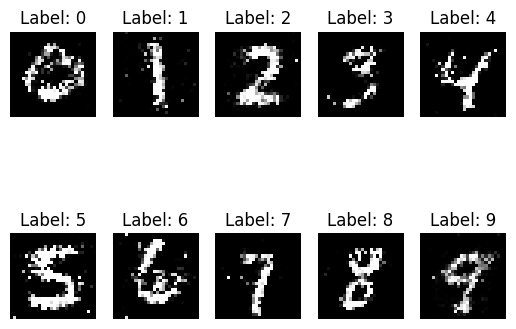

1/1 [==============================] - 0s 17ms/step
7501 [Discriminator loss: 0.686412, acc.: 51.56%] [Generator loss: 0.812135]
1/1 [==============================] - 0s 16ms/step
7502 [Discriminator loss: 0.712550, acc.: 56.25%] [Generator loss: 0.819127]
1/1 [==============================] - 0s 21ms/step
7503 [Discriminator loss: 0.659886, acc.: 60.94%] [Generator loss: 0.783440]
1/1 [==============================] - 0s 16ms/step
7504 [Discriminator loss: 0.626483, acc.: 67.19%] [Generator loss: 0.785119]
1/1 [==============================] - 0s 27ms/step
7505 [Discriminator loss: 0.685590, acc.: 53.12%] [Generator loss: 0.809072]
1/1 [==============================] - 0s 26ms/step
7506 [Discriminator loss: 0.679263, acc.: 56.25%] [Generator loss: 0.833634]
1/1 [==============================] - 0s 18ms/step
7507 [Discriminator loss: 0.668859, acc.: 60.94%] [Generator loss: 0.809541]
1/1 [==============================] - 0s 28ms/step
7508 [Discriminator loss: 0.647639, acc.: 59.

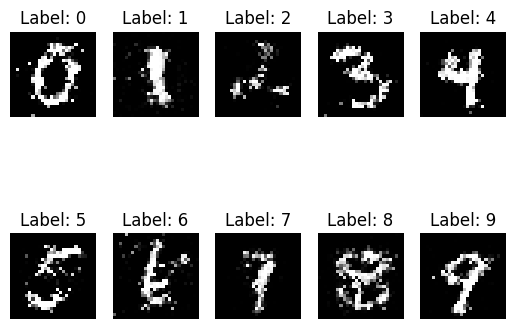

1/1 [==============================] - 0s 19ms/step
7601 [Discriminator loss: 0.656901, acc.: 60.94%] [Generator loss: 0.784627]
1/1 [==============================] - 0s 21ms/step
7602 [Discriminator loss: 0.656296, acc.: 64.06%] [Generator loss: 0.780036]
1/1 [==============================] - 0s 22ms/step
7603 [Discriminator loss: 0.664206, acc.: 68.75%] [Generator loss: 0.824889]
1/1 [==============================] - 0s 21ms/step
7604 [Discriminator loss: 0.660488, acc.: 51.56%] [Generator loss: 0.829840]
1/1 [==============================] - 0s 21ms/step
7605 [Discriminator loss: 0.652694, acc.: 64.06%] [Generator loss: 0.780118]
1/1 [==============================] - 0s 22ms/step
7606 [Discriminator loss: 0.670548, acc.: 65.62%] [Generator loss: 0.778912]
1/1 [==============================] - 0s 23ms/step
7607 [Discriminator loss: 0.665699, acc.: 54.69%] [Generator loss: 0.784887]
1/1 [==============================] - 0s 23ms/step
7608 [Discriminator loss: 0.672792, acc.: 51.

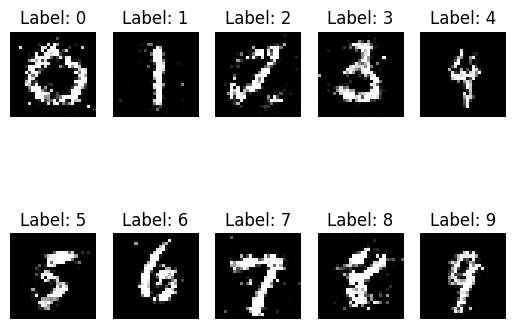

1/1 [==============================] - 0s 22ms/step
7701 [Discriminator loss: 0.666830, acc.: 65.62%] [Generator loss: 0.775788]
1/1 [==============================] - 0s 19ms/step
7702 [Discriminator loss: 0.672021, acc.: 51.56%] [Generator loss: 0.832518]
1/1 [==============================] - 0s 30ms/step
7703 [Discriminator loss: 0.647313, acc.: 68.75%] [Generator loss: 0.792088]
1/1 [==============================] - 0s 25ms/step
7704 [Discriminator loss: 0.644717, acc.: 67.19%] [Generator loss: 0.849048]
1/1 [==============================] - 0s 26ms/step
7705 [Discriminator loss: 0.643687, acc.: 57.81%] [Generator loss: 0.782789]
1/1 [==============================] - 0s 29ms/step
7706 [Discriminator loss: 0.684175, acc.: 59.38%] [Generator loss: 0.763065]
1/1 [==============================] - 0s 23ms/step
7707 [Discriminator loss: 0.673280, acc.: 60.94%] [Generator loss: 0.756524]
1/1 [==============================] - 0s 31ms/step
7708 [Discriminator loss: 0.614193, acc.: 65.

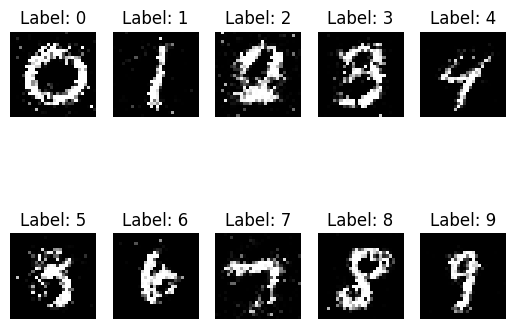

1/1 [==============================] - 0s 18ms/step
7801 [Discriminator loss: 0.706350, acc.: 46.88%] [Generator loss: 0.734605]
1/1 [==============================] - 0s 16ms/step
7802 [Discriminator loss: 0.713585, acc.: 53.12%] [Generator loss: 0.787709]
1/1 [==============================] - 0s 28ms/step
7803 [Discriminator loss: 0.669360, acc.: 54.69%] [Generator loss: 0.831213]
1/1 [==============================] - 0s 26ms/step
7804 [Discriminator loss: 0.706685, acc.: 48.44%] [Generator loss: 0.736576]
1/1 [==============================] - 0s 23ms/step
7805 [Discriminator loss: 0.653362, acc.: 64.06%] [Generator loss: 0.741871]
1/1 [==============================] - 0s 23ms/step
7806 [Discriminator loss: 0.659949, acc.: 57.81%] [Generator loss: 0.797169]
1/1 [==============================] - 0s 25ms/step
7807 [Discriminator loss: 0.638392, acc.: 62.50%] [Generator loss: 0.764342]
1/1 [==============================] - 0s 24ms/step
7808 [Discriminator loss: 0.670258, acc.: 62.

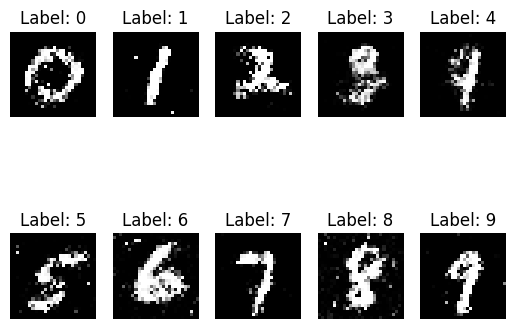

1/1 [==============================] - 0s 17ms/step
7901 [Discriminator loss: 0.609773, acc.: 67.19%] [Generator loss: 0.797539]
1/1 [==============================] - 0s 15ms/step
7902 [Discriminator loss: 0.658094, acc.: 46.88%] [Generator loss: 0.753683]
1/1 [==============================] - 0s 23ms/step
7903 [Discriminator loss: 0.679162, acc.: 54.69%] [Generator loss: 0.834185]
1/1 [==============================] - 0s 25ms/step
7904 [Discriminator loss: 0.631399, acc.: 62.50%] [Generator loss: 0.772069]
1/1 [==============================] - 0s 22ms/step
7905 [Discriminator loss: 0.690012, acc.: 50.00%] [Generator loss: 0.829757]
1/1 [==============================] - 0s 19ms/step
7906 [Discriminator loss: 0.695489, acc.: 45.31%] [Generator loss: 0.784950]
1/1 [==============================] - 0s 16ms/step
7907 [Discriminator loss: 0.707841, acc.: 50.00%] [Generator loss: 0.794187]
1/1 [==============================] - 0s 22ms/step
7908 [Discriminator loss: 0.659868, acc.: 59.

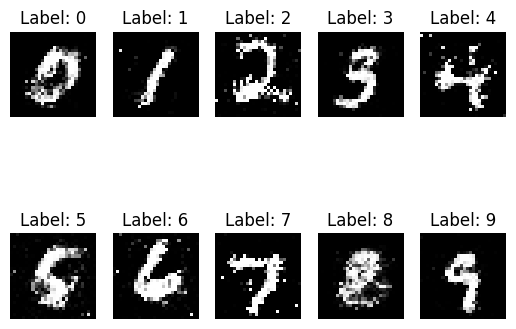

1/1 [==============================] - 0s 16ms/step
8001 [Discriminator loss: 0.701416, acc.: 56.25%] [Generator loss: 0.745600]
1/1 [==============================] - 0s 16ms/step
8002 [Discriminator loss: 0.671575, acc.: 54.69%] [Generator loss: 0.833795]
1/1 [==============================] - 0s 36ms/step
8003 [Discriminator loss: 0.658906, acc.: 57.81%] [Generator loss: 0.772396]
1/1 [==============================] - 0s 23ms/step
8004 [Discriminator loss: 0.671279, acc.: 60.94%] [Generator loss: 0.802479]
1/1 [==============================] - 0s 23ms/step
8005 [Discriminator loss: 0.702768, acc.: 54.69%] [Generator loss: 0.794625]
1/1 [==============================] - 0s 21ms/step
8006 [Discriminator loss: 0.642141, acc.: 60.94%] [Generator loss: 0.813442]
1/1 [==============================] - 0s 24ms/step
8007 [Discriminator loss: 0.660639, acc.: 56.25%] [Generator loss: 0.820333]
1/1 [==============================] - 0s 27ms/step
8008 [Discriminator loss: 0.694654, acc.: 54.

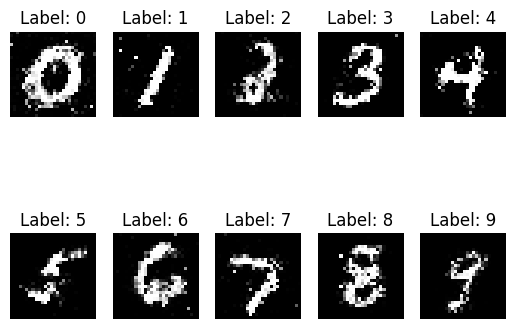

1/1 [==============================] - 0s 23ms/step
8101 [Discriminator loss: 0.661609, acc.: 56.25%] [Generator loss: 0.913417]
1/1 [==============================] - 0s 20ms/step
8102 [Discriminator loss: 0.601061, acc.: 67.19%] [Generator loss: 0.850647]
1/1 [==============================] - 0s 22ms/step
8103 [Discriminator loss: 0.663652, acc.: 56.25%] [Generator loss: 0.808182]
1/1 [==============================] - 0s 21ms/step
8104 [Discriminator loss: 0.714111, acc.: 51.56%] [Generator loss: 0.921212]
1/1 [==============================] - 0s 32ms/step
8105 [Discriminator loss: 0.669862, acc.: 54.69%] [Generator loss: 0.921120]
1/1 [==============================] - 0s 26ms/step
8106 [Discriminator loss: 0.653875, acc.: 60.94%] [Generator loss: 0.904909]
1/1 [==============================] - 0s 29ms/step
8107 [Discriminator loss: 0.622694, acc.: 65.62%] [Generator loss: 0.830593]
1/1 [==============================] - 0s 21ms/step
8108 [Discriminator loss: 0.675156, acc.: 54.

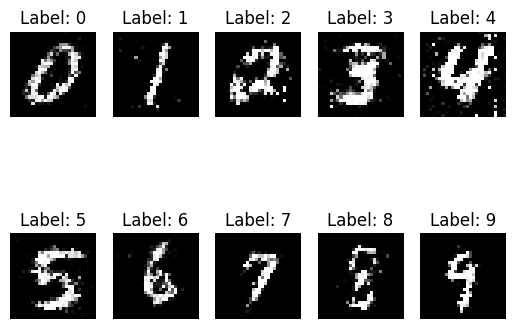

1/1 [==============================] - 0s 17ms/step
8201 [Discriminator loss: 0.614562, acc.: 68.75%] [Generator loss: 0.869142]
1/1 [==============================] - 0s 18ms/step
8202 [Discriminator loss: 0.709598, acc.: 48.44%] [Generator loss: 0.804338]
1/1 [==============================] - 0s 30ms/step
8203 [Discriminator loss: 0.600791, acc.: 65.62%] [Generator loss: 0.827157]
1/1 [==============================] - 0s 21ms/step
8204 [Discriminator loss: 0.668000, acc.: 56.25%] [Generator loss: 0.913754]
1/1 [==============================] - 0s 27ms/step
8205 [Discriminator loss: 0.642729, acc.: 60.94%] [Generator loss: 0.872197]
1/1 [==============================] - 0s 21ms/step
8206 [Discriminator loss: 0.667283, acc.: 57.81%] [Generator loss: 0.826045]
1/1 [==============================] - 0s 26ms/step
8207 [Discriminator loss: 0.665269, acc.: 56.25%] [Generator loss: 0.850719]
1/1 [==============================] - 0s 27ms/step
8208 [Discriminator loss: 0.696192, acc.: 60.

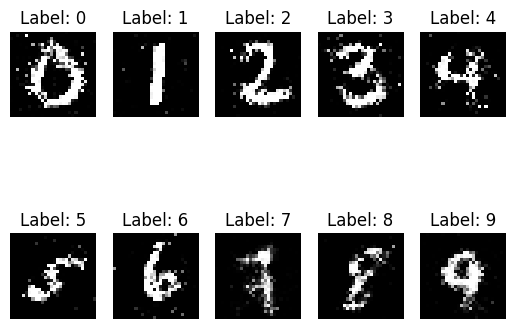

1/1 [==============================] - 0s 32ms/step
8301 [Discriminator loss: 0.644040, acc.: 59.38%] [Generator loss: 0.853290]
1/1 [==============================] - 0s 26ms/step
8302 [Discriminator loss: 0.657154, acc.: 56.25%] [Generator loss: 0.811733]
1/1 [==============================] - 0s 26ms/step
8303 [Discriminator loss: 0.650533, acc.: 65.62%] [Generator loss: 0.788619]
1/1 [==============================] - 0s 30ms/step
8304 [Discriminator loss: 0.663604, acc.: 48.44%] [Generator loss: 0.773315]
1/1 [==============================] - 0s 32ms/step
8305 [Discriminator loss: 0.658040, acc.: 53.12%] [Generator loss: 0.784088]
1/1 [==============================] - 0s 25ms/step
8306 [Discriminator loss: 0.684509, acc.: 56.25%] [Generator loss: 0.802464]
1/1 [==============================] - 0s 27ms/step
8307 [Discriminator loss: 0.682474, acc.: 60.94%] [Generator loss: 0.822853]
1/1 [==============================] - 0s 29ms/step
8308 [Discriminator loss: 0.638867, acc.: 67.

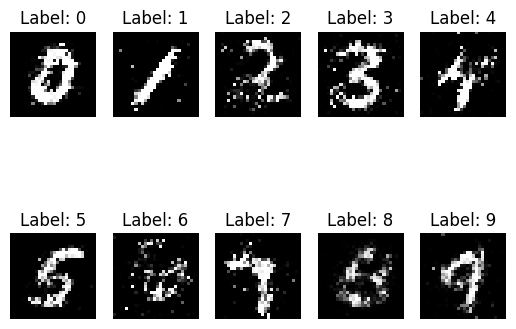

1/1 [==============================] - 0s 24ms/step
8401 [Discriminator loss: 0.664916, acc.: 51.56%] [Generator loss: 0.793249]
1/1 [==============================] - 0s 25ms/step
8402 [Discriminator loss: 0.735231, acc.: 53.12%] [Generator loss: 0.774684]
1/1 [==============================] - 0s 26ms/step
8403 [Discriminator loss: 0.669468, acc.: 56.25%] [Generator loss: 0.831921]
1/1 [==============================] - 0s 25ms/step
8404 [Discriminator loss: 0.674492, acc.: 57.81%] [Generator loss: 0.843194]
1/1 [==============================] - 0s 24ms/step
8405 [Discriminator loss: 0.619516, acc.: 68.75%] [Generator loss: 0.774236]
1/1 [==============================] - 0s 23ms/step
8406 [Discriminator loss: 0.658064, acc.: 57.81%] [Generator loss: 0.783612]
1/1 [==============================] - 0s 24ms/step
8407 [Discriminator loss: 0.688760, acc.: 54.69%] [Generator loss: 0.757710]
1/1 [==============================] - 0s 28ms/step
8408 [Discriminator loss: 0.674127, acc.: 62.

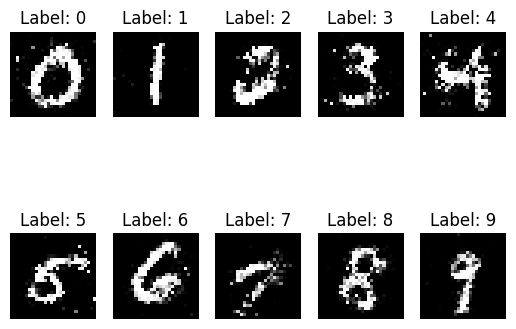

1/1 [==============================] - 0s 24ms/step
8501 [Discriminator loss: 0.680687, acc.: 51.56%] [Generator loss: 0.811842]
1/1 [==============================] - 0s 23ms/step
8502 [Discriminator loss: 0.678246, acc.: 50.00%] [Generator loss: 0.784118]
1/1 [==============================] - 0s 23ms/step
8503 [Discriminator loss: 0.722254, acc.: 53.12%] [Generator loss: 0.810311]
1/1 [==============================] - 0s 32ms/step
8504 [Discriminator loss: 0.670494, acc.: 57.81%] [Generator loss: 0.764207]
1/1 [==============================] - 0s 23ms/step
8505 [Discriminator loss: 0.701590, acc.: 53.12%] [Generator loss: 0.802940]
1/1 [==============================] - 0s 23ms/step
8506 [Discriminator loss: 0.682057, acc.: 56.25%] [Generator loss: 0.749189]
1/1 [==============================] - 0s 25ms/step
8507 [Discriminator loss: 0.675647, acc.: 51.56%] [Generator loss: 0.835408]
1/1 [==============================] - 0s 24ms/step
8508 [Discriminator loss: 0.660113, acc.: 57.

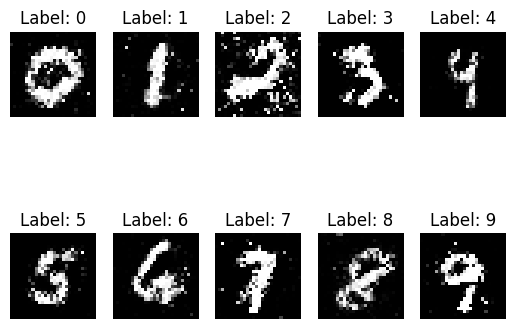

1/1 [==============================] - 0s 35ms/step
8601 [Discriminator loss: 0.676907, acc.: 57.81%] [Generator loss: 0.734212]
1/1 [==============================] - 0s 24ms/step
8602 [Discriminator loss: 0.646608, acc.: 57.81%] [Generator loss: 0.807166]
1/1 [==============================] - 0s 27ms/step
8603 [Discriminator loss: 0.629106, acc.: 59.38%] [Generator loss: 0.831588]
1/1 [==============================] - 0s 24ms/step
8604 [Discriminator loss: 0.653066, acc.: 48.44%] [Generator loss: 0.766423]
1/1 [==============================] - 0s 25ms/step
8605 [Discriminator loss: 0.695866, acc.: 48.44%] [Generator loss: 0.786160]
1/1 [==============================] - 0s 23ms/step
8606 [Discriminator loss: 0.672169, acc.: 57.81%] [Generator loss: 0.783146]
1/1 [==============================] - 0s 25ms/step
8607 [Discriminator loss: 0.656363, acc.: 64.06%] [Generator loss: 0.815400]
1/1 [==============================] - 0s 23ms/step
8608 [Discriminator loss: 0.685816, acc.: 53.

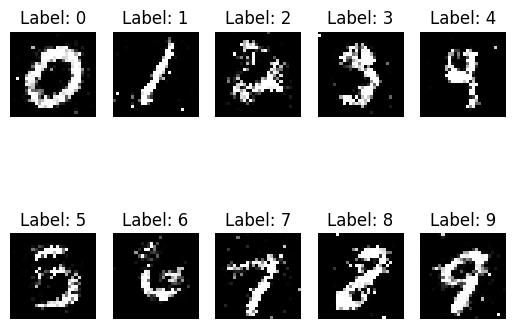

1/1 [==============================] - 0s 24ms/step
8701 [Discriminator loss: 0.668549, acc.: 53.12%] [Generator loss: 0.824632]
1/1 [==============================] - 0s 23ms/step
8702 [Discriminator loss: 0.659333, acc.: 57.81%] [Generator loss: 0.811128]
1/1 [==============================] - 0s 24ms/step
8703 [Discriminator loss: 0.611798, acc.: 62.50%] [Generator loss: 0.747392]
1/1 [==============================] - 0s 27ms/step
8704 [Discriminator loss: 0.672647, acc.: 57.81%] [Generator loss: 0.864456]
1/1 [==============================] - 0s 27ms/step
8705 [Discriminator loss: 0.654266, acc.: 62.50%] [Generator loss: 0.776607]
1/1 [==============================] - 0s 28ms/step
8706 [Discriminator loss: 0.636284, acc.: 57.81%] [Generator loss: 0.803459]
1/1 [==============================] - 0s 25ms/step
8707 [Discriminator loss: 0.662287, acc.: 60.94%] [Generator loss: 0.863282]
1/1 [==============================] - 0s 23ms/step
8708 [Discriminator loss: 0.634904, acc.: 67.

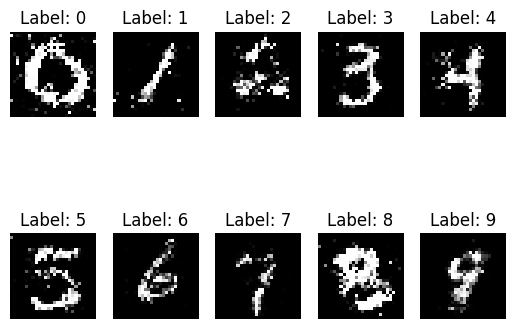

1/1 [==============================] - 0s 29ms/step
8801 [Discriminator loss: 0.689882, acc.: 42.19%] [Generator loss: 0.852725]
1/1 [==============================] - 0s 35ms/step
8802 [Discriminator loss: 0.717824, acc.: 51.56%] [Generator loss: 0.815402]
1/1 [==============================] - 0s 31ms/step
8803 [Discriminator loss: 0.687750, acc.: 51.56%] [Generator loss: 0.805531]
1/1 [==============================] - 0s 27ms/step
8804 [Discriminator loss: 0.668499, acc.: 60.94%] [Generator loss: 0.820780]
1/1 [==============================] - 0s 26ms/step
8805 [Discriminator loss: 0.722030, acc.: 45.31%] [Generator loss: 0.824458]
1/1 [==============================] - 0s 28ms/step
8806 [Discriminator loss: 0.694856, acc.: 56.25%] [Generator loss: 0.799951]
1/1 [==============================] - 0s 26ms/step
8807 [Discriminator loss: 0.668777, acc.: 54.69%] [Generator loss: 0.807276]
1/1 [==============================] - 0s 28ms/step
8808 [Discriminator loss: 0.688450, acc.: 43.

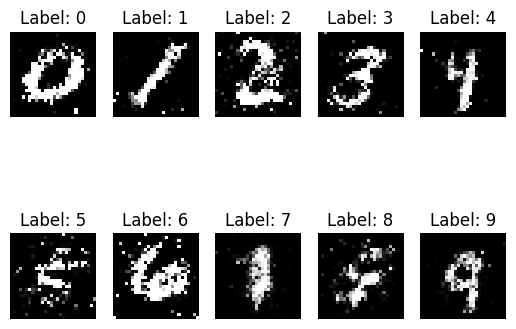

1/1 [==============================] - 0s 23ms/step
8901 [Discriminator loss: 0.632561, acc.: 70.31%] [Generator loss: 0.806209]
1/1 [==============================] - 0s 25ms/step
8902 [Discriminator loss: 0.605860, acc.: 64.06%] [Generator loss: 0.865075]
1/1 [==============================] - 0s 24ms/step
8903 [Discriminator loss: 0.645079, acc.: 56.25%] [Generator loss: 0.737085]
1/1 [==============================] - 0s 24ms/step
8904 [Discriminator loss: 0.653047, acc.: 50.00%] [Generator loss: 0.815209]
1/1 [==============================] - 0s 23ms/step
8905 [Discriminator loss: 0.646100, acc.: 57.81%] [Generator loss: 0.900571]
1/1 [==============================] - 0s 23ms/step
8906 [Discriminator loss: 0.596175, acc.: 68.75%] [Generator loss: 0.834323]
1/1 [==============================] - 0s 25ms/step
8907 [Discriminator loss: 0.670570, acc.: 59.38%] [Generator loss: 0.890366]
1/1 [==============================] - 0s 23ms/step
8908 [Discriminator loss: 0.644930, acc.: 59.

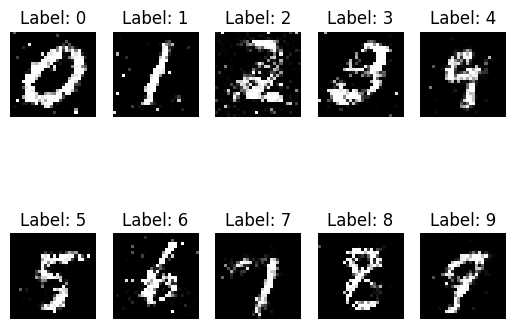

1/1 [==============================] - 0s 24ms/step
9001 [Discriminator loss: 0.624450, acc.: 62.50%] [Generator loss: 0.923029]
1/1 [==============================] - 0s 23ms/step
9002 [Discriminator loss: 0.742737, acc.: 60.94%] [Generator loss: 0.870155]
1/1 [==============================] - 0s 25ms/step
9003 [Discriminator loss: 0.663589, acc.: 54.69%] [Generator loss: 0.790844]
1/1 [==============================] - 0s 23ms/step
9004 [Discriminator loss: 0.703727, acc.: 54.69%] [Generator loss: 0.842512]
1/1 [==============================] - 0s 30ms/step
9005 [Discriminator loss: 0.615504, acc.: 64.06%] [Generator loss: 0.875092]
1/1 [==============================] - 0s 24ms/step
9006 [Discriminator loss: 0.643373, acc.: 59.38%] [Generator loss: 0.823909]
1/1 [==============================] - 0s 24ms/step
9007 [Discriminator loss: 0.705199, acc.: 46.88%] [Generator loss: 0.917926]
1/1 [==============================] - 0s 23ms/step
9008 [Discriminator loss: 0.613703, acc.: 71.

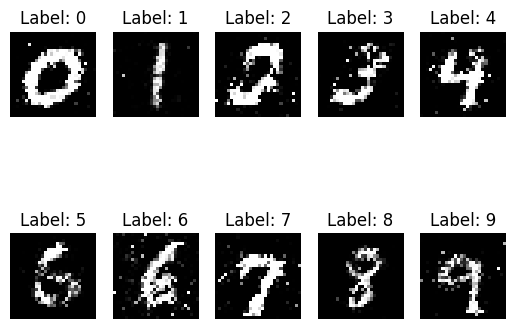

1/1 [==============================] - 0s 25ms/step
9101 [Discriminator loss: 0.632932, acc.: 65.62%] [Generator loss: 0.838070]
1/1 [==============================] - 0s 25ms/step
9102 [Discriminator loss: 0.660363, acc.: 60.94%] [Generator loss: 0.820512]
1/1 [==============================] - 0s 23ms/step
9103 [Discriminator loss: 0.677688, acc.: 57.81%] [Generator loss: 0.803076]
1/1 [==============================] - 0s 23ms/step
9104 [Discriminator loss: 0.638456, acc.: 62.50%] [Generator loss: 0.814644]
1/1 [==============================] - 0s 24ms/step
9105 [Discriminator loss: 0.624125, acc.: 54.69%] [Generator loss: 0.756620]
1/1 [==============================] - 0s 26ms/step
9106 [Discriminator loss: 0.676255, acc.: 64.06%] [Generator loss: 0.816485]
1/1 [==============================] - 0s 23ms/step
9107 [Discriminator loss: 0.642400, acc.: 59.38%] [Generator loss: 0.862787]
1/1 [==============================] - 0s 25ms/step
9108 [Discriminator loss: 0.617476, acc.: 68.

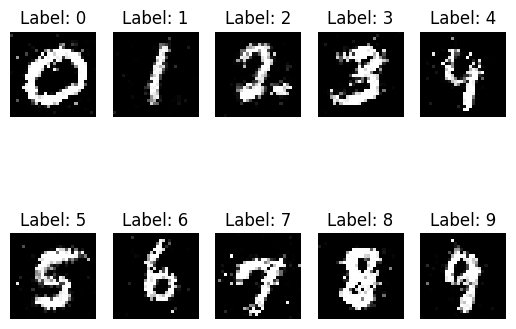

1/1 [==============================] - 0s 32ms/step
9201 [Discriminator loss: 0.667768, acc.: 65.62%] [Generator loss: 0.820856]
1/1 [==============================] - 0s 28ms/step
9202 [Discriminator loss: 0.657794, acc.: 59.38%] [Generator loss: 0.780518]
1/1 [==============================] - 0s 29ms/step
9203 [Discriminator loss: 0.653284, acc.: 56.25%] [Generator loss: 0.781524]
1/1 [==============================] - 0s 29ms/step
9204 [Discriminator loss: 0.658543, acc.: 56.25%] [Generator loss: 0.771792]
1/1 [==============================] - 0s 26ms/step
9205 [Discriminator loss: 0.649069, acc.: 59.38%] [Generator loss: 0.803353]
1/1 [==============================] - 0s 29ms/step
9206 [Discriminator loss: 0.698546, acc.: 60.94%] [Generator loss: 0.785155]
1/1 [==============================] - 0s 27ms/step
9207 [Discriminator loss: 0.639600, acc.: 57.81%] [Generator loss: 0.785338]
1/1 [==============================] - 0s 26ms/step
9208 [Discriminator loss: 0.671531, acc.: 59.

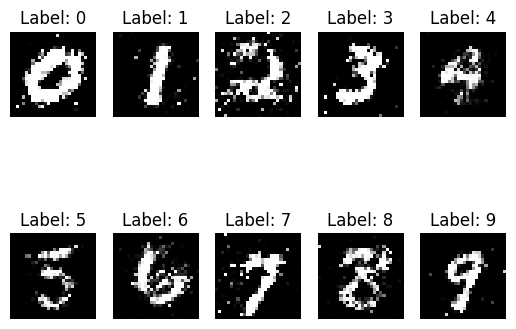

1/1 [==============================] - 0s 33ms/step
9301 [Discriminator loss: 0.643565, acc.: 59.38%] [Generator loss: 0.869484]
1/1 [==============================] - 0s 42ms/step
9302 [Discriminator loss: 0.592592, acc.: 65.62%] [Generator loss: 0.863169]
1/1 [==============================] - 0s 30ms/step
9303 [Discriminator loss: 0.650859, acc.: 60.94%] [Generator loss: 0.874462]
1/1 [==============================] - 0s 39ms/step
9304 [Discriminator loss: 0.655688, acc.: 68.75%] [Generator loss: 0.863088]
1/1 [==============================] - 0s 27ms/step
9305 [Discriminator loss: 0.638830, acc.: 57.81%] [Generator loss: 0.845616]
1/1 [==============================] - 0s 24ms/step
9306 [Discriminator loss: 0.696828, acc.: 53.12%] [Generator loss: 0.930445]
1/1 [==============================] - 0s 25ms/step
9307 [Discriminator loss: 0.655078, acc.: 56.25%] [Generator loss: 0.858226]
1/1 [==============================] - 0s 23ms/step
9308 [Discriminator loss: 0.659249, acc.: 59.

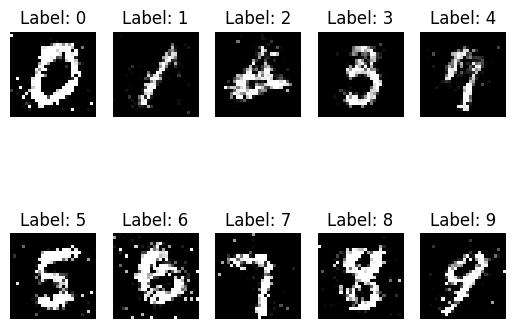

1/1 [==============================] - 0s 29ms/step
9401 [Discriminator loss: 0.669942, acc.: 50.00%] [Generator loss: 0.898318]
1/1 [==============================] - 0s 23ms/step
9402 [Discriminator loss: 0.669517, acc.: 57.81%] [Generator loss: 0.808053]
1/1 [==============================] - 0s 24ms/step
9403 [Discriminator loss: 0.641441, acc.: 70.31%] [Generator loss: 0.876569]
1/1 [==============================] - 0s 24ms/step
9404 [Discriminator loss: 0.692965, acc.: 59.38%] [Generator loss: 0.845688]
1/1 [==============================] - 0s 23ms/step
9405 [Discriminator loss: 0.664762, acc.: 60.94%] [Generator loss: 0.883529]
1/1 [==============================] - 0s 25ms/step
9406 [Discriminator loss: 0.613446, acc.: 60.94%] [Generator loss: 0.849017]
1/1 [==============================] - 0s 29ms/step
9407 [Discriminator loss: 0.674746, acc.: 54.69%] [Generator loss: 0.884303]
1/1 [==============================] - 0s 24ms/step
9408 [Discriminator loss: 0.653862, acc.: 60.

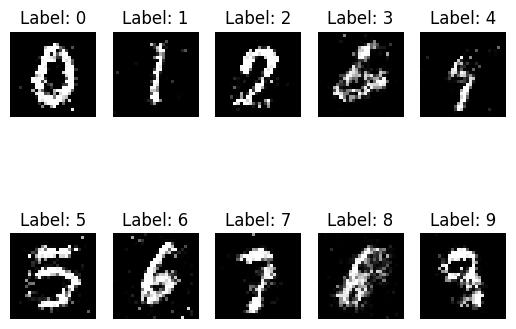

1/1 [==============================] - 0s 28ms/step
9501 [Discriminator loss: 0.710274, acc.: 48.44%] [Generator loss: 0.839434]
1/1 [==============================] - 0s 24ms/step
9502 [Discriminator loss: 0.674843, acc.: 54.69%] [Generator loss: 0.860200]
1/1 [==============================] - 0s 26ms/step
9503 [Discriminator loss: 0.649531, acc.: 51.56%] [Generator loss: 0.819318]
1/1 [==============================] - 0s 23ms/step
9504 [Discriminator loss: 0.641467, acc.: 68.75%] [Generator loss: 0.793556]
1/1 [==============================] - 0s 25ms/step
9505 [Discriminator loss: 0.657324, acc.: 56.25%] [Generator loss: 0.827206]
1/1 [==============================] - 0s 25ms/step
9506 [Discriminator loss: 0.680590, acc.: 56.25%] [Generator loss: 0.826265]
1/1 [==============================] - 0s 24ms/step
9507 [Discriminator loss: 0.640280, acc.: 56.25%] [Generator loss: 0.914954]
1/1 [==============================] - 0s 23ms/step
9508 [Discriminator loss: 0.655580, acc.: 60.

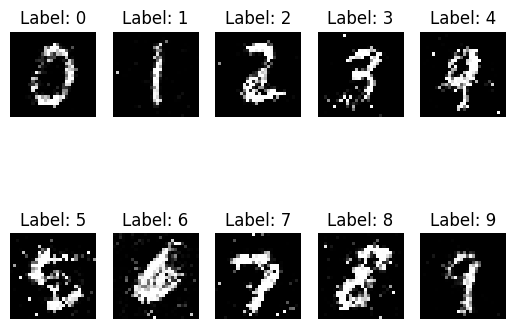

1/1 [==============================] - 0s 33ms/step
9601 [Discriminator loss: 0.662908, acc.: 60.94%] [Generator loss: 0.808538]
1/1 [==============================] - 0s 29ms/step
9602 [Discriminator loss: 0.695037, acc.: 51.56%] [Generator loss: 0.843054]
1/1 [==============================] - 0s 29ms/step
9603 [Discriminator loss: 0.691918, acc.: 50.00%] [Generator loss: 0.846102]
1/1 [==============================] - 0s 31ms/step
9604 [Discriminator loss: 0.666342, acc.: 56.25%] [Generator loss: 0.783321]
1/1 [==============================] - 0s 32ms/step
9605 [Discriminator loss: 0.616522, acc.: 60.94%] [Generator loss: 0.771936]
1/1 [==============================] - 0s 32ms/step
9606 [Discriminator loss: 0.708951, acc.: 48.44%] [Generator loss: 0.788155]
1/1 [==============================] - 0s 35ms/step
9607 [Discriminator loss: 0.635466, acc.: 60.94%] [Generator loss: 0.815321]
1/1 [==============================] - 0s 31ms/step
9608 [Discriminator loss: 0.654948, acc.: 51.

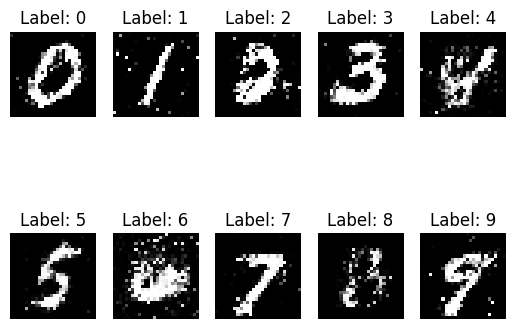

1/1 [==============================] - 0s 32ms/step
9701 [Discriminator loss: 0.660773, acc.: 57.81%] [Generator loss: 0.765029]
1/1 [==============================] - 0s 23ms/step
9702 [Discriminator loss: 0.672448, acc.: 65.62%] [Generator loss: 0.897830]
1/1 [==============================] - 0s 23ms/step
9703 [Discriminator loss: 0.632038, acc.: 62.50%] [Generator loss: 0.811916]
1/1 [==============================] - 0s 31ms/step
9704 [Discriminator loss: 0.649579, acc.: 54.69%] [Generator loss: 0.801064]
1/1 [==============================] - 0s 24ms/step
9705 [Discriminator loss: 0.686861, acc.: 60.94%] [Generator loss: 0.858696]
1/1 [==============================] - 0s 25ms/step
9706 [Discriminator loss: 0.676961, acc.: 53.12%] [Generator loss: 0.797261]
1/1 [==============================] - 0s 25ms/step
9707 [Discriminator loss: 0.645444, acc.: 67.19%] [Generator loss: 0.807892]
1/1 [==============================] - 0s 23ms/step
9708 [Discriminator loss: 0.652326, acc.: 57.

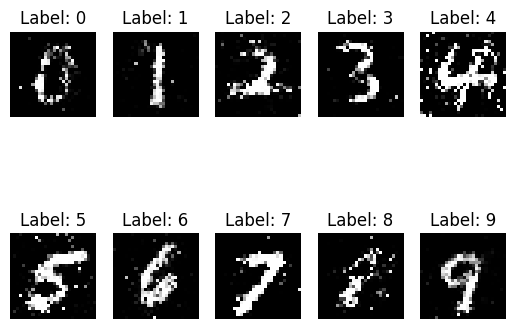

1/1 [==============================] - 0s 24ms/step
9801 [Discriminator loss: 0.679253, acc.: 54.69%] [Generator loss: 0.808857]
1/1 [==============================] - 0s 27ms/step
9802 [Discriminator loss: 0.660915, acc.: 54.69%] [Generator loss: 0.830133]
1/1 [==============================] - 0s 24ms/step
9803 [Discriminator loss: 0.637959, acc.: 60.94%] [Generator loss: 0.809801]
1/1 [==============================] - 0s 22ms/step
9804 [Discriminator loss: 0.654574, acc.: 57.81%] [Generator loss: 0.788646]
1/1 [==============================] - 0s 24ms/step
9805 [Discriminator loss: 0.657126, acc.: 57.81%] [Generator loss: 0.826292]
1/1 [==============================] - 0s 23ms/step
9806 [Discriminator loss: 0.654113, acc.: 57.81%] [Generator loss: 0.800078]
1/1 [==============================] - 0s 26ms/step
9807 [Discriminator loss: 0.618802, acc.: 62.50%] [Generator loss: 0.777415]
1/1 [==============================] - 0s 26ms/step
9808 [Discriminator loss: 0.681339, acc.: 62.

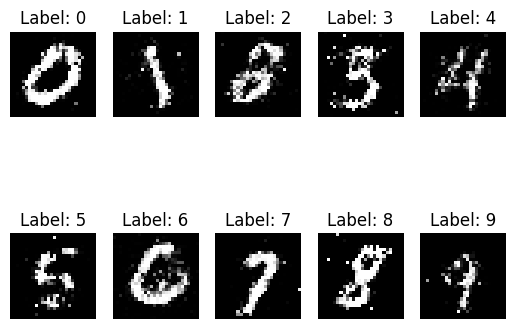

1/1 [==============================] - 0s 25ms/step
9901 [Discriminator loss: 0.630102, acc.: 60.94%] [Generator loss: 0.917032]
1/1 [==============================] - 0s 24ms/step
9902 [Discriminator loss: 0.669558, acc.: 54.69%] [Generator loss: 0.879083]
1/1 [==============================] - 0s 23ms/step
9903 [Discriminator loss: 0.648684, acc.: 56.25%] [Generator loss: 0.894876]
1/1 [==============================] - 0s 26ms/step
9904 [Discriminator loss: 0.617509, acc.: 67.19%] [Generator loss: 0.788081]
1/1 [==============================] - 0s 39ms/step
9905 [Discriminator loss: 0.661154, acc.: 54.69%] [Generator loss: 0.829888]
1/1 [==============================] - 0s 24ms/step
9906 [Discriminator loss: 0.709779, acc.: 57.81%] [Generator loss: 0.885459]
1/1 [==============================] - 0s 25ms/step
9907 [Discriminator loss: 0.708112, acc.: 50.00%] [Generator loss: 0.940022]
1/1 [==============================] - 0s 30ms/step
9908 [Discriminator loss: 0.616036, acc.: 68.

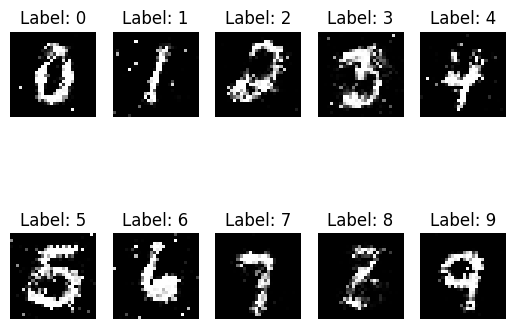

1/1 [==============================] - 0s 27ms/step
10001 [Discriminator loss: 0.667731, acc.: 59.38%] [Generator loss: 0.831333]
1/1 [==============================] - 0s 24ms/step
10002 [Discriminator loss: 0.627551, acc.: 59.38%] [Generator loss: 0.820006]
1/1 [==============================] - 0s 26ms/step
10003 [Discriminator loss: 0.726145, acc.: 45.31%] [Generator loss: 0.753078]
1/1 [==============================] - 0s 24ms/step
10004 [Discriminator loss: 0.638852, acc.: 67.19%] [Generator loss: 0.853881]
1/1 [==============================] - 0s 25ms/step
10005 [Discriminator loss: 0.674010, acc.: 62.50%] [Generator loss: 0.843712]
1/1 [==============================] - 0s 25ms/step
10006 [Discriminator loss: 0.654338, acc.: 62.50%] [Generator loss: 0.833361]
1/1 [==============================] - 0s 26ms/step
10007 [Discriminator loss: 0.691197, acc.: 46.88%] [Generator loss: 0.811885]
1/1 [==============================] - 0s 25ms/step
10008 [Discriminator loss: 0.673263, a

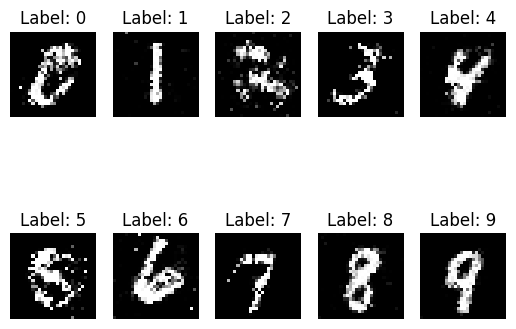

1/1 [==============================] - 0s 27ms/step
10101 [Discriminator loss: 0.590848, acc.: 68.75%] [Generator loss: 0.796479]
1/1 [==============================] - 0s 22ms/step
10102 [Discriminator loss: 0.701090, acc.: 53.12%] [Generator loss: 0.849981]
1/1 [==============================] - 0s 22ms/step
10103 [Discriminator loss: 0.673882, acc.: 59.38%] [Generator loss: 0.820618]
1/1 [==============================] - 0s 22ms/step
10104 [Discriminator loss: 0.661846, acc.: 50.00%] [Generator loss: 0.948064]
1/1 [==============================] - 0s 22ms/step
10105 [Discriminator loss: 0.637874, acc.: 62.50%] [Generator loss: 0.875146]
1/1 [==============================] - 0s 34ms/step
10106 [Discriminator loss: 0.720164, acc.: 53.12%] [Generator loss: 0.910550]
1/1 [==============================] - 0s 27ms/step
10107 [Discriminator loss: 0.692351, acc.: 56.25%] [Generator loss: 0.926805]
1/1 [==============================] - 0s 23ms/step
10108 [Discriminator loss: 0.639977, a

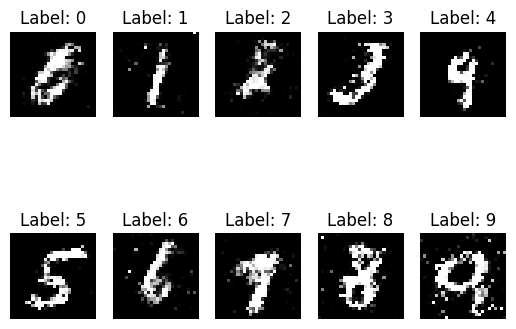

1/1 [==============================] - 0s 26ms/step
10201 [Discriminator loss: 0.672814, acc.: 56.25%] [Generator loss: 0.894201]
1/1 [==============================] - 0s 23ms/step
10202 [Discriminator loss: 0.722531, acc.: 51.56%] [Generator loss: 0.983248]
1/1 [==============================] - 0s 33ms/step
10203 [Discriminator loss: 0.639245, acc.: 67.19%] [Generator loss: 0.871709]
1/1 [==============================] - 0s 25ms/step
10204 [Discriminator loss: 0.650016, acc.: 56.25%] [Generator loss: 0.846119]
1/1 [==============================] - 0s 26ms/step
10205 [Discriminator loss: 0.705101, acc.: 54.69%] [Generator loss: 0.838627]
1/1 [==============================] - 0s 25ms/step
10206 [Discriminator loss: 0.606775, acc.: 65.62%] [Generator loss: 0.922283]
1/1 [==============================] - 0s 24ms/step
10207 [Discriminator loss: 0.690421, acc.: 56.25%] [Generator loss: 0.989131]
1/1 [==============================] - 0s 37ms/step
10208 [Discriminator loss: 0.686711, a

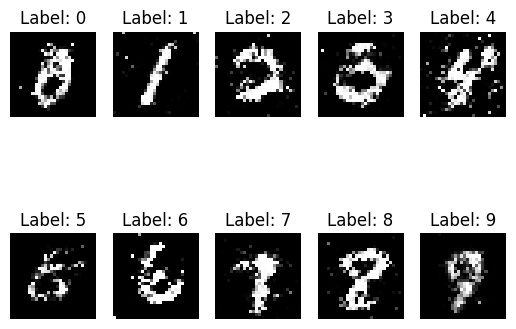

1/1 [==============================] - 0s 31ms/step
10301 [Discriminator loss: 0.643218, acc.: 54.69%] [Generator loss: 0.875641]
1/1 [==============================] - 0s 30ms/step
10302 [Discriminator loss: 0.692089, acc.: 54.69%] [Generator loss: 0.798971]
1/1 [==============================] - 0s 28ms/step
10303 [Discriminator loss: 0.663048, acc.: 57.81%] [Generator loss: 0.879001]
1/1 [==============================] - 0s 31ms/step
10304 [Discriminator loss: 0.703617, acc.: 50.00%] [Generator loss: 0.829106]
1/1 [==============================] - 0s 28ms/step
10305 [Discriminator loss: 0.642020, acc.: 64.06%] [Generator loss: 0.774719]
1/1 [==============================] - 0s 31ms/step
10306 [Discriminator loss: 0.700416, acc.: 59.38%] [Generator loss: 0.781095]
1/1 [==============================] - 0s 26ms/step
10307 [Discriminator loss: 0.685402, acc.: 53.12%] [Generator loss: 0.807454]
1/1 [==============================] - 0s 26ms/step
10308 [Discriminator loss: 0.666952, a

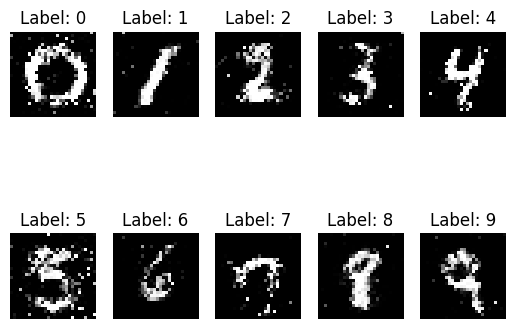

1/1 [==============================] - 0s 24ms/step
10401 [Discriminator loss: 0.628752, acc.: 62.50%] [Generator loss: 0.831548]
1/1 [==============================] - 0s 24ms/step
10402 [Discriminator loss: 0.650460, acc.: 59.38%] [Generator loss: 0.881276]
1/1 [==============================] - 0s 24ms/step
10403 [Discriminator loss: 0.637987, acc.: 64.06%] [Generator loss: 0.847624]
1/1 [==============================] - 0s 23ms/step
10404 [Discriminator loss: 0.685931, acc.: 48.44%] [Generator loss: 0.849304]
1/1 [==============================] - 0s 23ms/step
10405 [Discriminator loss: 0.583731, acc.: 73.44%] [Generator loss: 0.875610]
1/1 [==============================] - 0s 30ms/step
10406 [Discriminator loss: 0.627415, acc.: 68.75%] [Generator loss: 0.862315]
1/1 [==============================] - 0s 25ms/step
10407 [Discriminator loss: 0.666993, acc.: 56.25%] [Generator loss: 0.832252]
1/1 [==============================] - 0s 25ms/step
10408 [Discriminator loss: 0.654685, a

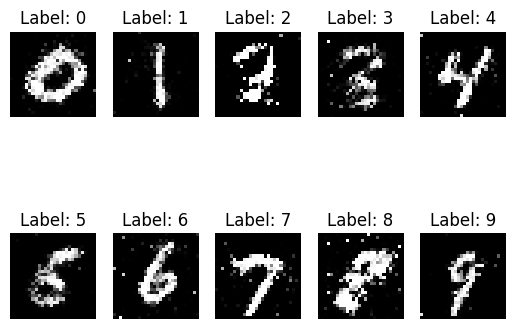

1/1 [==============================] - 0s 25ms/step
10501 [Discriminator loss: 0.680729, acc.: 53.12%] [Generator loss: 0.818569]
1/1 [==============================] - 0s 27ms/step
10502 [Discriminator loss: 0.691272, acc.: 60.94%] [Generator loss: 0.788627]
1/1 [==============================] - 0s 23ms/step
10503 [Discriminator loss: 0.615159, acc.: 60.94%] [Generator loss: 0.845393]
1/1 [==============================] - 0s 23ms/step
10504 [Discriminator loss: 0.683908, acc.: 53.12%] [Generator loss: 0.944888]
1/1 [==============================] - 0s 23ms/step
10505 [Discriminator loss: 0.634617, acc.: 73.44%] [Generator loss: 0.819626]
1/1 [==============================] - 0s 23ms/step
10506 [Discriminator loss: 0.687207, acc.: 51.56%] [Generator loss: 0.859583]
1/1 [==============================] - 0s 23ms/step
10507 [Discriminator loss: 0.630773, acc.: 62.50%] [Generator loss: 0.821553]
1/1 [==============================] - 0s 31ms/step
10508 [Discriminator loss: 0.662362, a

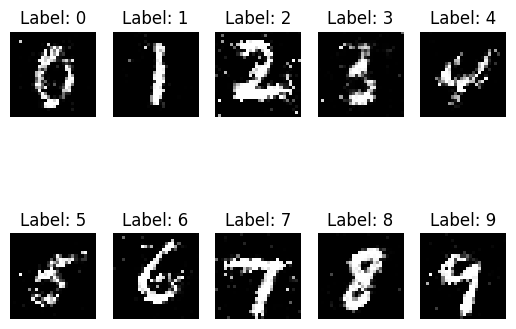

1/1 [==============================] - 0s 34ms/step
10601 [Discriminator loss: 0.653737, acc.: 60.94%] [Generator loss: 0.808273]
1/1 [==============================] - 0s 25ms/step
10602 [Discriminator loss: 0.690202, acc.: 57.81%] [Generator loss: 0.860245]
1/1 [==============================] - 0s 38ms/step
10603 [Discriminator loss: 0.596053, acc.: 71.88%] [Generator loss: 0.857448]
1/1 [==============================] - 0s 36ms/step
10604 [Discriminator loss: 0.641810, acc.: 64.06%] [Generator loss: 0.861985]
1/1 [==============================] - 0s 23ms/step
10605 [Discriminator loss: 0.619998, acc.: 57.81%] [Generator loss: 0.860766]
1/1 [==============================] - 0s 25ms/step
10606 [Discriminator loss: 0.609791, acc.: 62.50%] [Generator loss: 0.839027]
1/1 [==============================] - 0s 23ms/step
10607 [Discriminator loss: 0.614390, acc.: 67.19%] [Generator loss: 0.951181]
1/1 [==============================] - 0s 33ms/step
10608 [Discriminator loss: 0.650889, a

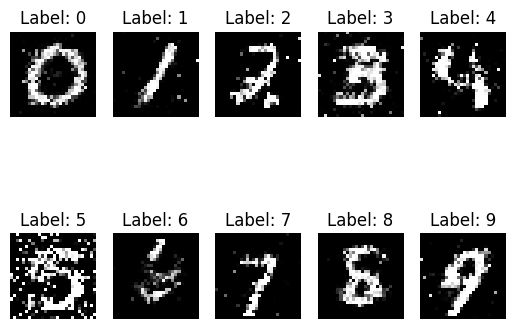

1/1 [==============================] - 0s 62ms/step
10701 [Discriminator loss: 0.688276, acc.: 64.06%] [Generator loss: 0.897346]
1/1 [==============================] - 0s 43ms/step
10702 [Discriminator loss: 0.583278, acc.: 70.31%] [Generator loss: 0.841327]
1/1 [==============================] - 0s 45ms/step
10703 [Discriminator loss: 0.623770, acc.: 68.75%] [Generator loss: 0.866181]
1/1 [==============================] - 0s 48ms/step
10704 [Discriminator loss: 0.614881, acc.: 64.06%] [Generator loss: 0.919561]
1/1 [==============================] - 0s 44ms/step
10705 [Discriminator loss: 0.683794, acc.: 53.12%] [Generator loss: 0.785720]
1/1 [==============================] - 0s 39ms/step
10706 [Discriminator loss: 0.606916, acc.: 68.75%] [Generator loss: 0.879775]
1/1 [==============================] - 0s 44ms/step
10707 [Discriminator loss: 0.614249, acc.: 70.31%] [Generator loss: 0.879213]
1/1 [==============================] - 0s 63ms/step
10708 [Discriminator loss: 0.709736, a

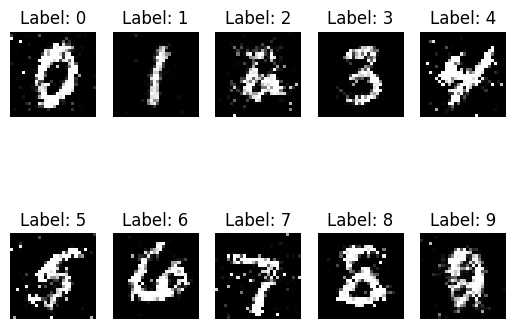

1/1 [==============================] - 0s 39ms/step
10801 [Discriminator loss: 0.652388, acc.: 64.06%] [Generator loss: 0.889911]
1/1 [==============================] - 0s 40ms/step
10802 [Discriminator loss: 0.616508, acc.: 60.94%] [Generator loss: 0.840011]
1/1 [==============================] - 0s 38ms/step
10803 [Discriminator loss: 0.659175, acc.: 64.06%] [Generator loss: 0.875504]
1/1 [==============================] - 0s 38ms/step
10804 [Discriminator loss: 0.659463, acc.: 64.06%] [Generator loss: 0.863752]
1/1 [==============================] - 0s 28ms/step
10805 [Discriminator loss: 0.716124, acc.: 54.69%] [Generator loss: 0.833456]
1/1 [==============================] - 0s 36ms/step
10806 [Discriminator loss: 0.592604, acc.: 70.31%] [Generator loss: 0.920873]
1/1 [==============================] - 0s 30ms/step
10807 [Discriminator loss: 0.640121, acc.: 60.94%] [Generator loss: 0.870586]
1/1 [==============================] - 0s 46ms/step
10808 [Discriminator loss: 0.643261, a

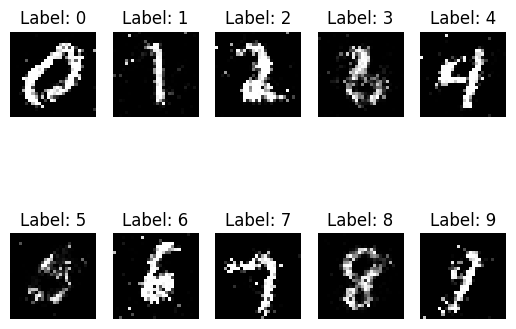

1/1 [==============================] - 0s 33ms/step
10901 [Discriminator loss: 0.691215, acc.: 60.94%] [Generator loss: 0.830891]
1/1 [==============================] - 0s 36ms/step
10902 [Discriminator loss: 0.630859, acc.: 67.19%] [Generator loss: 0.846562]
1/1 [==============================] - 0s 32ms/step
10903 [Discriminator loss: 0.629646, acc.: 64.06%] [Generator loss: 0.843327]
1/1 [==============================] - 0s 31ms/step
10904 [Discriminator loss: 0.645376, acc.: 68.75%] [Generator loss: 0.833550]
1/1 [==============================] - 0s 24ms/step
10905 [Discriminator loss: 0.687208, acc.: 59.38%] [Generator loss: 0.794816]
1/1 [==============================] - 0s 55ms/step
10906 [Discriminator loss: 0.640889, acc.: 60.94%] [Generator loss: 0.779381]
1/1 [==============================] - 0s 53ms/step
10907 [Discriminator loss: 0.687486, acc.: 53.12%] [Generator loss: 0.761252]
1/1 [==============================] - 0s 40ms/step
10908 [Discriminator loss: 0.693471, a

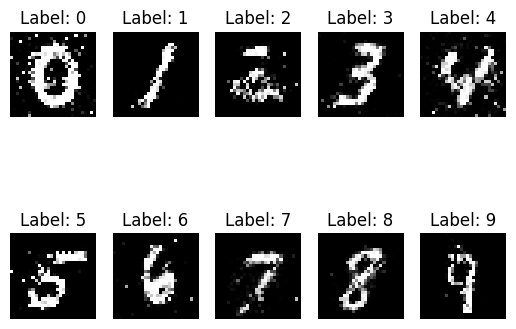

1/1 [==============================] - 0s 38ms/step
11001 [Discriminator loss: 0.672316, acc.: 60.94%] [Generator loss: 0.822787]
1/1 [==============================] - 0s 38ms/step
11002 [Discriminator loss: 0.654106, acc.: 57.81%] [Generator loss: 0.879672]
1/1 [==============================] - 0s 56ms/step
11003 [Discriminator loss: 0.651356, acc.: 62.50%] [Generator loss: 0.798813]
1/1 [==============================] - 0s 28ms/step
11004 [Discriminator loss: 0.660139, acc.: 56.25%] [Generator loss: 0.882223]
1/1 [==============================] - 0s 37ms/step
11005 [Discriminator loss: 0.649670, acc.: 57.81%] [Generator loss: 0.853593]
1/1 [==============================] - 0s 29ms/step
11006 [Discriminator loss: 0.654292, acc.: 60.94%] [Generator loss: 0.892028]
1/1 [==============================] - 0s 32ms/step
11007 [Discriminator loss: 0.655084, acc.: 60.94%] [Generator loss: 0.814095]
1/1 [==============================] - 0s 40ms/step
11008 [Discriminator loss: 0.658401, a

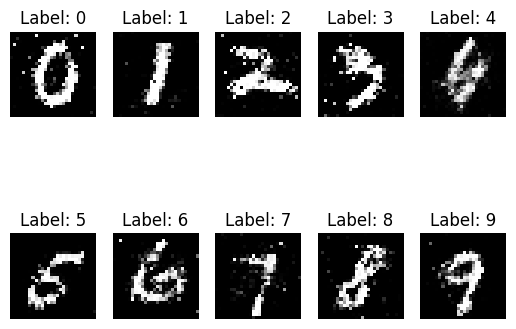

1/1 [==============================] - 0s 38ms/step
11101 [Discriminator loss: 0.630348, acc.: 54.69%] [Generator loss: 0.879452]
1/1 [==============================] - 0s 40ms/step
11102 [Discriminator loss: 0.676371, acc.: 59.38%] [Generator loss: 0.818492]
1/1 [==============================] - 0s 70ms/step
11103 [Discriminator loss: 0.643196, acc.: 57.81%] [Generator loss: 0.915948]
1/1 [==============================] - 0s 63ms/step
11104 [Discriminator loss: 0.697813, acc.: 54.69%] [Generator loss: 0.852944]
1/1 [==============================] - 0s 51ms/step
11105 [Discriminator loss: 0.658492, acc.: 57.81%] [Generator loss: 0.879435]
1/1 [==============================] - 0s 27ms/step
11106 [Discriminator loss: 0.679279, acc.: 57.81%] [Generator loss: 0.860042]
1/1 [==============================] - 0s 38ms/step
11107 [Discriminator loss: 0.633587, acc.: 59.38%] [Generator loss: 0.842643]
1/1 [==============================] - 0s 36ms/step
11108 [Discriminator loss: 0.650126, a

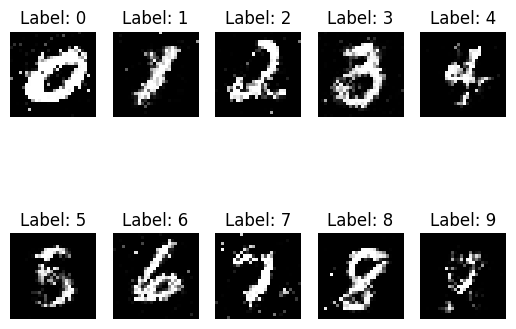

1/1 [==============================] - 0s 26ms/step
11201 [Discriminator loss: 0.714153, acc.: 62.50%] [Generator loss: 0.828022]
1/1 [==============================] - 0s 23ms/step
11202 [Discriminator loss: 0.633209, acc.: 57.81%] [Generator loss: 0.742834]
1/1 [==============================] - 0s 23ms/step
11203 [Discriminator loss: 0.665098, acc.: 57.81%] [Generator loss: 0.777129]
1/1 [==============================] - 0s 27ms/step
11204 [Discriminator loss: 0.643009, acc.: 59.38%] [Generator loss: 0.791903]
1/1 [==============================] - 0s 23ms/step
11205 [Discriminator loss: 0.624927, acc.: 67.19%] [Generator loss: 0.780027]
1/1 [==============================] - 0s 33ms/step
11206 [Discriminator loss: 0.688760, acc.: 59.38%] [Generator loss: 0.860199]
1/1 [==============================] - 0s 47ms/step
11207 [Discriminator loss: 0.630436, acc.: 59.38%] [Generator loss: 0.874120]
1/1 [==============================] - 0s 39ms/step
11208 [Discriminator loss: 0.570819, a

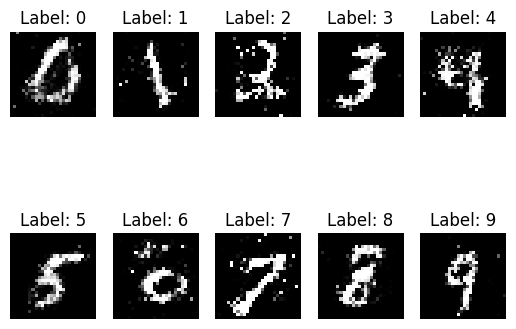

1/1 [==============================] - 0s 24ms/step
11301 [Discriminator loss: 0.639978, acc.: 64.06%] [Generator loss: 0.838482]
1/1 [==============================] - 0s 28ms/step
11302 [Discriminator loss: 0.672366, acc.: 56.25%] [Generator loss: 0.867551]
1/1 [==============================] - 0s 28ms/step
11303 [Discriminator loss: 0.624299, acc.: 64.06%] [Generator loss: 0.957209]
1/1 [==============================] - 0s 23ms/step
11304 [Discriminator loss: 0.628100, acc.: 67.19%] [Generator loss: 0.865981]
1/1 [==============================] - 0s 24ms/step
11305 [Discriminator loss: 0.691892, acc.: 57.81%] [Generator loss: 0.854194]
1/1 [==============================] - 0s 23ms/step
11306 [Discriminator loss: 0.690356, acc.: 53.12%] [Generator loss: 0.816388]
1/1 [==============================] - 0s 25ms/step
11307 [Discriminator loss: 0.650104, acc.: 54.69%] [Generator loss: 0.877384]
1/1 [==============================] - 0s 25ms/step
11308 [Discriminator loss: 0.648057, a

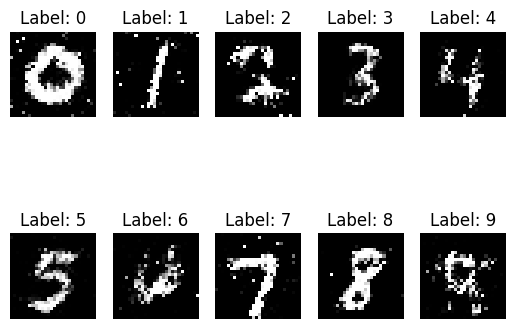

1/1 [==============================] - 0s 25ms/step
11401 [Discriminator loss: 0.679880, acc.: 53.12%] [Generator loss: 0.843530]
1/1 [==============================] - 0s 22ms/step
11402 [Discriminator loss: 0.666257, acc.: 64.06%] [Generator loss: 0.788003]
1/1 [==============================] - 0s 27ms/step
11403 [Discriminator loss: 0.600372, acc.: 65.62%] [Generator loss: 0.713886]
1/1 [==============================] - 0s 25ms/step
11404 [Discriminator loss: 0.677429, acc.: 56.25%] [Generator loss: 0.826457]
1/1 [==============================] - 0s 23ms/step
11405 [Discriminator loss: 0.619566, acc.: 51.56%] [Generator loss: 0.824108]
1/1 [==============================] - 0s 23ms/step
11406 [Discriminator loss: 0.685885, acc.: 57.81%] [Generator loss: 0.821854]
1/1 [==============================] - 0s 24ms/step
11407 [Discriminator loss: 0.730792, acc.: 48.44%] [Generator loss: 0.789990]
1/1 [==============================] - 0s 25ms/step
11408 [Discriminator loss: 0.658497, a

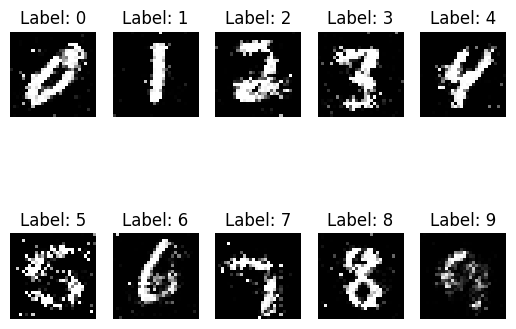

1/1 [==============================] - 0s 31ms/step
11501 [Discriminator loss: 0.643476, acc.: 54.69%] [Generator loss: 0.784680]
1/1 [==============================] - 0s 28ms/step
11502 [Discriminator loss: 0.634699, acc.: 60.94%] [Generator loss: 0.763719]
1/1 [==============================] - 0s 28ms/step
11503 [Discriminator loss: 0.649723, acc.: 54.69%] [Generator loss: 0.827334]
1/1 [==============================] - 0s 28ms/step
11504 [Discriminator loss: 0.624693, acc.: 67.19%] [Generator loss: 0.786039]
1/1 [==============================] - 0s 27ms/step
11505 [Discriminator loss: 0.611061, acc.: 60.94%] [Generator loss: 0.735488]
1/1 [==============================] - 0s 26ms/step
11506 [Discriminator loss: 0.688014, acc.: 56.25%] [Generator loss: 0.781620]
1/1 [==============================] - 0s 29ms/step
11507 [Discriminator loss: 0.695455, acc.: 62.50%] [Generator loss: 0.779754]
1/1 [==============================] - 0s 26ms/step
11508 [Discriminator loss: 0.683414, a

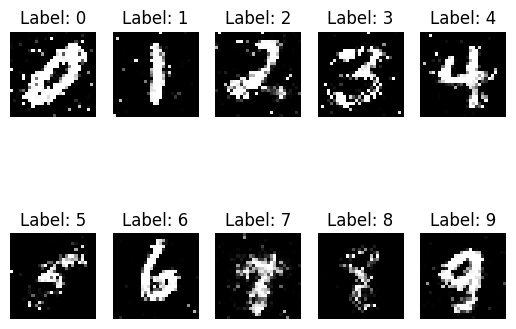

1/1 [==============================] - 0s 24ms/step
11601 [Discriminator loss: 0.692702, acc.: 67.19%] [Generator loss: 0.827390]
1/1 [==============================] - 0s 26ms/step
11602 [Discriminator loss: 0.687027, acc.: 48.44%] [Generator loss: 0.786905]
1/1 [==============================] - 0s 23ms/step
11603 [Discriminator loss: 0.616048, acc.: 59.38%] [Generator loss: 0.809363]
1/1 [==============================] - 0s 24ms/step
11604 [Discriminator loss: 0.663625, acc.: 57.81%] [Generator loss: 0.766474]
1/1 [==============================] - 0s 35ms/step
11605 [Discriminator loss: 0.673108, acc.: 51.56%] [Generator loss: 0.868360]
1/1 [==============================] - 0s 23ms/step
11606 [Discriminator loss: 0.684604, acc.: 50.00%] [Generator loss: 0.809309]
1/1 [==============================] - 0s 23ms/step
11607 [Discriminator loss: 0.625103, acc.: 65.62%] [Generator loss: 0.907015]
1/1 [==============================] - 0s 30ms/step
11608 [Discriminator loss: 0.607637, a

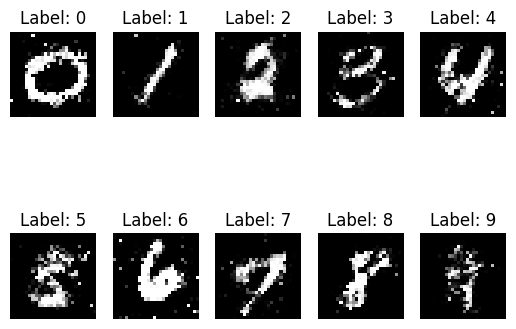

1/1 [==============================] - 0s 24ms/step
11701 [Discriminator loss: 0.684286, acc.: 56.25%] [Generator loss: 0.890609]
1/1 [==============================] - 0s 24ms/step
11702 [Discriminator loss: 0.635342, acc.: 59.38%] [Generator loss: 0.880440]
1/1 [==============================] - 0s 24ms/step
11703 [Discriminator loss: 0.626108, acc.: 64.06%] [Generator loss: 0.862113]
1/1 [==============================] - 0s 34ms/step
11704 [Discriminator loss: 0.701438, acc.: 56.25%] [Generator loss: 0.868144]
1/1 [==============================] - 0s 23ms/step
11705 [Discriminator loss: 0.663091, acc.: 54.69%] [Generator loss: 0.870051]
1/1 [==============================] - 0s 29ms/step
11706 [Discriminator loss: 0.622601, acc.: 60.94%] [Generator loss: 0.862252]
1/1 [==============================] - 0s 23ms/step
11707 [Discriminator loss: 0.637676, acc.: 65.62%] [Generator loss: 0.842840]
1/1 [==============================] - 0s 26ms/step
11708 [Discriminator loss: 0.700592, a

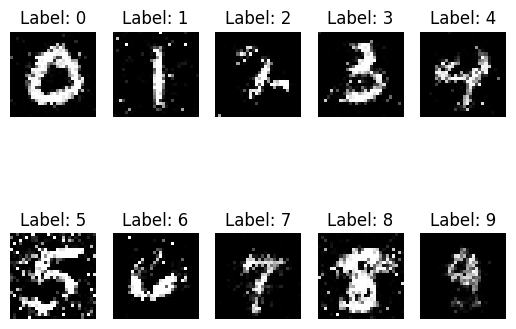

1/1 [==============================] - 0s 30ms/step
11801 [Discriminator loss: 0.650776, acc.: 54.69%] [Generator loss: 0.762887]
1/1 [==============================] - 0s 27ms/step
11802 [Discriminator loss: 0.683229, acc.: 59.38%] [Generator loss: 0.770512]
1/1 [==============================] - 0s 37ms/step
11803 [Discriminator loss: 0.649819, acc.: 59.38%] [Generator loss: 0.837808]
1/1 [==============================] - 0s 33ms/step
11804 [Discriminator loss: 0.644903, acc.: 65.62%] [Generator loss: 0.804562]
1/1 [==============================] - 0s 28ms/step
11805 [Discriminator loss: 0.642804, acc.: 60.94%] [Generator loss: 0.791250]
1/1 [==============================] - 0s 27ms/step
11806 [Discriminator loss: 0.651592, acc.: 73.44%] [Generator loss: 0.743198]
1/1 [==============================] - 0s 31ms/step
11807 [Discriminator loss: 0.618907, acc.: 79.69%] [Generator loss: 0.790034]
1/1 [==============================] - 0s 28ms/step
11808 [Discriminator loss: 0.719241, a

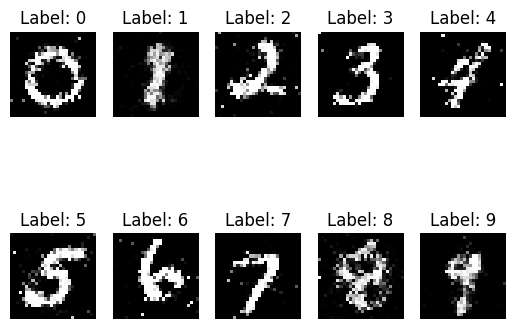

1/1 [==============================] - 0s 24ms/step
11901 [Discriminator loss: 0.642532, acc.: 59.38%] [Generator loss: 0.762821]
1/1 [==============================] - 0s 24ms/step
11902 [Discriminator loss: 0.696235, acc.: 48.44%] [Generator loss: 0.803559]
1/1 [==============================] - 0s 23ms/step
11903 [Discriminator loss: 0.648153, acc.: 65.62%] [Generator loss: 0.872740]
1/1 [==============================] - 0s 27ms/step
11904 [Discriminator loss: 0.637524, acc.: 60.94%] [Generator loss: 0.778913]
1/1 [==============================] - 0s 24ms/step
11905 [Discriminator loss: 0.653392, acc.: 65.62%] [Generator loss: 0.840218]
1/1 [==============================] - 0s 22ms/step
11906 [Discriminator loss: 0.673815, acc.: 51.56%] [Generator loss: 0.824635]
1/1 [==============================] - 0s 36ms/step
11907 [Discriminator loss: 0.685317, acc.: 54.69%] [Generator loss: 0.840521]
1/1 [==============================] - 0s 24ms/step
11908 [Discriminator loss: 0.671641, a

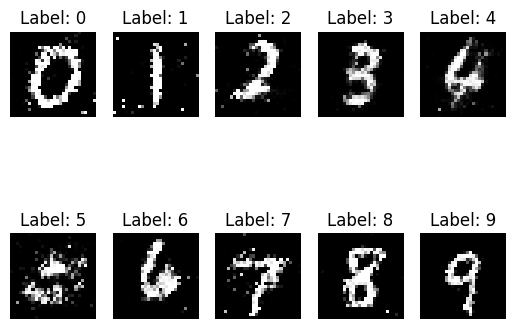

1/1 [==============================] - 0s 24ms/step
12001 [Discriminator loss: 0.662478, acc.: 62.50%] [Generator loss: 0.780955]
1/1 [==============================] - 0s 36ms/step
12002 [Discriminator loss: 0.675354, acc.: 57.81%] [Generator loss: 0.823507]
1/1 [==============================] - 0s 25ms/step
12003 [Discriminator loss: 0.680182, acc.: 51.56%] [Generator loss: 0.808198]
1/1 [==============================] - 0s 23ms/step
12004 [Discriminator loss: 0.655948, acc.: 64.06%] [Generator loss: 0.800431]
1/1 [==============================] - 0s 29ms/step
12005 [Discriminator loss: 0.681350, acc.: 54.69%] [Generator loss: 0.809402]
1/1 [==============================] - 0s 24ms/step
12006 [Discriminator loss: 0.667274, acc.: 54.69%] [Generator loss: 0.788736]
1/1 [==============================] - 0s 26ms/step
12007 [Discriminator loss: 0.692843, acc.: 64.06%] [Generator loss: 0.781223]
1/1 [==============================] - 0s 26ms/step
12008 [Discriminator loss: 0.654848, a

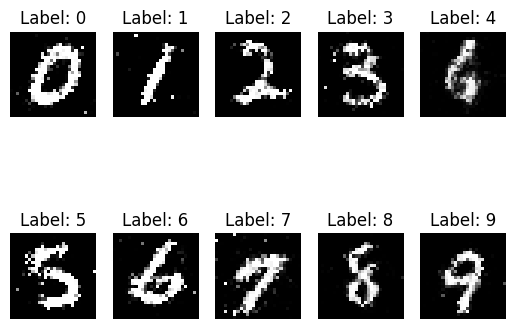

1/1 [==============================] - 0s 24ms/step
12101 [Discriminator loss: 0.691644, acc.: 48.44%] [Generator loss: 0.803652]
1/1 [==============================] - 0s 22ms/step
12102 [Discriminator loss: 0.629730, acc.: 62.50%] [Generator loss: 0.873236]
1/1 [==============================] - 0s 25ms/step
12103 [Discriminator loss: 0.676810, acc.: 53.12%] [Generator loss: 0.819272]
1/1 [==============================] - 0s 23ms/step
12104 [Discriminator loss: 0.673225, acc.: 54.69%] [Generator loss: 0.740674]
1/1 [==============================] - 0s 22ms/step
12105 [Discriminator loss: 0.696636, acc.: 53.12%] [Generator loss: 0.847711]
1/1 [==============================] - 0s 27ms/step
12106 [Discriminator loss: 0.706276, acc.: 57.81%] [Generator loss: 0.838179]
1/1 [==============================] - 0s 22ms/step
12107 [Discriminator loss: 0.623190, acc.: 64.06%] [Generator loss: 0.801548]
1/1 [==============================] - 0s 23ms/step
12108 [Discriminator loss: 0.697614, a

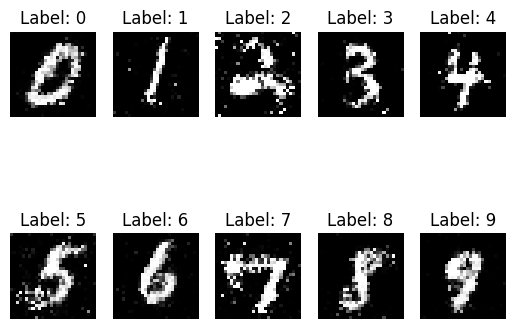

1/1 [==============================] - 0s 32ms/step
12201 [Discriminator loss: 0.623020, acc.: 68.75%] [Generator loss: 0.790423]
1/1 [==============================] - 0s 28ms/step
12202 [Discriminator loss: 0.643936, acc.: 64.06%] [Generator loss: 0.802224]
1/1 [==============================] - 0s 29ms/step
12203 [Discriminator loss: 0.685810, acc.: 51.56%] [Generator loss: 0.868163]
1/1 [==============================] - 0s 38ms/step
12204 [Discriminator loss: 0.654407, acc.: 57.81%] [Generator loss: 0.818531]
1/1 [==============================] - 0s 31ms/step
12205 [Discriminator loss: 0.618038, acc.: 65.62%] [Generator loss: 0.878292]
1/1 [==============================] - 0s 30ms/step
12206 [Discriminator loss: 0.662395, acc.: 56.25%] [Generator loss: 0.833843]
1/1 [==============================] - 0s 27ms/step
12207 [Discriminator loss: 0.605853, acc.: 56.25%] [Generator loss: 0.806012]
1/1 [==============================] - 0s 28ms/step
12208 [Discriminator loss: 0.661644, a

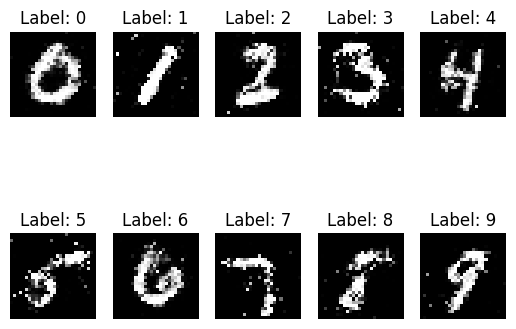

1/1 [==============================] - 0s 26ms/step
12301 [Discriminator loss: 0.675506, acc.: 51.56%] [Generator loss: 0.863728]
1/1 [==============================] - 0s 24ms/step
12302 [Discriminator loss: 0.697461, acc.: 51.56%] [Generator loss: 0.870834]
1/1 [==============================] - 0s 23ms/step
12303 [Discriminator loss: 0.665137, acc.: 64.06%] [Generator loss: 0.893014]
1/1 [==============================] - 0s 23ms/step
12304 [Discriminator loss: 0.675034, acc.: 56.25%] [Generator loss: 0.885094]
1/1 [==============================] - 0s 24ms/step
12305 [Discriminator loss: 0.679179, acc.: 50.00%] [Generator loss: 0.831519]
1/1 [==============================] - 0s 24ms/step
12306 [Discriminator loss: 0.653315, acc.: 53.12%] [Generator loss: 0.824174]
1/1 [==============================] - 0s 28ms/step
12307 [Discriminator loss: 0.653865, acc.: 56.25%] [Generator loss: 0.866705]
1/1 [==============================] - 0s 24ms/step
12308 [Discriminator loss: 0.647898, a

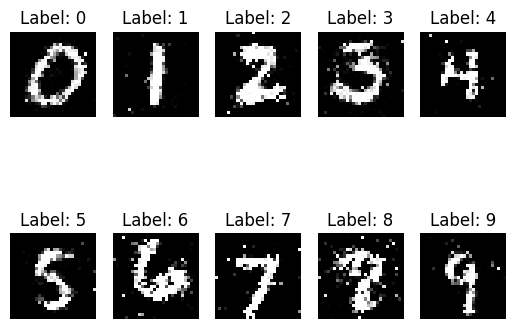

1/1 [==============================] - 0s 36ms/step
12401 [Discriminator loss: 0.668119, acc.: 62.50%] [Generator loss: 0.769687]
1/1 [==============================] - 0s 25ms/step
12402 [Discriminator loss: 0.675214, acc.: 59.38%] [Generator loss: 0.844403]
1/1 [==============================] - 0s 24ms/step
12403 [Discriminator loss: 0.668231, acc.: 50.00%] [Generator loss: 0.838461]
1/1 [==============================] - 0s 24ms/step
12404 [Discriminator loss: 0.673720, acc.: 56.25%] [Generator loss: 0.797319]
1/1 [==============================] - 0s 25ms/step
12405 [Discriminator loss: 0.658791, acc.: 62.50%] [Generator loss: 0.817589]
1/1 [==============================] - 0s 24ms/step
12406 [Discriminator loss: 0.669811, acc.: 64.06%] [Generator loss: 0.812050]
1/1 [==============================] - 0s 24ms/step
12407 [Discriminator loss: 0.665526, acc.: 56.25%] [Generator loss: 0.789391]
1/1 [==============================] - 0s 25ms/step
12408 [Discriminator loss: 0.673285, a

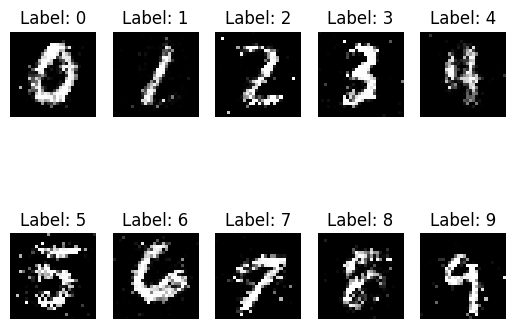

1/1 [==============================] - 0s 35ms/step
12501 [Discriminator loss: 0.713140, acc.: 56.25%] [Generator loss: 0.845109]
1/1 [==============================] - 0s 26ms/step
12502 [Discriminator loss: 0.698723, acc.: 54.69%] [Generator loss: 0.748218]
1/1 [==============================] - 0s 23ms/step
12503 [Discriminator loss: 0.664442, acc.: 57.81%] [Generator loss: 0.811678]
1/1 [==============================] - 0s 28ms/step
12504 [Discriminator loss: 0.689456, acc.: 48.44%] [Generator loss: 0.803884]
1/1 [==============================] - 0s 27ms/step
12505 [Discriminator loss: 0.651225, acc.: 64.06%] [Generator loss: 0.811812]
1/1 [==============================] - 0s 23ms/step
12506 [Discriminator loss: 0.696971, acc.: 56.25%] [Generator loss: 0.882179]
1/1 [==============================] - 0s 24ms/step
12507 [Discriminator loss: 0.654356, acc.: 56.25%] [Generator loss: 0.849368]
1/1 [==============================] - 0s 23ms/step
12508 [Discriminator loss: 0.649029, a

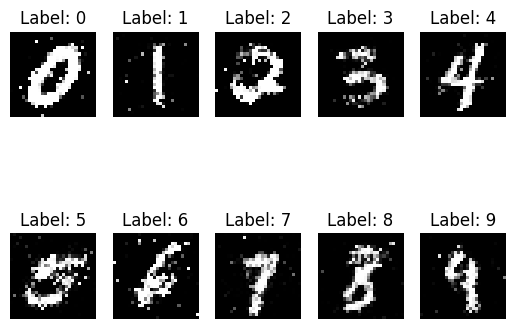

1/1 [==============================] - 0s 29ms/step
12601 [Discriminator loss: 0.640870, acc.: 68.75%] [Generator loss: 0.785174]
1/1 [==============================] - 0s 28ms/step
12602 [Discriminator loss: 0.660130, acc.: 54.69%] [Generator loss: 0.840868]
1/1 [==============================] - 0s 30ms/step
12603 [Discriminator loss: 0.636315, acc.: 62.50%] [Generator loss: 0.848796]
1/1 [==============================] - 0s 35ms/step
12604 [Discriminator loss: 0.676859, acc.: 56.25%] [Generator loss: 0.767940]
1/1 [==============================] - 0s 27ms/step
12605 [Discriminator loss: 0.665235, acc.: 57.81%] [Generator loss: 0.795052]
1/1 [==============================] - 0s 28ms/step
12606 [Discriminator loss: 0.701865, acc.: 53.12%] [Generator loss: 0.766261]
1/1 [==============================] - 0s 26ms/step
12607 [Discriminator loss: 0.648703, acc.: 62.50%] [Generator loss: 0.822503]
1/1 [==============================] - 0s 27ms/step
12608 [Discriminator loss: 0.687306, a

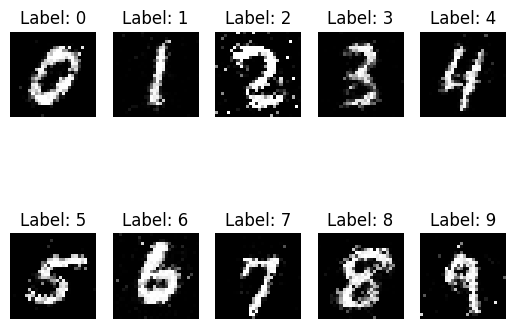

1/1 [==============================] - 0s 25ms/step
12701 [Discriminator loss: 0.676175, acc.: 43.75%] [Generator loss: 0.843198]
1/1 [==============================] - 0s 23ms/step
12702 [Discriminator loss: 0.662897, acc.: 54.69%] [Generator loss: 0.817018]
1/1 [==============================] - 0s 23ms/step
12703 [Discriminator loss: 0.657962, acc.: 56.25%] [Generator loss: 0.840460]
1/1 [==============================] - 0s 24ms/step
12704 [Discriminator loss: 0.630526, acc.: 60.94%] [Generator loss: 0.804460]
1/1 [==============================] - 0s 23ms/step
12705 [Discriminator loss: 0.699307, acc.: 56.25%] [Generator loss: 0.840584]
1/1 [==============================] - 0s 24ms/step
12706 [Discriminator loss: 0.695104, acc.: 42.19%] [Generator loss: 0.831240]
1/1 [==============================] - 0s 24ms/step
12707 [Discriminator loss: 0.654108, acc.: 64.06%] [Generator loss: 0.835846]
1/1 [==============================] - 0s 28ms/step
12708 [Discriminator loss: 0.658839, a

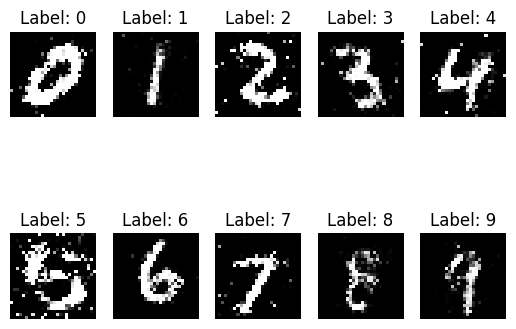

1/1 [==============================] - 0s 24ms/step
12801 [Discriminator loss: 0.644823, acc.: 60.94%] [Generator loss: 0.869528]
1/1 [==============================] - 0s 24ms/step
12802 [Discriminator loss: 0.608144, acc.: 67.19%] [Generator loss: 0.813919]
1/1 [==============================] - 0s 27ms/step
12803 [Discriminator loss: 0.613111, acc.: 64.06%] [Generator loss: 0.816908]
1/1 [==============================] - 0s 27ms/step
12804 [Discriminator loss: 0.641807, acc.: 57.81%] [Generator loss: 0.797329]
1/1 [==============================] - 0s 23ms/step
12805 [Discriminator loss: 0.697927, acc.: 51.56%] [Generator loss: 0.811768]
1/1 [==============================] - 0s 22ms/step
12806 [Discriminator loss: 0.702343, acc.: 56.25%] [Generator loss: 0.788619]
1/1 [==============================] - 0s 23ms/step
12807 [Discriminator loss: 0.636221, acc.: 60.94%] [Generator loss: 0.855528]
1/1 [==============================] - 0s 23ms/step
12808 [Discriminator loss: 0.667311, a

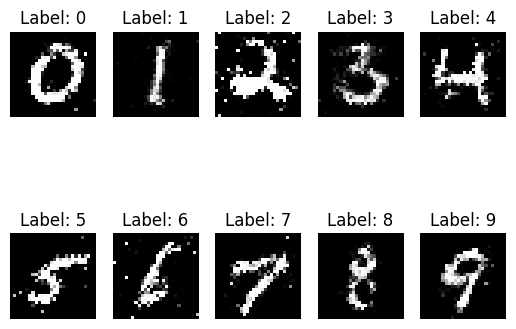

1/1 [==============================] - 0s 41ms/step
12901 [Discriminator loss: 0.632358, acc.: 60.94%] [Generator loss: 0.867281]
1/1 [==============================] - 0s 25ms/step
12902 [Discriminator loss: 0.699948, acc.: 56.25%] [Generator loss: 0.855117]
1/1 [==============================] - 0s 25ms/step
12903 [Discriminator loss: 0.676904, acc.: 53.12%] [Generator loss: 0.868138]
1/1 [==============================] - 0s 32ms/step
12904 [Discriminator loss: 0.650652, acc.: 62.50%] [Generator loss: 0.845969]
1/1 [==============================] - 0s 24ms/step
12905 [Discriminator loss: 0.674423, acc.: 59.38%] [Generator loss: 0.837418]
1/1 [==============================] - 0s 25ms/step
12906 [Discriminator loss: 0.651815, acc.: 53.12%] [Generator loss: 0.857900]
1/1 [==============================] - 0s 23ms/step
12907 [Discriminator loss: 0.663805, acc.: 60.94%] [Generator loss: 0.880707]
1/1 [==============================] - 0s 31ms/step
12908 [Discriminator loss: 0.674950, a

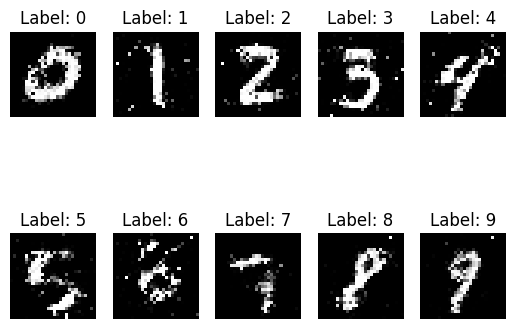

1/1 [==============================] - 0s 28ms/step
13001 [Discriminator loss: 0.639940, acc.: 65.62%] [Generator loss: 0.804978]
1/1 [==============================] - 0s 30ms/step
13002 [Discriminator loss: 0.660445, acc.: 60.94%] [Generator loss: 0.757377]
1/1 [==============================] - 0s 27ms/step
13003 [Discriminator loss: 0.679572, acc.: 50.00%] [Generator loss: 0.988136]
1/1 [==============================] - 0s 29ms/step
13004 [Discriminator loss: 0.678074, acc.: 59.38%] [Generator loss: 0.837283]
1/1 [==============================] - 0s 25ms/step
13005 [Discriminator loss: 0.618139, acc.: 60.94%] [Generator loss: 0.828293]
1/1 [==============================] - 0s 34ms/step
13006 [Discriminator loss: 0.641615, acc.: 60.94%] [Generator loss: 0.818656]
1/1 [==============================] - 0s 31ms/step
13007 [Discriminator loss: 0.664019, acc.: 57.81%] [Generator loss: 0.767291]
1/1 [==============================] - 0s 27ms/step
13008 [Discriminator loss: 0.686992, a

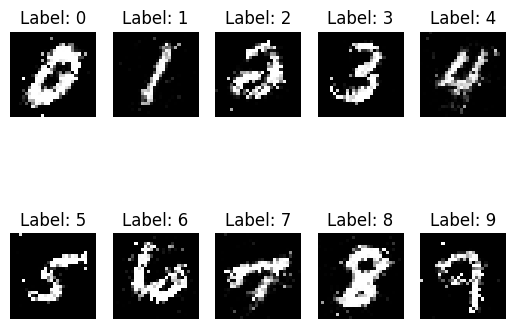

1/1 [==============================] - 0s 26ms/step
13101 [Discriminator loss: 0.676104, acc.: 53.12%] [Generator loss: 0.864930]
1/1 [==============================] - 0s 27ms/step
13102 [Discriminator loss: 0.601537, acc.: 67.19%] [Generator loss: 0.825290]
1/1 [==============================] - 0s 26ms/step
13103 [Discriminator loss: 0.703912, acc.: 53.12%] [Generator loss: 0.853895]
1/1 [==============================] - 0s 24ms/step
13104 [Discriminator loss: 0.590232, acc.: 70.31%] [Generator loss: 0.812447]
1/1 [==============================] - 0s 23ms/step
13105 [Discriminator loss: 0.621180, acc.: 60.94%] [Generator loss: 0.830276]
1/1 [==============================] - 0s 30ms/step
13106 [Discriminator loss: 0.658172, acc.: 59.38%] [Generator loss: 0.820883]
1/1 [==============================] - 0s 24ms/step
13107 [Discriminator loss: 0.672198, acc.: 56.25%] [Generator loss: 0.884752]
1/1 [==============================] - 0s 23ms/step
13108 [Discriminator loss: 0.648773, a

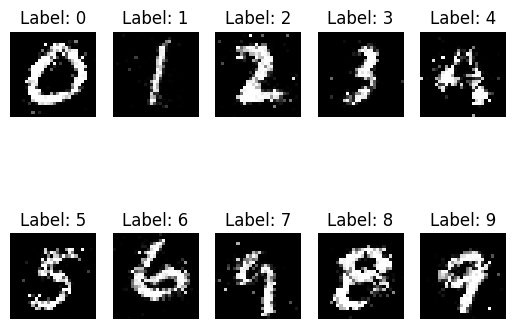

1/1 [==============================] - 0s 24ms/step
13201 [Discriminator loss: 0.641331, acc.: 53.12%] [Generator loss: 0.868512]
1/1 [==============================] - 0s 23ms/step
13202 [Discriminator loss: 0.710688, acc.: 51.56%] [Generator loss: 0.817951]
1/1 [==============================] - 0s 28ms/step
13203 [Discriminator loss: 0.662119, acc.: 51.56%] [Generator loss: 0.841784]
1/1 [==============================] - 0s 23ms/step
13204 [Discriminator loss: 0.632883, acc.: 57.81%] [Generator loss: 0.819223]
1/1 [==============================] - 0s 23ms/step
13205 [Discriminator loss: 0.676537, acc.: 56.25%] [Generator loss: 0.861404]
1/1 [==============================] - 0s 25ms/step
13206 [Discriminator loss: 0.682108, acc.: 50.00%] [Generator loss: 0.887298]
1/1 [==============================] - 0s 35ms/step
13207 [Discriminator loss: 0.680922, acc.: 60.94%] [Generator loss: 0.810200]
1/1 [==============================] - 0s 22ms/step
13208 [Discriminator loss: 0.654702, a

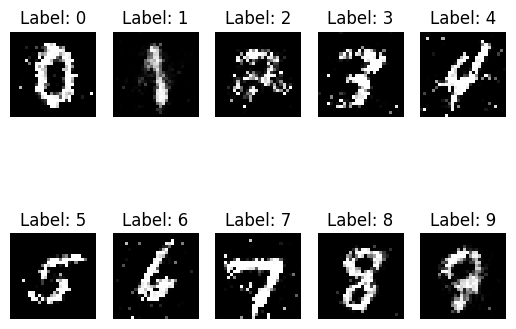

1/1 [==============================] - 0s 25ms/step
13301 [Discriminator loss: 0.623621, acc.: 67.19%] [Generator loss: 0.805085]
1/1 [==============================] - 0s 26ms/step
13302 [Discriminator loss: 0.706188, acc.: 46.88%] [Generator loss: 0.910485]
1/1 [==============================] - 0s 23ms/step
13303 [Discriminator loss: 0.680428, acc.: 53.12%] [Generator loss: 0.787797]
1/1 [==============================] - 0s 25ms/step
13304 [Discriminator loss: 0.688541, acc.: 60.94%] [Generator loss: 0.861176]
1/1 [==============================] - 0s 38ms/step
13305 [Discriminator loss: 0.649343, acc.: 60.94%] [Generator loss: 0.837966]
1/1 [==============================] - 0s 29ms/step
13306 [Discriminator loss: 0.709419, acc.: 56.25%] [Generator loss: 0.858305]
1/1 [==============================] - 0s 31ms/step
13307 [Discriminator loss: 0.670846, acc.: 54.69%] [Generator loss: 0.802203]
1/1 [==============================] - 0s 30ms/step
13308 [Discriminator loss: 0.666644, a

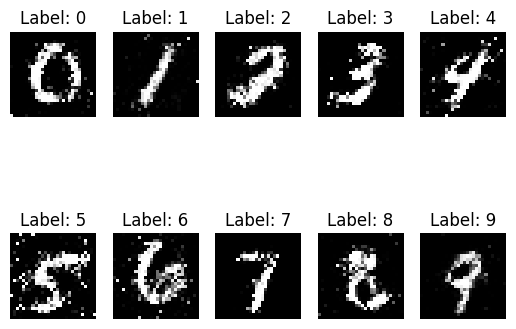

1/1 [==============================] - 0s 24ms/step
13401 [Discriminator loss: 0.680793, acc.: 54.69%] [Generator loss: 0.865816]
1/1 [==============================] - 0s 25ms/step
13402 [Discriminator loss: 0.634349, acc.: 57.81%] [Generator loss: 0.816663]
1/1 [==============================] - 0s 25ms/step
13403 [Discriminator loss: 0.662104, acc.: 51.56%] [Generator loss: 0.780447]
1/1 [==============================] - 0s 23ms/step
13404 [Discriminator loss: 0.656967, acc.: 57.81%] [Generator loss: 0.879106]
1/1 [==============================] - 0s 24ms/step
13405 [Discriminator loss: 0.654503, acc.: 56.25%] [Generator loss: 0.809447]
1/1 [==============================] - 0s 23ms/step
13406 [Discriminator loss: 0.673730, acc.: 53.12%] [Generator loss: 0.838753]
1/1 [==============================] - 0s 25ms/step
13407 [Discriminator loss: 0.646773, acc.: 60.94%] [Generator loss: 0.810111]
1/1 [==============================] - 0s 25ms/step
13408 [Discriminator loss: 0.556612, a

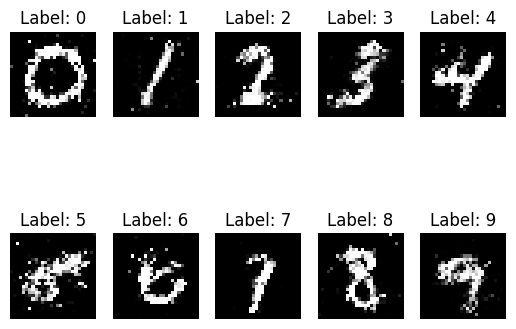

1/1 [==============================] - 0s 27ms/step
13501 [Discriminator loss: 0.646792, acc.: 54.69%] [Generator loss: 0.958817]
1/1 [==============================] - 0s 23ms/step
13502 [Discriminator loss: 0.661676, acc.: 56.25%] [Generator loss: 0.910995]
1/1 [==============================] - 0s 25ms/step
13503 [Discriminator loss: 0.691088, acc.: 54.69%] [Generator loss: 0.856653]
1/1 [==============================] - 0s 25ms/step
13504 [Discriminator loss: 0.678003, acc.: 62.50%] [Generator loss: 0.796242]
1/1 [==============================] - 0s 28ms/step
13505 [Discriminator loss: 0.693459, acc.: 45.31%] [Generator loss: 0.854153]
1/1 [==============================] - 0s 28ms/step
13506 [Discriminator loss: 0.671420, acc.: 56.25%] [Generator loss: 0.841587]
1/1 [==============================] - 0s 23ms/step
13507 [Discriminator loss: 0.619893, acc.: 60.94%] [Generator loss: 0.886702]
1/1 [==============================] - 0s 25ms/step
13508 [Discriminator loss: 0.656131, a

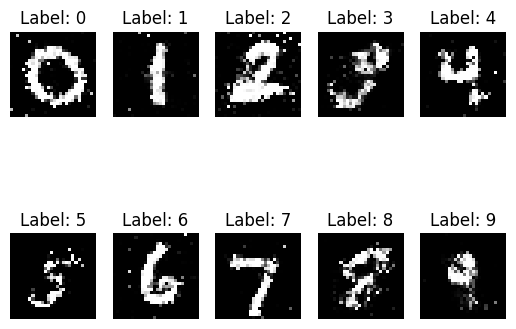

1/1 [==============================] - 0s 35ms/step
13601 [Discriminator loss: 0.680214, acc.: 50.00%] [Generator loss: 0.917342]
1/1 [==============================] - 0s 30ms/step
13602 [Discriminator loss: 0.670778, acc.: 54.69%] [Generator loss: 0.874656]
1/1 [==============================] - 0s 24ms/step
13603 [Discriminator loss: 0.661058, acc.: 54.69%] [Generator loss: 0.834147]
1/1 [==============================] - 0s 25ms/step
13604 [Discriminator loss: 0.654065, acc.: 62.50%] [Generator loss: 0.898267]
1/1 [==============================] - 0s 23ms/step
13605 [Discriminator loss: 0.660691, acc.: 59.38%] [Generator loss: 0.787948]
1/1 [==============================] - 0s 23ms/step
13606 [Discriminator loss: 0.626843, acc.: 67.19%] [Generator loss: 0.873855]
1/1 [==============================] - 0s 26ms/step
13607 [Discriminator loss: 0.653816, acc.: 59.38%] [Generator loss: 0.783860]
1/1 [==============================] - 0s 24ms/step
13608 [Discriminator loss: 0.671872, a

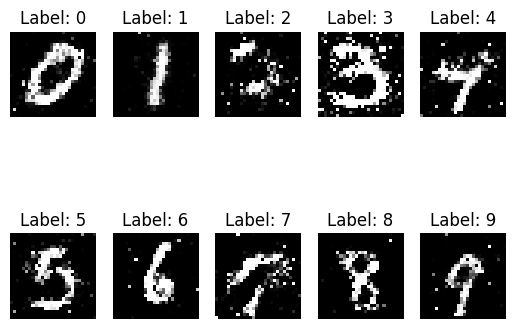

1/1 [==============================] - 0s 31ms/step
13701 [Discriminator loss: 0.646762, acc.: 62.50%] [Generator loss: 0.791551]
1/1 [==============================] - 0s 31ms/step
13702 [Discriminator loss: 0.566964, acc.: 75.00%] [Generator loss: 0.841972]
1/1 [==============================] - 0s 31ms/step
13703 [Discriminator loss: 0.679793, acc.: 56.25%] [Generator loss: 0.844731]
1/1 [==============================] - 0s 28ms/step
13704 [Discriminator loss: 0.633130, acc.: 62.50%] [Generator loss: 0.798471]
1/1 [==============================] - 0s 28ms/step
13705 [Discriminator loss: 0.698910, acc.: 56.25%] [Generator loss: 0.813573]
1/1 [==============================] - 0s 27ms/step
13706 [Discriminator loss: 0.661216, acc.: 59.38%] [Generator loss: 0.760990]
1/1 [==============================] - 0s 28ms/step
13707 [Discriminator loss: 0.656055, acc.: 60.94%] [Generator loss: 0.777430]
1/1 [==============================] - 0s 26ms/step
13708 [Discriminator loss: 0.676708, a

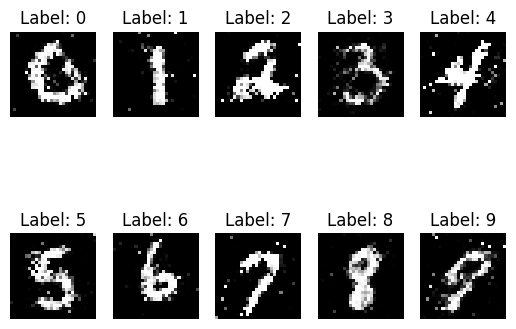

1/1 [==============================] - 0s 25ms/step
13801 [Discriminator loss: 0.617808, acc.: 67.19%] [Generator loss: 0.854997]
1/1 [==============================] - 0s 23ms/step
13802 [Discriminator loss: 0.714763, acc.: 54.69%] [Generator loss: 0.847155]
1/1 [==============================] - 0s 24ms/step
13803 [Discriminator loss: 0.648156, acc.: 56.25%] [Generator loss: 0.795916]
1/1 [==============================] - 0s 30ms/step
13804 [Discriminator loss: 0.629068, acc.: 70.31%] [Generator loss: 0.867505]
1/1 [==============================] - 0s 23ms/step
13805 [Discriminator loss: 0.622124, acc.: 65.62%] [Generator loss: 0.848025]
1/1 [==============================] - 0s 25ms/step
13806 [Discriminator loss: 0.633194, acc.: 64.06%] [Generator loss: 0.906023]
1/1 [==============================] - 0s 32ms/step
13807 [Discriminator loss: 0.649256, acc.: 60.94%] [Generator loss: 0.907337]
1/1 [==============================] - 0s 24ms/step
13808 [Discriminator loss: 0.642082, a

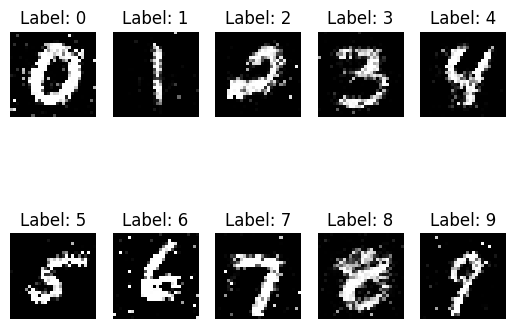

1/1 [==============================] - 0s 24ms/step
13901 [Discriminator loss: 0.585906, acc.: 68.75%] [Generator loss: 0.793142]
1/1 [==============================] - 0s 25ms/step
13902 [Discriminator loss: 0.675372, acc.: 56.25%] [Generator loss: 0.788769]
1/1 [==============================] - 0s 24ms/step
13903 [Discriminator loss: 0.627512, acc.: 56.25%] [Generator loss: 0.796253]
1/1 [==============================] - 0s 24ms/step
13904 [Discriminator loss: 0.680186, acc.: 60.94%] [Generator loss: 0.867629]
1/1 [==============================] - 0s 35ms/step
13905 [Discriminator loss: 0.689669, acc.: 54.69%] [Generator loss: 0.841378]
1/1 [==============================] - 0s 27ms/step
13906 [Discriminator loss: 0.638318, acc.: 57.81%] [Generator loss: 0.865863]
1/1 [==============================] - 0s 25ms/step
13907 [Discriminator loss: 0.605574, acc.: 64.06%] [Generator loss: 0.919015]
1/1 [==============================] - 0s 29ms/step
13908 [Discriminator loss: 0.707455, a

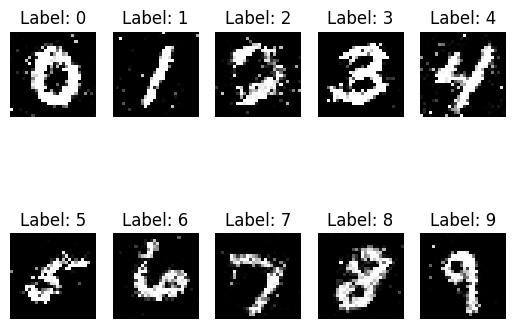

1/1 [==============================] - 0s 25ms/step
14001 [Discriminator loss: 0.664165, acc.: 50.00%] [Generator loss: 0.866441]
1/1 [==============================] - 0s 24ms/step
14002 [Discriminator loss: 0.651091, acc.: 59.38%] [Generator loss: 0.838482]
1/1 [==============================] - 0s 34ms/step
14003 [Discriminator loss: 0.621161, acc.: 60.94%] [Generator loss: 0.876167]
1/1 [==============================] - 0s 24ms/step
14004 [Discriminator loss: 0.660326, acc.: 50.00%] [Generator loss: 0.786903]
1/1 [==============================] - 0s 24ms/step
14005 [Discriminator loss: 0.657135, acc.: 59.38%] [Generator loss: 0.776132]
1/1 [==============================] - 0s 23ms/step
14006 [Discriminator loss: 0.688920, acc.: 59.38%] [Generator loss: 0.865642]
1/1 [==============================] - 0s 26ms/step
14007 [Discriminator loss: 0.647608, acc.: 59.38%] [Generator loss: 0.773581]
1/1 [==============================] - 0s 32ms/step
14008 [Discriminator loss: 0.633765, a

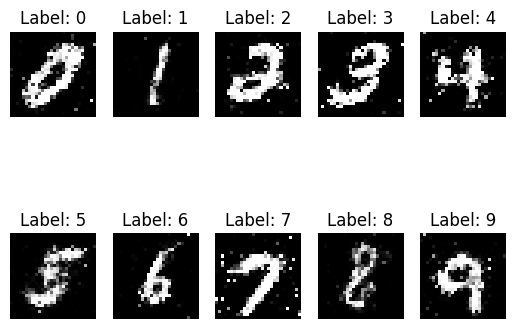

1/1 [==============================] - 0s 41ms/step
14101 [Discriminator loss: 0.638509, acc.: 68.75%] [Generator loss: 0.809170]
1/1 [==============================] - 0s 29ms/step
14102 [Discriminator loss: 0.673809, acc.: 51.56%] [Generator loss: 0.837064]
1/1 [==============================] - 0s 29ms/step
14103 [Discriminator loss: 0.785864, acc.: 60.94%] [Generator loss: 0.877896]
1/1 [==============================] - 0s 38ms/step
14104 [Discriminator loss: 0.699261, acc.: 57.81%] [Generator loss: 0.867543]
1/1 [==============================] - 0s 39ms/step
14105 [Discriminator loss: 0.650182, acc.: 60.94%] [Generator loss: 0.804830]
1/1 [==============================] - 0s 28ms/step
14106 [Discriminator loss: 0.654372, acc.: 59.38%] [Generator loss: 0.869550]
1/1 [==============================] - 0s 29ms/step
14107 [Discriminator loss: 0.658033, acc.: 64.06%] [Generator loss: 0.769081]
1/1 [==============================] - 0s 28ms/step
14108 [Discriminator loss: 0.703871, a

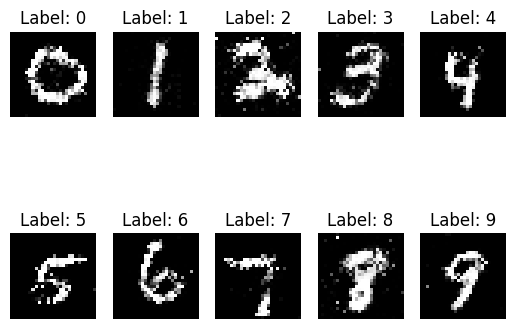

1/1 [==============================] - 0s 25ms/step
14201 [Discriminator loss: 0.646381, acc.: 64.06%] [Generator loss: 0.836574]
1/1 [==============================] - 0s 22ms/step
14202 [Discriminator loss: 0.638805, acc.: 51.56%] [Generator loss: 0.880957]
1/1 [==============================] - 0s 23ms/step
14203 [Discriminator loss: 0.723281, acc.: 46.88%] [Generator loss: 0.827096]
1/1 [==============================] - 0s 24ms/step
14204 [Discriminator loss: 0.660987, acc.: 54.69%] [Generator loss: 0.816291]
1/1 [==============================] - 0s 22ms/step
14205 [Discriminator loss: 0.632623, acc.: 56.25%] [Generator loss: 0.922928]
1/1 [==============================] - 0s 23ms/step
14206 [Discriminator loss: 0.651776, acc.: 56.25%] [Generator loss: 0.817936]
1/1 [==============================] - 0s 27ms/step
14207 [Discriminator loss: 0.665664, acc.: 59.38%] [Generator loss: 0.834768]
1/1 [==============================] - 0s 32ms/step
14208 [Discriminator loss: 0.638240, a

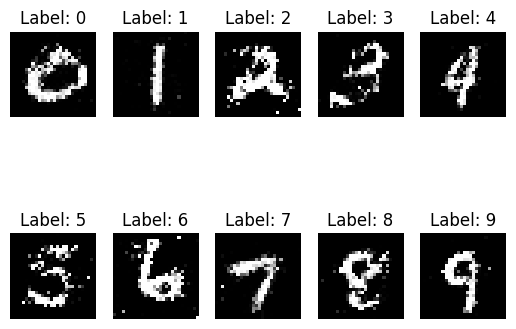

1/1 [==============================] - 0s 25ms/step
14301 [Discriminator loss: 0.660871, acc.: 62.50%] [Generator loss: 0.813436]
1/1 [==============================] - 0s 25ms/step
14302 [Discriminator loss: 0.708760, acc.: 50.00%] [Generator loss: 0.783449]
1/1 [==============================] - 0s 23ms/step
14303 [Discriminator loss: 0.648472, acc.: 60.94%] [Generator loss: 0.776129]
1/1 [==============================] - 0s 26ms/step
14304 [Discriminator loss: 0.657338, acc.: 57.81%] [Generator loss: 0.850651]
1/1 [==============================] - 0s 35ms/step
14305 [Discriminator loss: 0.631840, acc.: 60.94%] [Generator loss: 0.852112]
1/1 [==============================] - 0s 22ms/step
14306 [Discriminator loss: 0.642304, acc.: 59.38%] [Generator loss: 0.794043]
1/1 [==============================] - 0s 27ms/step
14307 [Discriminator loss: 0.666168, acc.: 56.25%] [Generator loss: 0.865942]
1/1 [==============================] - 0s 25ms/step
14308 [Discriminator loss: 0.647702, a

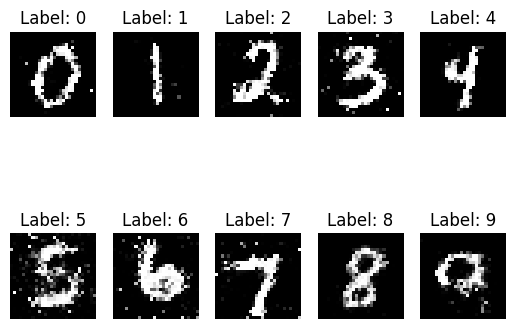

1/1 [==============================] - 0s 25ms/step
14401 [Discriminator loss: 0.664699, acc.: 57.81%] [Generator loss: 0.848159]
1/1 [==============================] - 0s 30ms/step
14402 [Discriminator loss: 0.683661, acc.: 51.56%] [Generator loss: 0.850716]
1/1 [==============================] - 0s 24ms/step
14403 [Discriminator loss: 0.675194, acc.: 60.94%] [Generator loss: 0.822194]
1/1 [==============================] - 0s 25ms/step
14404 [Discriminator loss: 0.679978, acc.: 50.00%] [Generator loss: 0.901647]
1/1 [==============================] - 0s 23ms/step
14405 [Discriminator loss: 0.703590, acc.: 42.19%] [Generator loss: 0.771713]
1/1 [==============================] - 0s 23ms/step
14406 [Discriminator loss: 0.655486, acc.: 57.81%] [Generator loss: 0.822260]
1/1 [==============================] - 0s 22ms/step
14407 [Discriminator loss: 0.684049, acc.: 51.56%] [Generator loss: 0.895423]
1/1 [==============================] - 0s 26ms/step
14408 [Discriminator loss: 0.661181, a

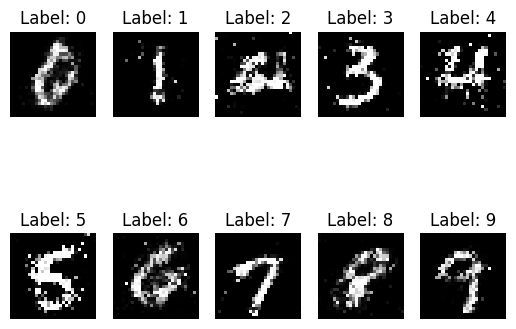

1/1 [==============================] - 0s 29ms/step
14501 [Discriminator loss: 0.678664, acc.: 59.38%] [Generator loss: 0.836857]
1/1 [==============================] - 0s 28ms/step
14502 [Discriminator loss: 0.621156, acc.: 64.06%] [Generator loss: 0.781544]
1/1 [==============================] - 0s 29ms/step
14503 [Discriminator loss: 0.687656, acc.: 60.94%] [Generator loss: 0.845311]
1/1 [==============================] - 0s 34ms/step
14504 [Discriminator loss: 0.642269, acc.: 64.06%] [Generator loss: 0.776723]
1/1 [==============================] - 0s 28ms/step
14505 [Discriminator loss: 0.674931, acc.: 59.38%] [Generator loss: 0.860525]
1/1 [==============================] - 0s 26ms/step
14506 [Discriminator loss: 0.725998, acc.: 50.00%] [Generator loss: 0.834116]
1/1 [==============================] - 0s 30ms/step
14507 [Discriminator loss: 0.673596, acc.: 56.25%] [Generator loss: 0.907584]
1/1 [==============================] - 0s 31ms/step
14508 [Discriminator loss: 0.671051, a

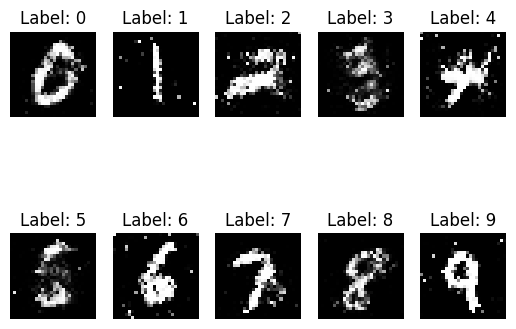

1/1 [==============================] - 0s 24ms/step
14601 [Discriminator loss: 0.652091, acc.: 59.38%] [Generator loss: 0.891893]
1/1 [==============================] - 0s 32ms/step
14602 [Discriminator loss: 0.723914, acc.: 54.69%] [Generator loss: 0.892866]
1/1 [==============================] - 0s 28ms/step
14603 [Discriminator loss: 0.659518, acc.: 54.69%] [Generator loss: 0.864222]
1/1 [==============================] - 0s 22ms/step
14604 [Discriminator loss: 0.682314, acc.: 54.69%] [Generator loss: 0.787170]
1/1 [==============================] - 0s 24ms/step
14605 [Discriminator loss: 0.634666, acc.: 56.25%] [Generator loss: 0.861369]
1/1 [==============================] - 0s 26ms/step
14606 [Discriminator loss: 0.639793, acc.: 65.62%] [Generator loss: 0.872728]
1/1 [==============================] - 0s 29ms/step
14607 [Discriminator loss: 0.626563, acc.: 70.31%] [Generator loss: 0.806175]
1/1 [==============================] - 0s 25ms/step
14608 [Discriminator loss: 0.675888, a

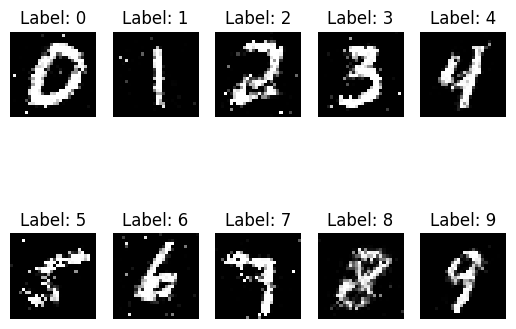

1/1 [==============================] - 0s 25ms/step
14701 [Discriminator loss: 0.714026, acc.: 54.69%] [Generator loss: 0.778393]
1/1 [==============================] - 0s 25ms/step
14702 [Discriminator loss: 0.734402, acc.: 53.12%] [Generator loss: 0.743538]
1/1 [==============================] - 0s 23ms/step
14703 [Discriminator loss: 0.634311, acc.: 53.12%] [Generator loss: 0.799998]
1/1 [==============================] - 0s 28ms/step
14704 [Discriminator loss: 0.655107, acc.: 57.81%] [Generator loss: 0.883215]
1/1 [==============================] - 0s 23ms/step
14705 [Discriminator loss: 0.715686, acc.: 43.75%] [Generator loss: 0.827517]
1/1 [==============================] - 0s 39ms/step
14706 [Discriminator loss: 0.656610, acc.: 57.81%] [Generator loss: 0.792321]
1/1 [==============================] - 0s 34ms/step
14707 [Discriminator loss: 0.651154, acc.: 59.38%] [Generator loss: 0.893398]
1/1 [==============================] - 0s 26ms/step
14708 [Discriminator loss: 0.629681, a

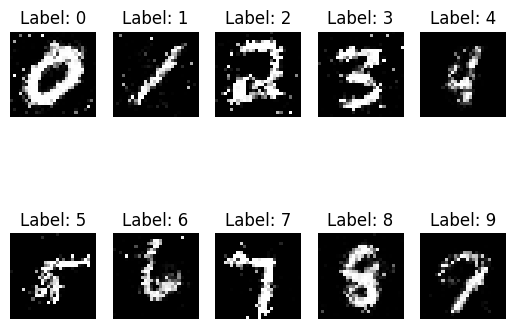

1/1 [==============================] - 0s 27ms/step
14801 [Discriminator loss: 0.654204, acc.: 62.50%] [Generator loss: 0.764143]
1/1 [==============================] - 0s 24ms/step
14802 [Discriminator loss: 0.685155, acc.: 57.81%] [Generator loss: 0.828548]
1/1 [==============================] - 0s 27ms/step
14803 [Discriminator loss: 0.639676, acc.: 64.06%] [Generator loss: 0.840084]
1/1 [==============================] - 0s 28ms/step
14804 [Discriminator loss: 0.648041, acc.: 64.06%] [Generator loss: 0.823730]
1/1 [==============================] - 0s 28ms/step
14805 [Discriminator loss: 0.617363, acc.: 70.31%] [Generator loss: 0.889748]
1/1 [==============================] - 0s 28ms/step
14806 [Discriminator loss: 0.641868, acc.: 57.81%] [Generator loss: 0.870777]
1/1 [==============================] - 0s 29ms/step
14807 [Discriminator loss: 0.673831, acc.: 54.69%] [Generator loss: 0.810095]
1/1 [==============================] - 0s 31ms/step
14808 [Discriminator loss: 0.671420, a

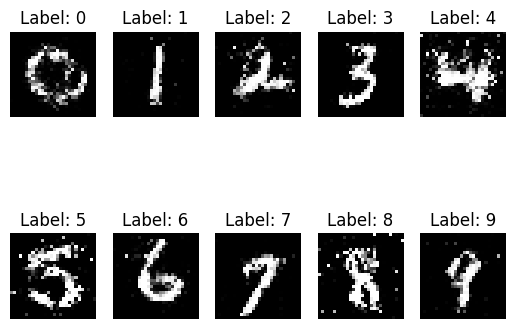

1/1 [==============================] - 0s 25ms/step
14901 [Discriminator loss: 0.655462, acc.: 54.69%] [Generator loss: 0.865388]
1/1 [==============================] - 0s 29ms/step
14902 [Discriminator loss: 0.636068, acc.: 59.38%] [Generator loss: 0.763958]
1/1 [==============================] - 0s 24ms/step
14903 [Discriminator loss: 0.658754, acc.: 57.81%] [Generator loss: 0.760419]
1/1 [==============================] - 0s 24ms/step
14904 [Discriminator loss: 0.703167, acc.: 45.31%] [Generator loss: 0.780792]
1/1 [==============================] - 0s 23ms/step
14905 [Discriminator loss: 0.697033, acc.: 54.69%] [Generator loss: 0.776215]
1/1 [==============================] - 0s 29ms/step
14906 [Discriminator loss: 0.620288, acc.: 68.75%] [Generator loss: 0.777117]
1/1 [==============================] - 0s 27ms/step
14907 [Discriminator loss: 0.608154, acc.: 68.75%] [Generator loss: 0.804683]
1/1 [==============================] - 0s 23ms/step
14908 [Discriminator loss: 0.695413, a

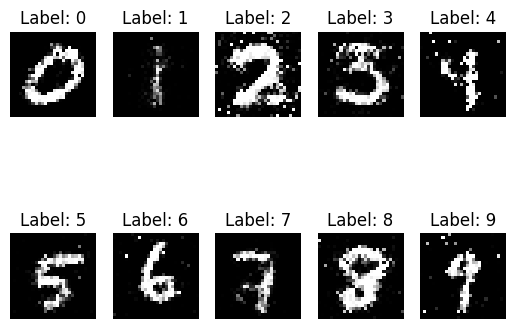

1/1 [==============================] - 0s 24ms/step
15001 [Discriminator loss: 0.658557, acc.: 57.81%] [Generator loss: 0.901804]
1/1 [==============================] - 0s 22ms/step
15002 [Discriminator loss: 0.702923, acc.: 46.88%] [Generator loss: 0.791702]
1/1 [==============================] - 0s 27ms/step
15003 [Discriminator loss: 0.692165, acc.: 54.69%] [Generator loss: 0.887485]
1/1 [==============================] - 0s 30ms/step
15004 [Discriminator loss: 0.655698, acc.: 64.06%] [Generator loss: 0.814772]
1/1 [==============================] - 0s 23ms/step
15005 [Discriminator loss: 0.733803, acc.: 56.25%] [Generator loss: 0.839026]
1/1 [==============================] - 0s 23ms/step
15006 [Discriminator loss: 0.665406, acc.: 60.94%] [Generator loss: 0.853344]
1/1 [==============================] - 0s 25ms/step
15007 [Discriminator loss: 0.681071, acc.: 54.69%] [Generator loss: 0.743729]
1/1 [==============================] - 0s 26ms/step
15008 [Discriminator loss: 0.687165, a

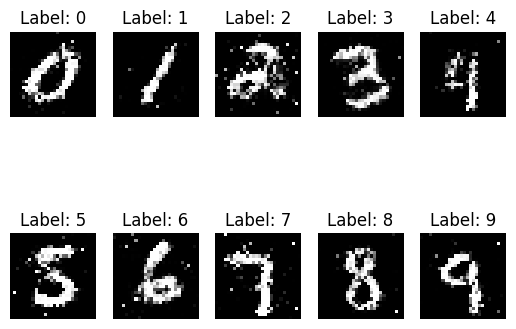

1/1 [==============================] - 0s 26ms/step
15101 [Discriminator loss: 0.699174, acc.: 40.62%] [Generator loss: 0.838993]
1/1 [==============================] - 0s 37ms/step
15102 [Discriminator loss: 0.638367, acc.: 56.25%] [Generator loss: 0.834480]
1/1 [==============================] - 0s 24ms/step
15103 [Discriminator loss: 0.679375, acc.: 56.25%] [Generator loss: 0.848693]
1/1 [==============================] - 0s 56ms/step
15104 [Discriminator loss: 0.645690, acc.: 62.50%] [Generator loss: 0.843947]
1/1 [==============================] - 0s 27ms/step
15105 [Discriminator loss: 0.625109, acc.: 67.19%] [Generator loss: 0.802903]
1/1 [==============================] - 0s 25ms/step
15106 [Discriminator loss: 0.675716, acc.: 56.25%] [Generator loss: 0.823632]
1/1 [==============================] - 0s 23ms/step
15107 [Discriminator loss: 0.686557, acc.: 57.81%] [Generator loss: 0.818979]
1/1 [==============================] - 0s 22ms/step
15108 [Discriminator loss: 0.649918, a

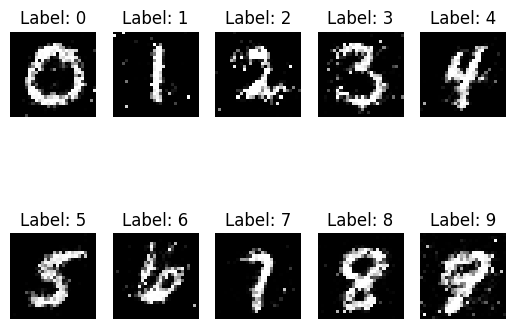

1/1 [==============================] - 0s 34ms/step
15201 [Discriminator loss: 0.670628, acc.: 57.81%] [Generator loss: 0.807945]
1/1 [==============================] - 0s 28ms/step
15202 [Discriminator loss: 0.694143, acc.: 59.38%] [Generator loss: 0.802007]
1/1 [==============================] - 0s 27ms/step
15203 [Discriminator loss: 0.692915, acc.: 53.12%] [Generator loss: 0.803254]
1/1 [==============================] - 0s 29ms/step
15204 [Discriminator loss: 0.700587, acc.: 54.69%] [Generator loss: 0.871272]
1/1 [==============================] - 0s 26ms/step
15205 [Discriminator loss: 0.664854, acc.: 53.12%] [Generator loss: 0.848997]
1/1 [==============================] - 0s 28ms/step
15206 [Discriminator loss: 0.649163, acc.: 60.94%] [Generator loss: 0.835856]
1/1 [==============================] - 0s 28ms/step
15207 [Discriminator loss: 0.666229, acc.: 59.38%] [Generator loss: 0.832612]
1/1 [==============================] - 0s 29ms/step
15208 [Discriminator loss: 0.694668, a

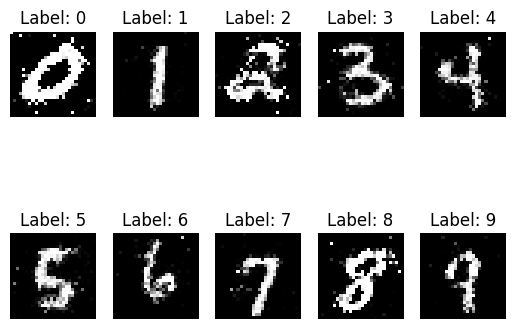

1/1 [==============================] - 0s 25ms/step
15301 [Discriminator loss: 0.644513, acc.: 57.81%] [Generator loss: 0.831817]
1/1 [==============================] - 0s 25ms/step
15302 [Discriminator loss: 0.664492, acc.: 59.38%] [Generator loss: 0.838264]
1/1 [==============================] - 0s 40ms/step
15303 [Discriminator loss: 0.598407, acc.: 65.62%] [Generator loss: 0.843959]
1/1 [==============================] - 0s 33ms/step
15304 [Discriminator loss: 0.676008, acc.: 53.12%] [Generator loss: 0.864013]
1/1 [==============================] - 0s 26ms/step
15305 [Discriminator loss: 0.683906, acc.: 51.56%] [Generator loss: 0.894884]
1/1 [==============================] - 0s 34ms/step
15306 [Discriminator loss: 0.684101, acc.: 53.12%] [Generator loss: 0.762332]
1/1 [==============================] - 0s 24ms/step
15307 [Discriminator loss: 0.649987, acc.: 64.06%] [Generator loss: 0.893694]
1/1 [==============================] - 0s 24ms/step
15308 [Discriminator loss: 0.676362, a

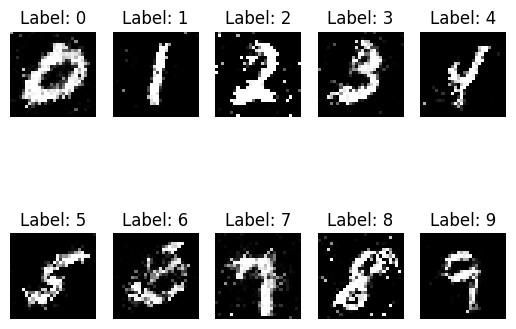

1/1 [==============================] - 0s 38ms/step
15401 [Discriminator loss: 0.659161, acc.: 64.06%] [Generator loss: 0.834987]
1/1 [==============================] - 0s 23ms/step
15402 [Discriminator loss: 0.635864, acc.: 59.38%] [Generator loss: 0.829913]
1/1 [==============================] - 0s 24ms/step
15403 [Discriminator loss: 0.680428, acc.: 53.12%] [Generator loss: 0.814500]
1/1 [==============================] - 0s 36ms/step
15404 [Discriminator loss: 0.647856, acc.: 59.38%] [Generator loss: 0.798999]
1/1 [==============================] - 0s 45ms/step
15405 [Discriminator loss: 0.684876, acc.: 54.69%] [Generator loss: 0.829307]
1/1 [==============================] - 0s 26ms/step
15406 [Discriminator loss: 0.729959, acc.: 59.38%] [Generator loss: 0.791898]
1/1 [==============================] - 0s 53ms/step
15407 [Discriminator loss: 0.667153, acc.: 54.69%] [Generator loss: 0.813259]
1/1 [==============================] - 0s 37ms/step
15408 [Discriminator loss: 0.662060, a

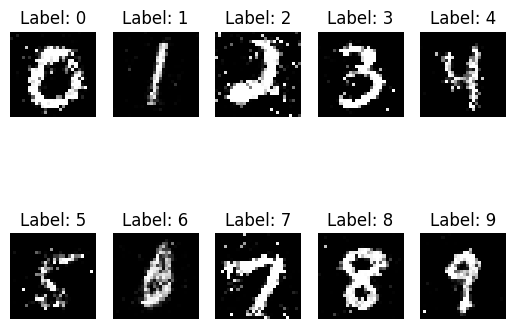

1/1 [==============================] - 0s 61ms/step
15501 [Discriminator loss: 0.669868, acc.: 59.38%] [Generator loss: 0.775857]
1/1 [==============================] - 0s 28ms/step
15502 [Discriminator loss: 0.677155, acc.: 50.00%] [Generator loss: 0.821477]
1/1 [==============================] - 0s 28ms/step
15503 [Discriminator loss: 0.625712, acc.: 60.94%] [Generator loss: 0.874004]
1/1 [==============================] - 0s 40ms/step
15504 [Discriminator loss: 0.650483, acc.: 65.62%] [Generator loss: 0.795173]
1/1 [==============================] - 0s 31ms/step
15505 [Discriminator loss: 0.688559, acc.: 51.56%] [Generator loss: 0.848763]
1/1 [==============================] - 0s 38ms/step
15506 [Discriminator loss: 0.679241, acc.: 50.00%] [Generator loss: 0.826473]
1/1 [==============================] - 0s 40ms/step
15507 [Discriminator loss: 0.697407, acc.: 54.69%] [Generator loss: 0.823000]
1/1 [==============================] - 0s 37ms/step
15508 [Discriminator loss: 0.680512, a

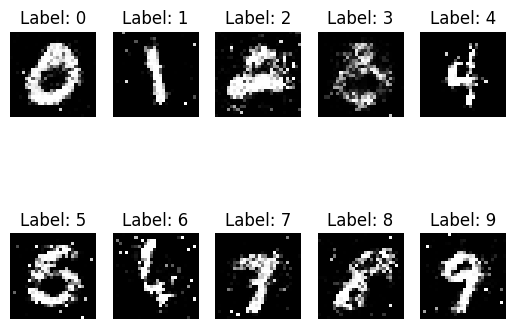

1/1 [==============================] - 0s 30ms/step
15601 [Discriminator loss: 0.674506, acc.: 60.94%] [Generator loss: 0.763338]
1/1 [==============================] - 0s 64ms/step
15602 [Discriminator loss: 0.671734, acc.: 50.00%] [Generator loss: 0.829095]
1/1 [==============================] - 0s 54ms/step
15603 [Discriminator loss: 0.658624, acc.: 57.81%] [Generator loss: 0.782696]
1/1 [==============================] - 0s 31ms/step
15604 [Discriminator loss: 0.655459, acc.: 50.00%] [Generator loss: 0.772746]
1/1 [==============================] - 0s 26ms/step
15605 [Discriminator loss: 0.637560, acc.: 67.19%] [Generator loss: 0.782472]
1/1 [==============================] - 0s 44ms/step
15606 [Discriminator loss: 0.663936, acc.: 64.06%] [Generator loss: 0.844952]
1/1 [==============================] - 0s 40ms/step
15607 [Discriminator loss: 0.654675, acc.: 64.06%] [Generator loss: 0.787360]
1/1 [==============================] - 0s 50ms/step
15608 [Discriminator loss: 0.619468, a

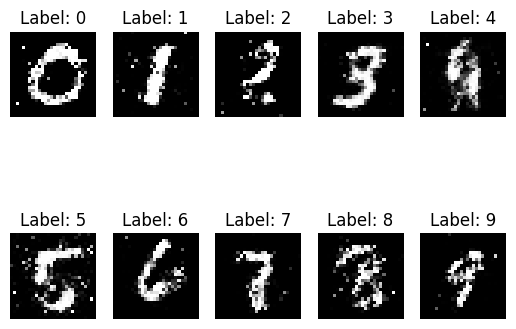

1/1 [==============================] - 0s 30ms/step
15701 [Discriminator loss: 0.684285, acc.: 51.56%] [Generator loss: 0.848210]
1/1 [==============================] - 0s 58ms/step
15702 [Discriminator loss: 0.678447, acc.: 48.44%] [Generator loss: 0.812418]
1/1 [==============================] - 0s 35ms/step
15703 [Discriminator loss: 0.654734, acc.: 56.25%] [Generator loss: 0.848941]
1/1 [==============================] - 0s 35ms/step
15704 [Discriminator loss: 0.610785, acc.: 71.88%] [Generator loss: 0.849078]
1/1 [==============================] - 0s 40ms/step
15705 [Discriminator loss: 0.678597, acc.: 56.25%] [Generator loss: 0.807055]
1/1 [==============================] - 0s 24ms/step
15706 [Discriminator loss: 0.677355, acc.: 56.25%] [Generator loss: 0.847852]
1/1 [==============================] - 0s 49ms/step
15707 [Discriminator loss: 0.704744, acc.: 50.00%] [Generator loss: 0.829656]
1/1 [==============================] - 0s 34ms/step
15708 [Discriminator loss: 0.704386, a

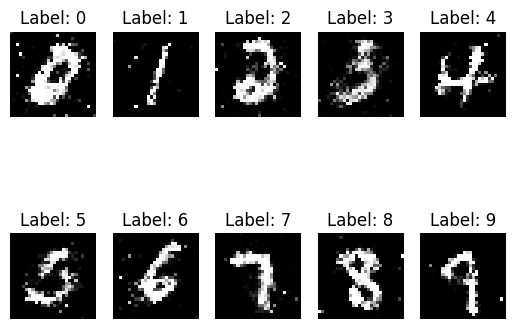

1/1 [==============================] - 0s 25ms/step
15801 [Discriminator loss: 0.676004, acc.: 57.81%] [Generator loss: 0.782321]
1/1 [==============================] - 0s 44ms/step
15802 [Discriminator loss: 0.611121, acc.: 64.06%] [Generator loss: 0.856310]
1/1 [==============================] - 0s 50ms/step
15803 [Discriminator loss: 0.628131, acc.: 56.25%] [Generator loss: 0.833205]
1/1 [==============================] - 0s 35ms/step
15804 [Discriminator loss: 0.665459, acc.: 57.81%] [Generator loss: 0.858686]
1/1 [==============================] - 0s 33ms/step
15805 [Discriminator loss: 0.643505, acc.: 60.94%] [Generator loss: 0.778262]
1/1 [==============================] - 0s 39ms/step
15806 [Discriminator loss: 0.628741, acc.: 56.25%] [Generator loss: 0.850178]
1/1 [==============================] - 0s 43ms/step
15807 [Discriminator loss: 0.687502, acc.: 57.81%] [Generator loss: 0.762378]
1/1 [==============================] - 0s 37ms/step
15808 [Discriminator loss: 0.670053, a

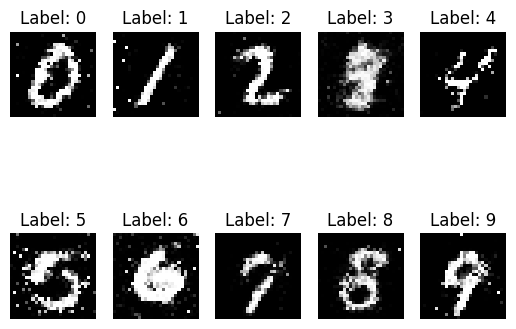

1/1 [==============================] - 0s 46ms/step
15901 [Discriminator loss: 0.647364, acc.: 59.38%] [Generator loss: 0.821827]
1/1 [==============================] - 0s 29ms/step
15902 [Discriminator loss: 0.653855, acc.: 56.25%] [Generator loss: 0.772483]
1/1 [==============================] - 0s 53ms/step
15903 [Discriminator loss: 0.647092, acc.: 62.50%] [Generator loss: 0.791013]
1/1 [==============================] - 0s 31ms/step
15904 [Discriminator loss: 0.669278, acc.: 64.06%] [Generator loss: 0.838255]
1/1 [==============================] - 0s 33ms/step
15905 [Discriminator loss: 0.577584, acc.: 71.88%] [Generator loss: 0.789868]
1/1 [==============================] - 0s 52ms/step
15906 [Discriminator loss: 0.640630, acc.: 54.69%] [Generator loss: 0.816193]
1/1 [==============================] - 0s 31ms/step
15907 [Discriminator loss: 0.697035, acc.: 54.69%] [Generator loss: 0.865617]
1/1 [==============================] - 0s 38ms/step
15908 [Discriminator loss: 0.635443, a

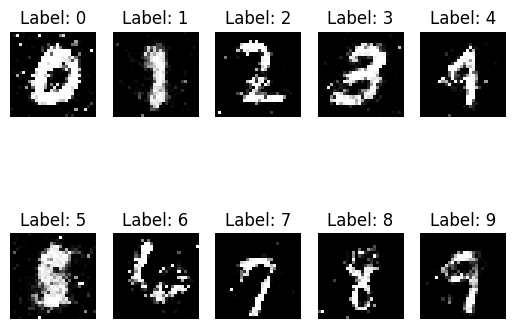

1/1 [==============================] - 0s 34ms/step
16001 [Discriminator loss: 0.686489, acc.: 56.25%] [Generator loss: 0.750287]
1/1 [==============================] - 0s 43ms/step
16002 [Discriminator loss: 0.686133, acc.: 48.44%] [Generator loss: 0.815754]
1/1 [==============================] - 0s 38ms/step
16003 [Discriminator loss: 0.663357, acc.: 64.06%] [Generator loss: 0.807443]
1/1 [==============================] - 0s 25ms/step
16004 [Discriminator loss: 0.636195, acc.: 56.25%] [Generator loss: 0.888652]
1/1 [==============================] - 0s 48ms/step
16005 [Discriminator loss: 0.669633, acc.: 56.25%] [Generator loss: 0.778284]
1/1 [==============================] - 0s 59ms/step
16006 [Discriminator loss: 0.603932, acc.: 75.00%] [Generator loss: 0.847813]
1/1 [==============================] - 0s 29ms/step
16007 [Discriminator loss: 0.627700, acc.: 64.06%] [Generator loss: 0.786056]
1/1 [==============================] - 0s 27ms/step
16008 [Discriminator loss: 0.648667, a

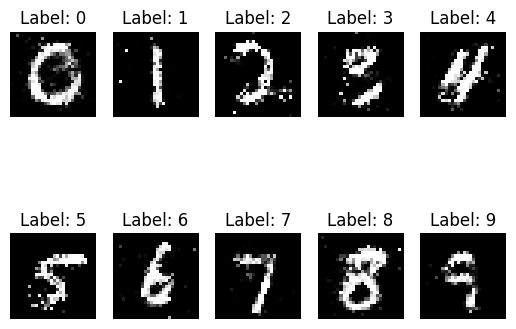

1/1 [==============================] - 0s 29ms/step
16101 [Discriminator loss: 0.590773, acc.: 71.88%] [Generator loss: 0.843224]
1/1 [==============================] - 0s 55ms/step
16102 [Discriminator loss: 0.720517, acc.: 54.69%] [Generator loss: 0.823156]
1/1 [==============================] - 0s 38ms/step
16103 [Discriminator loss: 0.696883, acc.: 57.81%] [Generator loss: 0.780930]
1/1 [==============================] - 0s 42ms/step
16104 [Discriminator loss: 0.667510, acc.: 56.25%] [Generator loss: 0.859454]
1/1 [==============================] - 0s 37ms/step
16105 [Discriminator loss: 0.645757, acc.: 57.81%] [Generator loss: 0.857428]
1/1 [==============================] - 0s 30ms/step
16106 [Discriminator loss: 0.697603, acc.: 56.25%] [Generator loss: 0.842136]
1/1 [==============================] - 0s 30ms/step
16107 [Discriminator loss: 0.622213, acc.: 67.19%] [Generator loss: 0.765897]
1/1 [==============================] - 0s 50ms/step
16108 [Discriminator loss: 0.629031, a

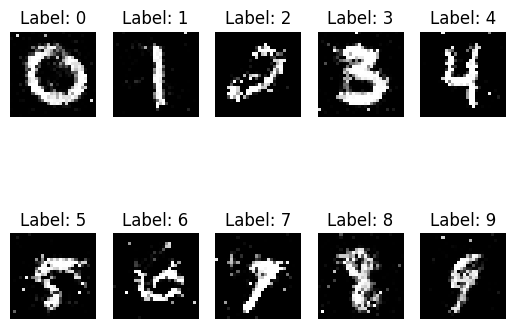

1/1 [==============================] - 0s 38ms/step
16201 [Discriminator loss: 0.672019, acc.: 53.12%] [Generator loss: 0.848400]
1/1 [==============================] - 0s 39ms/step
16202 [Discriminator loss: 0.695674, acc.: 56.25%] [Generator loss: 0.879599]
1/1 [==============================] - 0s 36ms/step
16203 [Discriminator loss: 0.665116, acc.: 57.81%] [Generator loss: 0.891488]
1/1 [==============================] - 0s 48ms/step
16204 [Discriminator loss: 0.607516, acc.: 57.81%] [Generator loss: 0.851471]
1/1 [==============================] - 0s 37ms/step
16205 [Discriminator loss: 0.605480, acc.: 62.50%] [Generator loss: 0.866130]
1/1 [==============================] - 0s 60ms/step
16206 [Discriminator loss: 0.659517, acc.: 56.25%] [Generator loss: 0.897780]
1/1 [==============================] - 0s 44ms/step
16207 [Discriminator loss: 0.640481, acc.: 62.50%] [Generator loss: 0.841848]
1/1 [==============================] - 0s 39ms/step
16208 [Discriminator loss: 0.676608, a

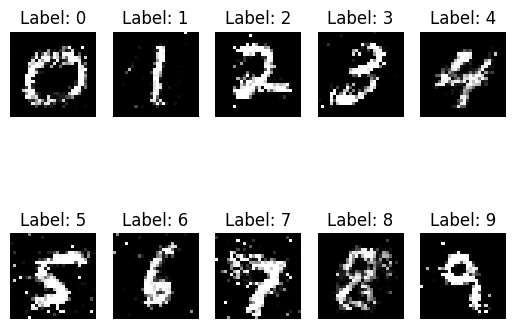

1/1 [==============================] - 0s 33ms/step
16301 [Discriminator loss: 0.634455, acc.: 60.94%] [Generator loss: 0.845906]
1/1 [==============================] - 0s 28ms/step
16302 [Discriminator loss: 0.683787, acc.: 54.69%] [Generator loss: 0.880246]
1/1 [==============================] - 0s 30ms/step
16303 [Discriminator loss: 0.708299, acc.: 54.69%] [Generator loss: 0.943690]
1/1 [==============================] - 0s 28ms/step
16304 [Discriminator loss: 0.688500, acc.: 54.69%] [Generator loss: 0.877107]
1/1 [==============================] - 0s 27ms/step
16305 [Discriminator loss: 0.655872, acc.: 60.94%] [Generator loss: 0.904166]
1/1 [==============================] - 0s 32ms/step
16306 [Discriminator loss: 0.668008, acc.: 57.81%] [Generator loss: 0.881278]
1/1 [==============================] - 0s 35ms/step
16307 [Discriminator loss: 0.663812, acc.: 59.38%] [Generator loss: 0.902105]
1/1 [==============================] - 0s 30ms/step
16308 [Discriminator loss: 0.657090, a

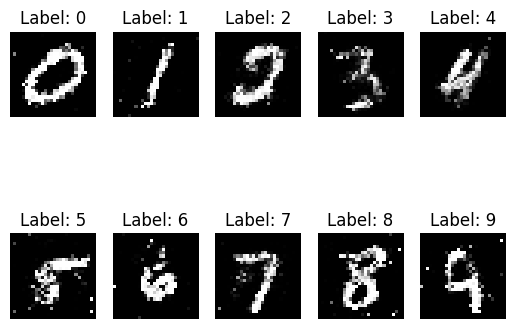

1/1 [==============================] - 0s 24ms/step
16401 [Discriminator loss: 0.667553, acc.: 53.12%] [Generator loss: 0.806878]
1/1 [==============================] - 0s 25ms/step
16402 [Discriminator loss: 0.693006, acc.: 57.81%] [Generator loss: 0.828208]
1/1 [==============================] - 0s 33ms/step
16403 [Discriminator loss: 0.599472, acc.: 67.19%] [Generator loss: 0.844569]
1/1 [==============================] - 0s 24ms/step
16404 [Discriminator loss: 0.657606, acc.: 64.06%] [Generator loss: 0.765138]
1/1 [==============================] - 0s 31ms/step
16405 [Discriminator loss: 0.679395, acc.: 50.00%] [Generator loss: 0.779682]
1/1 [==============================] - 0s 26ms/step
16406 [Discriminator loss: 0.652262, acc.: 57.81%] [Generator loss: 0.779649]
1/1 [==============================] - 0s 24ms/step
16407 [Discriminator loss: 0.620420, acc.: 67.19%] [Generator loss: 0.813303]
1/1 [==============================] - 0s 25ms/step
16408 [Discriminator loss: 0.606950, a

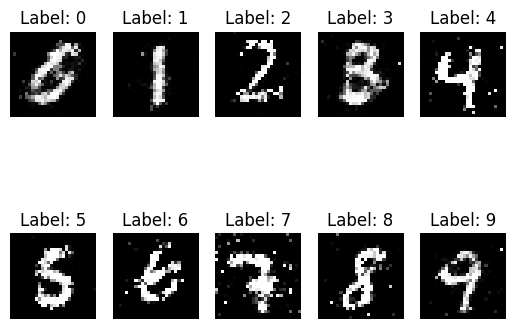

1/1 [==============================] - 0s 24ms/step
16501 [Discriminator loss: 0.677592, acc.: 57.81%] [Generator loss: 0.769953]
1/1 [==============================] - 0s 23ms/step
16502 [Discriminator loss: 0.624622, acc.: 67.19%] [Generator loss: 0.841658]
1/1 [==============================] - 0s 25ms/step
16503 [Discriminator loss: 0.562451, acc.: 68.75%] [Generator loss: 0.951930]
1/1 [==============================] - 0s 25ms/step
16504 [Discriminator loss: 0.615319, acc.: 67.19%] [Generator loss: 0.931692]
1/1 [==============================] - 0s 25ms/step
16505 [Discriminator loss: 0.684078, acc.: 54.69%] [Generator loss: 0.889109]
1/1 [==============================] - 0s 23ms/step
16506 [Discriminator loss: 0.640482, acc.: 59.38%] [Generator loss: 0.857439]
1/1 [==============================] - 0s 24ms/step
16507 [Discriminator loss: 0.674508, acc.: 51.56%] [Generator loss: 0.810189]
1/1 [==============================] - 0s 25ms/step
16508 [Discriminator loss: 0.661550, a

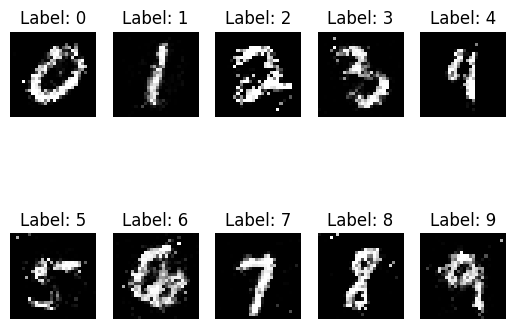

1/1 [==============================] - 0s 26ms/step
16601 [Discriminator loss: 0.647913, acc.: 67.19%] [Generator loss: 0.787338]
1/1 [==============================] - 0s 24ms/step
16602 [Discriminator loss: 0.725972, acc.: 53.12%] [Generator loss: 0.804310]
1/1 [==============================] - 0s 23ms/step
16603 [Discriminator loss: 0.709637, acc.: 56.25%] [Generator loss: 0.834411]
1/1 [==============================] - 0s 24ms/step
16604 [Discriminator loss: 0.631115, acc.: 56.25%] [Generator loss: 0.810634]
1/1 [==============================] - 0s 25ms/step
16605 [Discriminator loss: 0.704468, acc.: 57.81%] [Generator loss: 0.919694]
1/1 [==============================] - 0s 29ms/step
16606 [Discriminator loss: 0.621243, acc.: 60.94%] [Generator loss: 0.805619]
1/1 [==============================] - 0s 25ms/step
16607 [Discriminator loss: 0.650604, acc.: 67.19%] [Generator loss: 0.833979]
1/1 [==============================] - 0s 22ms/step
16608 [Discriminator loss: 0.632881, a

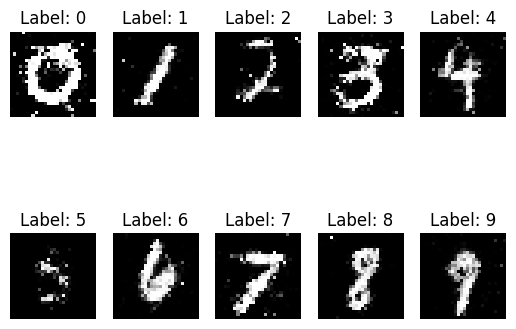

1/1 [==============================] - 0s 30ms/step
16701 [Discriminator loss: 0.711758, acc.: 50.00%] [Generator loss: 0.788423]
1/1 [==============================] - 0s 28ms/step
16702 [Discriminator loss: 0.665448, acc.: 50.00%] [Generator loss: 0.879886]
1/1 [==============================] - 0s 28ms/step
16703 [Discriminator loss: 0.641873, acc.: 50.00%] [Generator loss: 0.843604]
1/1 [==============================] - 0s 29ms/step
16704 [Discriminator loss: 0.676628, acc.: 54.69%] [Generator loss: 0.902619]
1/1 [==============================] - 0s 27ms/step
16705 [Discriminator loss: 0.683053, acc.: 50.00%] [Generator loss: 0.873311]
1/1 [==============================] - 0s 28ms/step
16706 [Discriminator loss: 0.698788, acc.: 57.81%] [Generator loss: 0.918625]
1/1 [==============================] - 0s 37ms/step
16707 [Discriminator loss: 0.699956, acc.: 48.44%] [Generator loss: 0.887125]
1/1 [==============================] - 0s 32ms/step
16708 [Discriminator loss: 0.633369, a

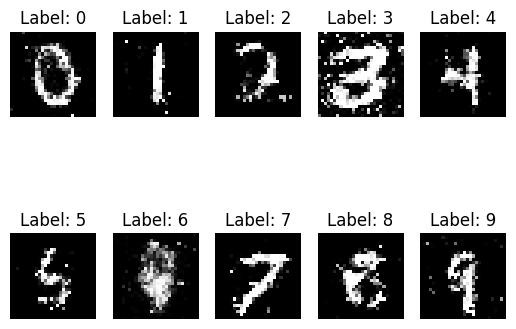

1/1 [==============================] - 0s 27ms/step
16801 [Discriminator loss: 0.625473, acc.: 62.50%] [Generator loss: 0.744857]
1/1 [==============================] - 0s 24ms/step
16802 [Discriminator loss: 0.640647, acc.: 62.50%] [Generator loss: 0.766172]
1/1 [==============================] - 0s 24ms/step
16803 [Discriminator loss: 0.675587, acc.: 62.50%] [Generator loss: 0.780107]
1/1 [==============================] - 0s 25ms/step
16804 [Discriminator loss: 0.734518, acc.: 51.56%] [Generator loss: 0.748795]
1/1 [==============================] - 0s 24ms/step
16805 [Discriminator loss: 0.651953, acc.: 62.50%] [Generator loss: 0.821436]
1/1 [==============================] - 0s 48ms/step
16806 [Discriminator loss: 0.666623, acc.: 56.25%] [Generator loss: 0.847927]
1/1 [==============================] - 0s 25ms/step
16807 [Discriminator loss: 0.682478, acc.: 54.69%] [Generator loss: 0.866981]
1/1 [==============================] - 0s 23ms/step
16808 [Discriminator loss: 0.665297, a

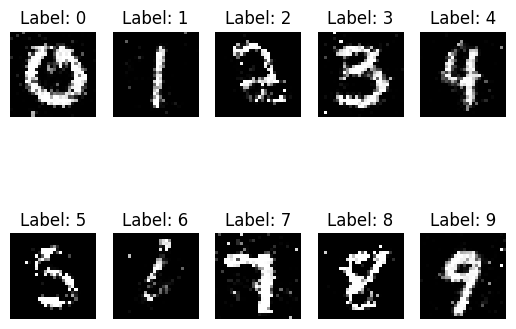

1/1 [==============================] - 0s 24ms/step
16901 [Discriminator loss: 0.669326, acc.: 59.38%] [Generator loss: 0.793936]
1/1 [==============================] - 0s 23ms/step
16902 [Discriminator loss: 0.681516, acc.: 53.12%] [Generator loss: 0.815362]
1/1 [==============================] - 0s 26ms/step
16903 [Discriminator loss: 0.665013, acc.: 59.38%] [Generator loss: 0.799601]
1/1 [==============================] - 0s 32ms/step
16904 [Discriminator loss: 0.610933, acc.: 67.19%] [Generator loss: 0.716547]
1/1 [==============================] - 0s 26ms/step
16905 [Discriminator loss: 0.680721, acc.: 51.56%] [Generator loss: 0.764158]
1/1 [==============================] - 0s 24ms/step
16906 [Discriminator loss: 0.661707, acc.: 57.81%] [Generator loss: 0.873777]
1/1 [==============================] - 0s 36ms/step
16907 [Discriminator loss: 0.619803, acc.: 67.19%] [Generator loss: 0.818366]
1/1 [==============================] - 0s 34ms/step
16908 [Discriminator loss: 0.690001, a

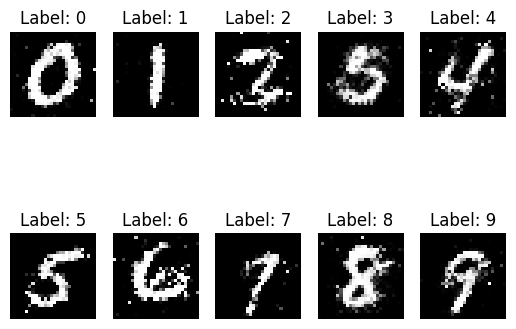

1/1 [==============================] - 0s 36ms/step
17001 [Discriminator loss: 0.655576, acc.: 59.38%] [Generator loss: 0.779307]
1/1 [==============================] - 0s 29ms/step
17002 [Discriminator loss: 0.628556, acc.: 62.50%] [Generator loss: 0.732995]
1/1 [==============================] - 0s 25ms/step
17003 [Discriminator loss: 0.610549, acc.: 68.75%] [Generator loss: 0.814656]
1/1 [==============================] - 0s 30ms/step
17004 [Discriminator loss: 0.673906, acc.: 56.25%] [Generator loss: 0.812769]
1/1 [==============================] - 0s 30ms/step
17005 [Discriminator loss: 0.604886, acc.: 68.75%] [Generator loss: 0.822867]
1/1 [==============================] - 0s 29ms/step
17006 [Discriminator loss: 0.631775, acc.: 62.50%] [Generator loss: 0.859110]
1/1 [==============================] - 0s 23ms/step
17007 [Discriminator loss: 0.671749, acc.: 53.12%] [Generator loss: 0.779872]
1/1 [==============================] - 0s 26ms/step
17008 [Discriminator loss: 0.609994, a

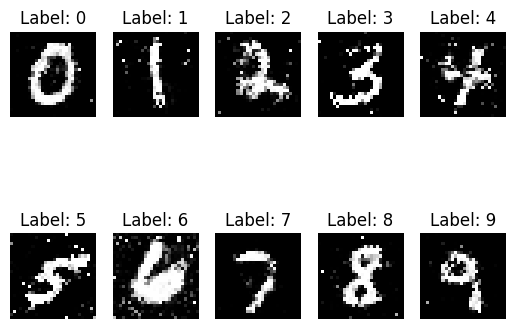

1/1 [==============================] - 0s 31ms/step
17101 [Discriminator loss: 0.618215, acc.: 59.38%] [Generator loss: 0.810421]
1/1 [==============================] - 0s 27ms/step
17102 [Discriminator loss: 0.652567, acc.: 59.38%] [Generator loss: 0.859148]
1/1 [==============================] - 0s 28ms/step
17103 [Discriminator loss: 0.645958, acc.: 62.50%] [Generator loss: 0.874938]
1/1 [==============================] - 0s 28ms/step
17104 [Discriminator loss: 0.639966, acc.: 59.38%] [Generator loss: 0.814623]
1/1 [==============================] - 0s 29ms/step
17105 [Discriminator loss: 0.577360, acc.: 68.75%] [Generator loss: 0.986597]
1/1 [==============================] - 0s 32ms/step
17106 [Discriminator loss: 0.642441, acc.: 62.50%] [Generator loss: 1.010000]
1/1 [==============================] - 0s 29ms/step
17107 [Discriminator loss: 0.627980, acc.: 60.94%] [Generator loss: 0.780509]
1/1 [==============================] - 0s 38ms/step
17108 [Discriminator loss: 0.664201, a

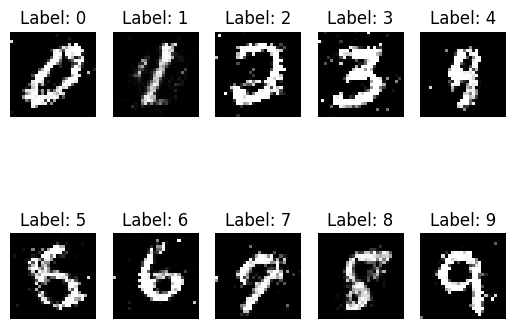

1/1 [==============================] - 0s 25ms/step
17201 [Discriminator loss: 0.686503, acc.: 60.94%] [Generator loss: 0.854123]
1/1 [==============================] - 0s 23ms/step
17202 [Discriminator loss: 0.590977, acc.: 60.94%] [Generator loss: 0.899573]
1/1 [==============================] - 0s 23ms/step
17203 [Discriminator loss: 0.657721, acc.: 65.62%] [Generator loss: 0.907577]
1/1 [==============================] - 0s 22ms/step
17204 [Discriminator loss: 0.639961, acc.: 64.06%] [Generator loss: 0.905538]
1/1 [==============================] - 0s 23ms/step
17205 [Discriminator loss: 0.664602, acc.: 43.75%] [Generator loss: 0.797761]
1/1 [==============================] - 0s 26ms/step
17206 [Discriminator loss: 0.632608, acc.: 57.81%] [Generator loss: 0.862317]
1/1 [==============================] - 0s 23ms/step
17207 [Discriminator loss: 0.661440, acc.: 56.25%] [Generator loss: 0.899045]
1/1 [==============================] - 0s 42ms/step
17208 [Discriminator loss: 0.637468, a

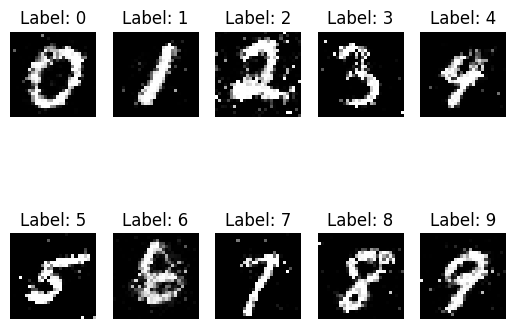

1/1 [==============================] - 0s 25ms/step
17301 [Discriminator loss: 0.726824, acc.: 43.75%] [Generator loss: 0.786827]
1/1 [==============================] - 0s 28ms/step
17302 [Discriminator loss: 0.682442, acc.: 46.88%] [Generator loss: 0.807475]
1/1 [==============================] - 0s 44ms/step
17303 [Discriminator loss: 0.657295, acc.: 59.38%] [Generator loss: 0.792896]
1/1 [==============================] - 0s 23ms/step
17304 [Discriminator loss: 0.641311, acc.: 53.12%] [Generator loss: 0.817972]
1/1 [==============================] - 0s 24ms/step
17305 [Discriminator loss: 0.672753, acc.: 62.50%] [Generator loss: 0.825452]
1/1 [==============================] - 0s 26ms/step
17306 [Discriminator loss: 0.685304, acc.: 54.69%] [Generator loss: 0.872756]
1/1 [==============================] - 0s 29ms/step
17307 [Discriminator loss: 0.646992, acc.: 59.38%] [Generator loss: 0.846336]
1/1 [==============================] - 0s 23ms/step
17308 [Discriminator loss: 0.676039, a

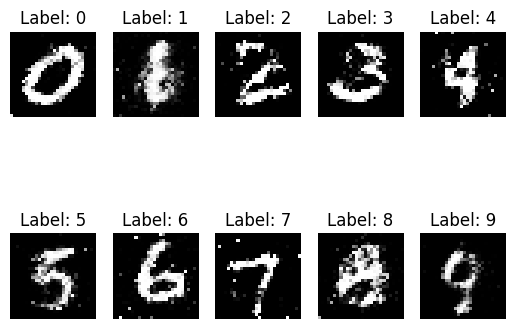

1/1 [==============================] - 0s 24ms/step
17401 [Discriminator loss: 0.677093, acc.: 46.88%] [Generator loss: 0.837743]
1/1 [==============================] - 0s 27ms/step
17402 [Discriminator loss: 0.673942, acc.: 46.88%] [Generator loss: 0.823743]
1/1 [==============================] - 0s 26ms/step
17403 [Discriminator loss: 0.704411, acc.: 48.44%] [Generator loss: 0.868586]
1/1 [==============================] - 0s 26ms/step
17404 [Discriminator loss: 0.655419, acc.: 57.81%] [Generator loss: 0.768112]
1/1 [==============================] - 0s 27ms/step
17405 [Discriminator loss: 0.688158, acc.: 54.69%] [Generator loss: 0.837926]
1/1 [==============================] - 0s 24ms/step
17406 [Discriminator loss: 0.664842, acc.: 56.25%] [Generator loss: 0.858643]
1/1 [==============================] - 0s 26ms/step
17407 [Discriminator loss: 0.634125, acc.: 62.50%] [Generator loss: 0.861646]
1/1 [==============================] - 0s 25ms/step
17408 [Discriminator loss: 0.673083, a

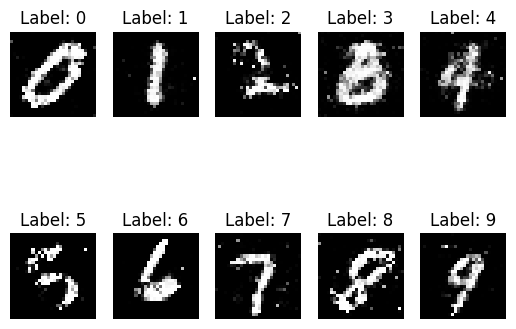

1/1 [==============================] - 0s 29ms/step
17501 [Discriminator loss: 0.707539, acc.: 56.25%] [Generator loss: 0.864791]
1/1 [==============================] - 0s 24ms/step
17502 [Discriminator loss: 0.698396, acc.: 45.31%] [Generator loss: 0.843034]
1/1 [==============================] - 0s 25ms/step
17503 [Discriminator loss: 0.714469, acc.: 59.38%] [Generator loss: 0.807093]
1/1 [==============================] - 0s 31ms/step
17504 [Discriminator loss: 0.636883, acc.: 59.38%] [Generator loss: 0.834685]
1/1 [==============================] - 0s 25ms/step
17505 [Discriminator loss: 0.682307, acc.: 53.12%] [Generator loss: 0.803296]
1/1 [==============================] - 0s 23ms/step
17506 [Discriminator loss: 0.682453, acc.: 48.44%] [Generator loss: 0.836459]
1/1 [==============================] - 0s 24ms/step
17507 [Discriminator loss: 0.667691, acc.: 59.38%] [Generator loss: 0.813068]
1/1 [==============================] - 0s 26ms/step
17508 [Discriminator loss: 0.651850, a

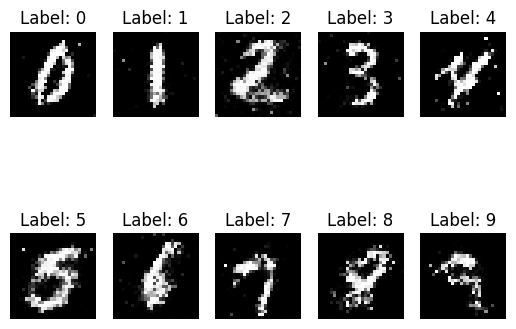

1/1 [==============================] - 0s 24ms/step
17601 [Discriminator loss: 0.684534, acc.: 48.44%] [Generator loss: 0.798164]
1/1 [==============================] - 0s 23ms/step
17602 [Discriminator loss: 0.640129, acc.: 57.81%] [Generator loss: 0.837571]
1/1 [==============================] - 0s 23ms/step
17603 [Discriminator loss: 0.655213, acc.: 68.75%] [Generator loss: 0.864399]
1/1 [==============================] - 0s 25ms/step
17604 [Discriminator loss: 0.694505, acc.: 57.81%] [Generator loss: 0.863194]
1/1 [==============================] - 0s 23ms/step
17605 [Discriminator loss: 0.672671, acc.: 57.81%] [Generator loss: 0.892403]
1/1 [==============================] - 0s 28ms/step
17606 [Discriminator loss: 0.728749, acc.: 46.88%] [Generator loss: 0.841080]
1/1 [==============================] - 0s 29ms/step
17607 [Discriminator loss: 0.661051, acc.: 62.50%] [Generator loss: 0.835507]
1/1 [==============================] - 0s 37ms/step
17608 [Discriminator loss: 0.651256, a

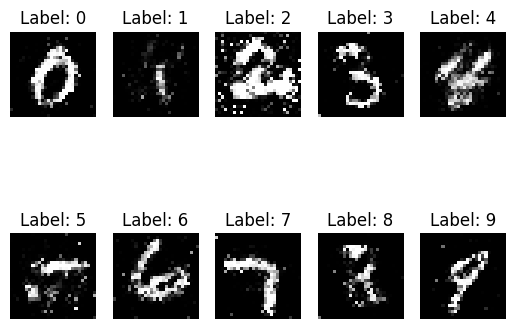

1/1 [==============================] - 0s 25ms/step
17701 [Discriminator loss: 0.652323, acc.: 60.94%] [Generator loss: 0.770107]
1/1 [==============================] - 0s 23ms/step
17702 [Discriminator loss: 0.635665, acc.: 59.38%] [Generator loss: 0.804836]
1/1 [==============================] - 0s 24ms/step
17703 [Discriminator loss: 0.612712, acc.: 60.94%] [Generator loss: 0.796590]
1/1 [==============================] - 0s 30ms/step
17704 [Discriminator loss: 0.607776, acc.: 65.62%] [Generator loss: 0.853913]
1/1 [==============================] - 0s 29ms/step
17705 [Discriminator loss: 0.672533, acc.: 53.12%] [Generator loss: 0.849193]
1/1 [==============================] - 0s 24ms/step
17706 [Discriminator loss: 0.666292, acc.: 53.12%] [Generator loss: 0.851465]
1/1 [==============================] - 0s 26ms/step
17707 [Discriminator loss: 0.639884, acc.: 59.38%] [Generator loss: 0.784999]
1/1 [==============================] - 0s 24ms/step
17708 [Discriminator loss: 0.702349, a

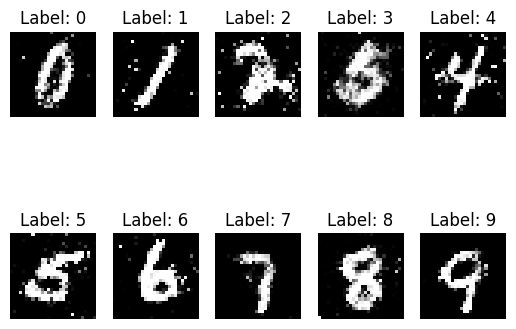

1/1 [==============================] - 0s 29ms/step
17801 [Discriminator loss: 0.623113, acc.: 64.06%] [Generator loss: 0.774394]
1/1 [==============================] - 0s 35ms/step
17802 [Discriminator loss: 0.734119, acc.: 53.12%] [Generator loss: 0.782782]
1/1 [==============================] - 0s 34ms/step
17803 [Discriminator loss: 0.630520, acc.: 62.50%] [Generator loss: 0.845819]
1/1 [==============================] - 0s 35ms/step
17804 [Discriminator loss: 0.679067, acc.: 57.81%] [Generator loss: 0.800691]
1/1 [==============================] - 0s 36ms/step
17805 [Discriminator loss: 0.677283, acc.: 59.38%] [Generator loss: 0.816573]
1/1 [==============================] - 0s 27ms/step
17806 [Discriminator loss: 0.607810, acc.: 60.94%] [Generator loss: 0.819863]
1/1 [==============================] - 0s 29ms/step
17807 [Discriminator loss: 0.656503, acc.: 57.81%] [Generator loss: 0.756112]
1/1 [==============================] - 0s 27ms/step
17808 [Discriminator loss: 0.732728, a

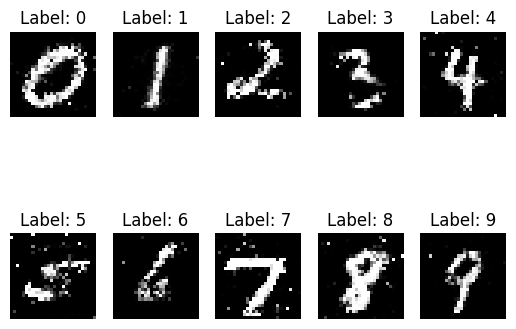

1/1 [==============================] - 0s 28ms/step
17901 [Discriminator loss: 0.669313, acc.: 54.69%] [Generator loss: 0.855285]
1/1 [==============================] - 0s 23ms/step
17902 [Discriminator loss: 0.607246, acc.: 60.94%] [Generator loss: 0.835939]
1/1 [==============================] - 0s 27ms/step
17903 [Discriminator loss: 0.665669, acc.: 59.38%] [Generator loss: 0.874413]
1/1 [==============================] - 0s 27ms/step
17904 [Discriminator loss: 0.652493, acc.: 59.38%] [Generator loss: 0.869941]
1/1 [==============================] - 0s 24ms/step
17905 [Discriminator loss: 0.713513, acc.: 50.00%] [Generator loss: 0.839376]
1/1 [==============================] - 0s 23ms/step
17906 [Discriminator loss: 0.633142, acc.: 64.06%] [Generator loss: 0.851656]
1/1 [==============================] - 0s 23ms/step
17907 [Discriminator loss: 0.626519, acc.: 60.94%] [Generator loss: 0.844306]
1/1 [==============================] - 0s 23ms/step
17908 [Discriminator loss: 0.666668, a

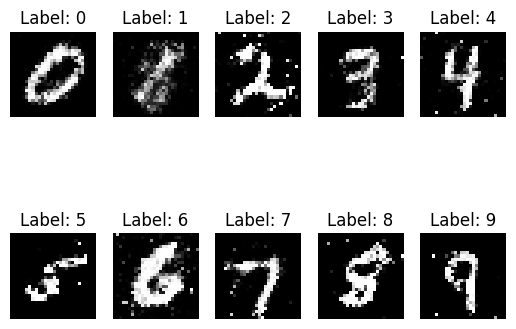

1/1 [==============================] - 0s 26ms/step
18001 [Discriminator loss: 0.642164, acc.: 57.81%] [Generator loss: 0.874997]
1/1 [==============================] - 0s 28ms/step
18002 [Discriminator loss: 0.660060, acc.: 59.38%] [Generator loss: 0.890726]
1/1 [==============================] - 0s 23ms/step
18003 [Discriminator loss: 0.651085, acc.: 53.12%] [Generator loss: 0.799783]
1/1 [==============================] - 0s 26ms/step
18004 [Discriminator loss: 0.674068, acc.: 53.12%] [Generator loss: 0.775709]
1/1 [==============================] - 0s 35ms/step
18005 [Discriminator loss: 0.685706, acc.: 64.06%] [Generator loss: 0.856138]
1/1 [==============================] - 0s 31ms/step
18006 [Discriminator loss: 0.662898, acc.: 60.94%] [Generator loss: 0.838091]
1/1 [==============================] - 0s 25ms/step
18007 [Discriminator loss: 0.649129, acc.: 59.38%] [Generator loss: 0.830978]
1/1 [==============================] - 0s 25ms/step
18008 [Discriminator loss: 0.622065, a

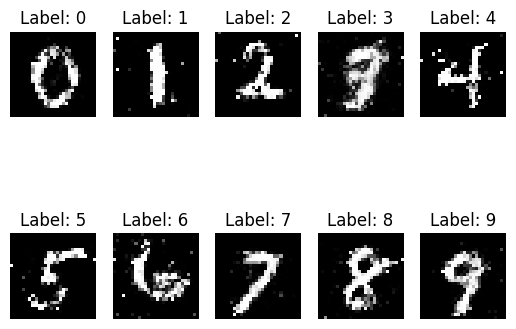

1/1 [==============================] - 0s 27ms/step
18101 [Discriminator loss: 0.648273, acc.: 59.38%] [Generator loss: 0.784726]
1/1 [==============================] - 0s 26ms/step
18102 [Discriminator loss: 0.626071, acc.: 62.50%] [Generator loss: 0.834991]
1/1 [==============================] - 0s 25ms/step
18103 [Discriminator loss: 0.612248, acc.: 70.31%] [Generator loss: 0.859462]
1/1 [==============================] - 0s 26ms/step
18104 [Discriminator loss: 0.693944, acc.: 56.25%] [Generator loss: 0.812135]
1/1 [==============================] - 0s 26ms/step
18105 [Discriminator loss: 0.664273, acc.: 54.69%] [Generator loss: 0.816828]
1/1 [==============================] - 0s 23ms/step
18106 [Discriminator loss: 0.680030, acc.: 53.12%] [Generator loss: 0.785421]
1/1 [==============================] - 0s 24ms/step
18107 [Discriminator loss: 0.704776, acc.: 59.38%] [Generator loss: 0.817952]
1/1 [==============================] - 0s 22ms/step
18108 [Discriminator loss: 0.681593, a

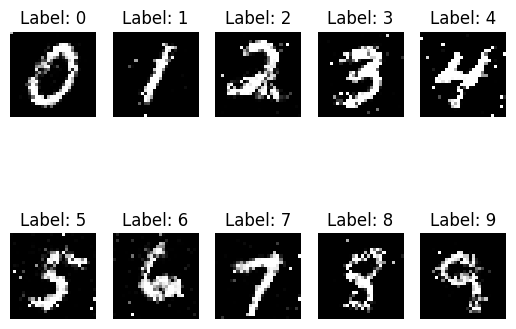

1/1 [==============================] - 0s 32ms/step
18201 [Discriminator loss: 0.677073, acc.: 54.69%] [Generator loss: 0.902219]
1/1 [==============================] - 0s 37ms/step
18202 [Discriminator loss: 0.668201, acc.: 59.38%] [Generator loss: 0.831311]
1/1 [==============================] - 0s 28ms/step
18203 [Discriminator loss: 0.683010, acc.: 54.69%] [Generator loss: 0.810057]
1/1 [==============================] - 0s 26ms/step
18204 [Discriminator loss: 0.642866, acc.: 65.62%] [Generator loss: 0.849962]
1/1 [==============================] - 0s 29ms/step
18205 [Discriminator loss: 0.668057, acc.: 65.62%] [Generator loss: 0.868635]
1/1 [==============================] - 0s 28ms/step
18206 [Discriminator loss: 0.668858, acc.: 62.50%] [Generator loss: 0.898891]
1/1 [==============================] - 0s 28ms/step
18207 [Discriminator loss: 0.667367, acc.: 53.12%] [Generator loss: 0.904608]
1/1 [==============================] - 0s 28ms/step
18208 [Discriminator loss: 0.648982, a

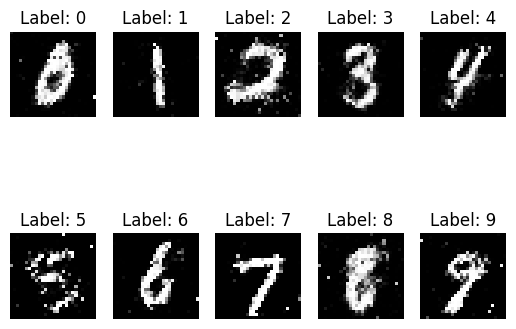

1/1 [==============================] - 0s 24ms/step
18301 [Discriminator loss: 0.620453, acc.: 67.19%] [Generator loss: 0.871291]
1/1 [==============================] - 0s 23ms/step
18302 [Discriminator loss: 0.679426, acc.: 57.81%] [Generator loss: 0.742066]
1/1 [==============================] - 0s 23ms/step
18303 [Discriminator loss: 0.653135, acc.: 62.50%] [Generator loss: 0.833417]
1/1 [==============================] - 0s 26ms/step
18304 [Discriminator loss: 0.618884, acc.: 62.50%] [Generator loss: 0.842300]
1/1 [==============================] - 0s 26ms/step
18305 [Discriminator loss: 0.624205, acc.: 54.69%] [Generator loss: 0.808601]
1/1 [==============================] - 0s 22ms/step
18306 [Discriminator loss: 0.670699, acc.: 51.56%] [Generator loss: 0.783432]
1/1 [==============================] - 0s 25ms/step
18307 [Discriminator loss: 0.606636, acc.: 57.81%] [Generator loss: 0.791668]
1/1 [==============================] - 0s 23ms/step
18308 [Discriminator loss: 0.654688, a

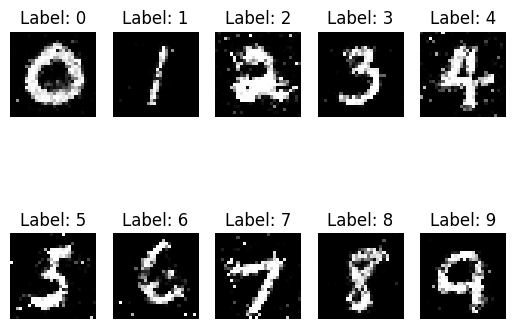

1/1 [==============================] - 0s 24ms/step
18401 [Discriminator loss: 0.646218, acc.: 60.94%] [Generator loss: 0.764758]
1/1 [==============================] - 0s 23ms/step
18402 [Discriminator loss: 0.627493, acc.: 62.50%] [Generator loss: 0.758911]
1/1 [==============================] - 0s 24ms/step
18403 [Discriminator loss: 0.648642, acc.: 56.25%] [Generator loss: 0.743445]
1/1 [==============================] - 0s 24ms/step
18404 [Discriminator loss: 0.675416, acc.: 53.12%] [Generator loss: 0.778988]
1/1 [==============================] - 0s 36ms/step
18405 [Discriminator loss: 0.606588, acc.: 67.19%] [Generator loss: 0.796578]
1/1 [==============================] - 0s 27ms/step
18406 [Discriminator loss: 0.664935, acc.: 56.25%] [Generator loss: 0.821110]
1/1 [==============================] - 0s 24ms/step
18407 [Discriminator loss: 0.607505, acc.: 64.06%] [Generator loss: 0.840829]
1/1 [==============================] - 0s 22ms/step
18408 [Discriminator loss: 0.621913, a

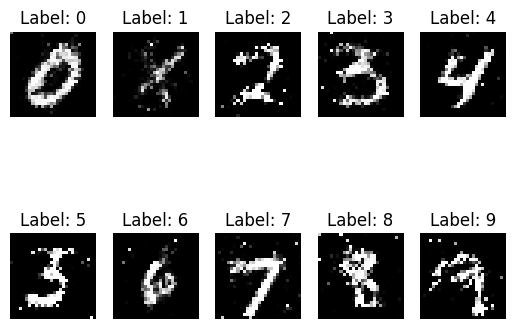

1/1 [==============================] - 0s 24ms/step
18501 [Discriminator loss: 0.629472, acc.: 65.62%] [Generator loss: 0.857262]
1/1 [==============================] - 0s 23ms/step
18502 [Discriminator loss: 0.612155, acc.: 59.38%] [Generator loss: 0.868977]
1/1 [==============================] - 0s 26ms/step
18503 [Discriminator loss: 0.705821, acc.: 57.81%] [Generator loss: 0.822788]
1/1 [==============================] - 0s 29ms/step
18504 [Discriminator loss: 0.629355, acc.: 60.94%] [Generator loss: 0.887300]
1/1 [==============================] - 0s 34ms/step
18505 [Discriminator loss: 0.617699, acc.: 64.06%] [Generator loss: 0.911330]
1/1 [==============================] - 0s 24ms/step
18506 [Discriminator loss: 0.648683, acc.: 62.50%] [Generator loss: 0.782793]
1/1 [==============================] - 0s 23ms/step
18507 [Discriminator loss: 0.628707, acc.: 60.94%] [Generator loss: 0.768249]
1/1 [==============================] - 0s 24ms/step
18508 [Discriminator loss: 0.726239, a

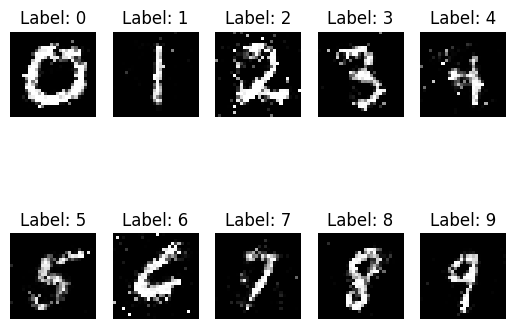

1/1 [==============================] - 0s 29ms/step
18601 [Discriminator loss: 0.669097, acc.: 46.88%] [Generator loss: 0.786315]
1/1 [==============================] - 0s 28ms/step
18602 [Discriminator loss: 0.680753, acc.: 53.12%] [Generator loss: 0.839431]
1/1 [==============================] - 0s 27ms/step
18603 [Discriminator loss: 0.686117, acc.: 56.25%] [Generator loss: 0.828795]
1/1 [==============================] - 0s 26ms/step
18604 [Discriminator loss: 0.676866, acc.: 54.69%] [Generator loss: 0.793530]
1/1 [==============================] - 0s 29ms/step
18605 [Discriminator loss: 0.644394, acc.: 56.25%] [Generator loss: 0.773733]
1/1 [==============================] - 0s 34ms/step
18606 [Discriminator loss: 0.667001, acc.: 57.81%] [Generator loss: 0.787370]
1/1 [==============================] - 0s 56ms/step
18607 [Discriminator loss: 0.633352, acc.: 60.94%] [Generator loss: 0.784146]
1/1 [==============================] - 0s 58ms/step
18608 [Discriminator loss: 0.664412, a

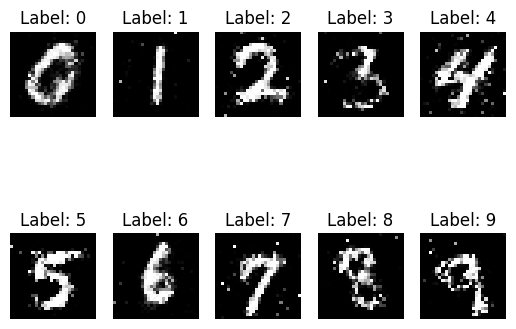

1/1 [==============================] - 0s 54ms/step
18701 [Discriminator loss: 0.613361, acc.: 68.75%] [Generator loss: 0.879255]
1/1 [==============================] - 0s 44ms/step
18702 [Discriminator loss: 0.701248, acc.: 56.25%] [Generator loss: 0.768582]
1/1 [==============================] - 0s 23ms/step
18703 [Discriminator loss: 0.688399, acc.: 50.00%] [Generator loss: 0.770047]
1/1 [==============================] - 0s 35ms/step
18704 [Discriminator loss: 0.682322, acc.: 65.62%] [Generator loss: 0.846083]
1/1 [==============================] - 0s 59ms/step
18705 [Discriminator loss: 0.595299, acc.: 68.75%] [Generator loss: 0.824065]
1/1 [==============================] - 0s 53ms/step
18706 [Discriminator loss: 0.629235, acc.: 62.50%] [Generator loss: 0.849756]
1/1 [==============================] - 0s 42ms/step
18707 [Discriminator loss: 0.644267, acc.: 60.94%] [Generator loss: 0.819452]
1/1 [==============================] - 0s 29ms/step
18708 [Discriminator loss: 0.683504, a

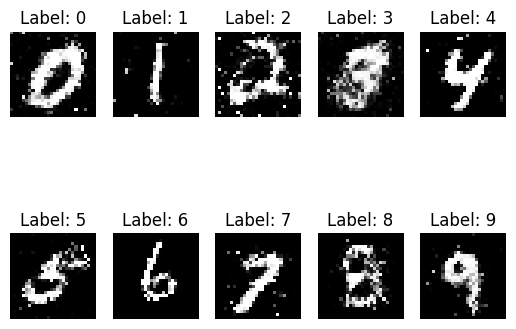

1/1 [==============================] - 0s 40ms/step
18801 [Discriminator loss: 0.682436, acc.: 53.12%] [Generator loss: 0.820147]
1/1 [==============================] - 0s 31ms/step
18802 [Discriminator loss: 0.669862, acc.: 60.94%] [Generator loss: 0.773985]
1/1 [==============================] - 0s 41ms/step
18803 [Discriminator loss: 0.783020, acc.: 42.19%] [Generator loss: 0.830083]
1/1 [==============================] - 0s 43ms/step
18804 [Discriminator loss: 0.655944, acc.: 57.81%] [Generator loss: 0.791751]
1/1 [==============================] - 0s 26ms/step
18805 [Discriminator loss: 0.704236, acc.: 46.88%] [Generator loss: 0.916077]
1/1 [==============================] - 0s 50ms/step
18806 [Discriminator loss: 0.653479, acc.: 64.06%] [Generator loss: 0.868745]
1/1 [==============================] - 0s 25ms/step
18807 [Discriminator loss: 0.720795, acc.: 51.56%] [Generator loss: 0.880508]
1/1 [==============================] - 0s 40ms/step
18808 [Discriminator loss: 0.656081, a

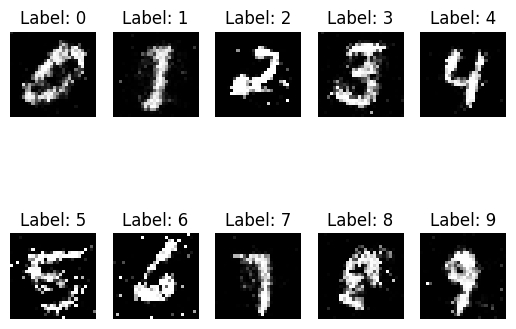

1/1 [==============================] - 0s 30ms/step
18901 [Discriminator loss: 0.644714, acc.: 57.81%] [Generator loss: 0.829896]
1/1 [==============================] - 0s 35ms/step
18902 [Discriminator loss: 0.687056, acc.: 57.81%] [Generator loss: 0.824396]
1/1 [==============================] - 0s 34ms/step
18903 [Discriminator loss: 0.619031, acc.: 62.50%] [Generator loss: 0.808971]
1/1 [==============================] - 0s 49ms/step
18904 [Discriminator loss: 0.628762, acc.: 67.19%] [Generator loss: 0.963309]
1/1 [==============================] - 0s 29ms/step
18905 [Discriminator loss: 0.605460, acc.: 60.94%] [Generator loss: 0.880851]
1/1 [==============================] - 0s 64ms/step
18906 [Discriminator loss: 0.632932, acc.: 51.56%] [Generator loss: 0.877884]
1/1 [==============================] - 0s 44ms/step
18907 [Discriminator loss: 0.681198, acc.: 57.81%] [Generator loss: 0.820379]
1/1 [==============================] - 0s 38ms/step
18908 [Discriminator loss: 0.606261, a

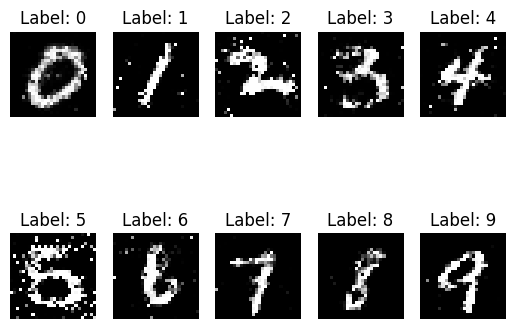

1/1 [==============================] - 0s 29ms/step
19001 [Discriminator loss: 0.639378, acc.: 46.88%] [Generator loss: 0.830388]
1/1 [==============================] - 0s 37ms/step
19002 [Discriminator loss: 0.657162, acc.: 64.06%] [Generator loss: 0.839979]
1/1 [==============================] - 0s 50ms/step
19003 [Discriminator loss: 0.656219, acc.: 62.50%] [Generator loss: 0.835916]
1/1 [==============================] - 0s 53ms/step
19004 [Discriminator loss: 0.685804, acc.: 59.38%] [Generator loss: 0.778430]
1/1 [==============================] - 0s 38ms/step
19005 [Discriminator loss: 0.605289, acc.: 68.75%] [Generator loss: 0.801037]
1/1 [==============================] - 0s 33ms/step
19006 [Discriminator loss: 0.667185, acc.: 65.62%] [Generator loss: 0.834478]
1/1 [==============================] - 0s 51ms/step
19007 [Discriminator loss: 0.626978, acc.: 60.94%] [Generator loss: 0.720161]
1/1 [==============================] - 0s 35ms/step
19008 [Discriminator loss: 0.647345, a

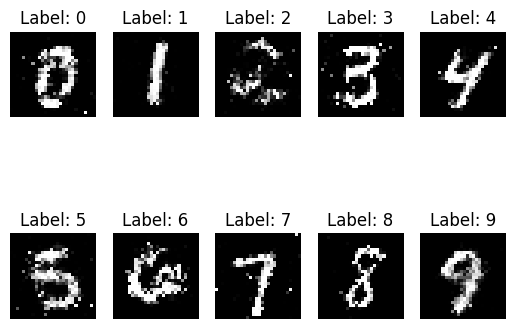

1/1 [==============================] - 0s 56ms/step
19101 [Discriminator loss: 0.709507, acc.: 46.88%] [Generator loss: 0.800992]
1/1 [==============================] - 0s 29ms/step
19102 [Discriminator loss: 0.662292, acc.: 54.69%] [Generator loss: 0.814023]
1/1 [==============================] - 0s 26ms/step
19103 [Discriminator loss: 0.678249, acc.: 56.25%] [Generator loss: 0.802206]
1/1 [==============================] - 0s 37ms/step
19104 [Discriminator loss: 0.684016, acc.: 62.50%] [Generator loss: 0.772797]
1/1 [==============================] - 0s 34ms/step
19105 [Discriminator loss: 0.662714, acc.: 62.50%] [Generator loss: 0.770977]
1/1 [==============================] - 0s 31ms/step
19106 [Discriminator loss: 0.598866, acc.: 64.06%] [Generator loss: 0.770705]
1/1 [==============================] - 0s 27ms/step
19107 [Discriminator loss: 0.615189, acc.: 60.94%] [Generator loss: 0.747013]
1/1 [==============================] - 0s 40ms/step
19108 [Discriminator loss: 0.658125, a

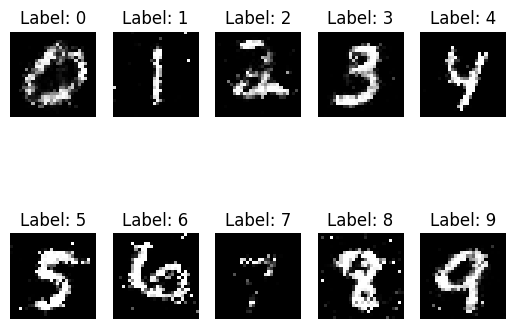

1/1 [==============================] - 0s 32ms/step
19201 [Discriminator loss: 0.689902, acc.: 54.69%] [Generator loss: 0.795267]
1/1 [==============================] - 0s 24ms/step
19202 [Discriminator loss: 0.659048, acc.: 57.81%] [Generator loss: 0.847546]
1/1 [==============================] - 0s 52ms/step
19203 [Discriminator loss: 0.664621, acc.: 59.38%] [Generator loss: 0.904290]
1/1 [==============================] - 0s 30ms/step
19204 [Discriminator loss: 0.664881, acc.: 53.12%] [Generator loss: 0.865306]
1/1 [==============================] - 0s 43ms/step
19205 [Discriminator loss: 0.702063, acc.: 54.69%] [Generator loss: 0.792760]
1/1 [==============================] - 0s 36ms/step
19206 [Discriminator loss: 0.685973, acc.: 53.12%] [Generator loss: 0.784222]
1/1 [==============================] - 0s 40ms/step
19207 [Discriminator loss: 0.643778, acc.: 75.00%] [Generator loss: 0.837451]
1/1 [==============================] - 0s 22ms/step
19208 [Discriminator loss: 0.647588, a

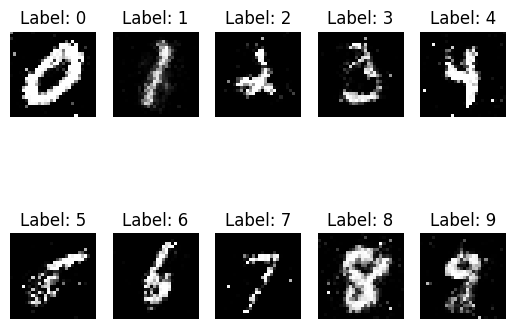

1/1 [==============================] - 0s 29ms/step
19301 [Discriminator loss: 0.594492, acc.: 65.62%] [Generator loss: 0.877353]
1/1 [==============================] - 0s 29ms/step
19302 [Discriminator loss: 0.666661, acc.: 56.25%] [Generator loss: 0.785685]
1/1 [==============================] - 0s 40ms/step
19303 [Discriminator loss: 0.619450, acc.: 70.31%] [Generator loss: 0.758120]
1/1 [==============================] - 0s 27ms/step
19304 [Discriminator loss: 0.710653, acc.: 56.25%] [Generator loss: 0.779957]
1/1 [==============================] - 0s 28ms/step
19305 [Discriminator loss: 0.629177, acc.: 62.50%] [Generator loss: 0.786491]
1/1 [==============================] - 0s 32ms/step
19306 [Discriminator loss: 0.671083, acc.: 51.56%] [Generator loss: 0.811936]
1/1 [==============================] - 0s 30ms/step
19307 [Discriminator loss: 0.568387, acc.: 71.88%] [Generator loss: 0.886244]
1/1 [==============================] - 0s 29ms/step
19308 [Discriminator loss: 0.670900, a

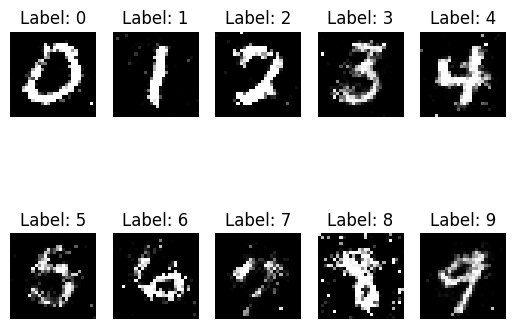

1/1 [==============================] - 0s 24ms/step
19401 [Discriminator loss: 0.680619, acc.: 56.25%] [Generator loss: 0.781813]
1/1 [==============================] - 0s 22ms/step
19402 [Discriminator loss: 0.649294, acc.: 57.81%] [Generator loss: 0.744149]
1/1 [==============================] - 0s 24ms/step
19403 [Discriminator loss: 0.646936, acc.: 65.62%] [Generator loss: 0.832416]
1/1 [==============================] - 0s 25ms/step
19404 [Discriminator loss: 0.622160, acc.: 59.38%] [Generator loss: 0.836576]
1/1 [==============================] - 0s 26ms/step
19405 [Discriminator loss: 0.673997, acc.: 60.94%] [Generator loss: 0.799517]
1/1 [==============================] - 0s 32ms/step
19406 [Discriminator loss: 0.680120, acc.: 56.25%] [Generator loss: 0.761054]
1/1 [==============================] - 0s 26ms/step
19407 [Discriminator loss: 0.682043, acc.: 57.81%] [Generator loss: 0.771823]
1/1 [==============================] - 0s 37ms/step
19408 [Discriminator loss: 0.619852, a

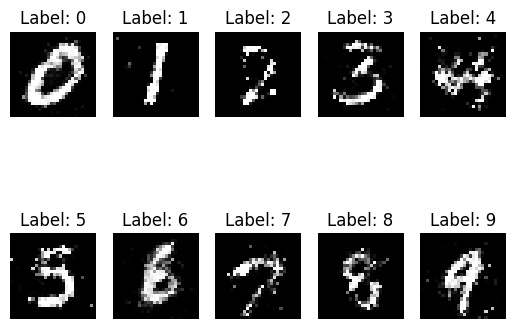

1/1 [==============================] - 0s 25ms/step
19501 [Discriminator loss: 0.587997, acc.: 71.88%] [Generator loss: 0.871854]
1/1 [==============================] - 0s 25ms/step
19502 [Discriminator loss: 0.660352, acc.: 57.81%] [Generator loss: 0.852605]
1/1 [==============================] - 0s 23ms/step
19503 [Discriminator loss: 0.635800, acc.: 62.50%] [Generator loss: 0.912828]
1/1 [==============================] - 0s 31ms/step
19504 [Discriminator loss: 0.670070, acc.: 50.00%] [Generator loss: 0.819284]
1/1 [==============================] - 0s 23ms/step
19505 [Discriminator loss: 0.632608, acc.: 59.38%] [Generator loss: 0.883061]
1/1 [==============================] - 0s 32ms/step
19506 [Discriminator loss: 0.614391, acc.: 60.94%] [Generator loss: 0.817117]
1/1 [==============================] - 0s 25ms/step
19507 [Discriminator loss: 0.665723, acc.: 57.81%] [Generator loss: 0.815072]
1/1 [==============================] - 0s 23ms/step
19508 [Discriminator loss: 0.672859, a

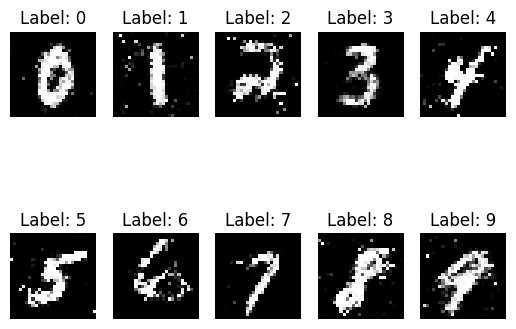

1/1 [==============================] - 0s 25ms/step
19601 [Discriminator loss: 0.657438, acc.: 54.69%] [Generator loss: 0.856248]
1/1 [==============================] - 0s 23ms/step
19602 [Discriminator loss: 0.690490, acc.: 57.81%] [Generator loss: 0.767662]
1/1 [==============================] - 0s 22ms/step
19603 [Discriminator loss: 0.617946, acc.: 68.75%] [Generator loss: 0.743527]
1/1 [==============================] - 0s 22ms/step
19604 [Discriminator loss: 0.740660, acc.: 51.56%] [Generator loss: 0.653444]
1/1 [==============================] - 0s 23ms/step
19605 [Discriminator loss: 0.663095, acc.: 60.94%] [Generator loss: 0.812217]
1/1 [==============================] - 0s 22ms/step
19606 [Discriminator loss: 0.655160, acc.: 62.50%] [Generator loss: 0.833568]
1/1 [==============================] - 0s 31ms/step
19607 [Discriminator loss: 0.664792, acc.: 64.06%] [Generator loss: 0.798613]
1/1 [==============================] - 0s 24ms/step
19608 [Discriminator loss: 0.662291, a

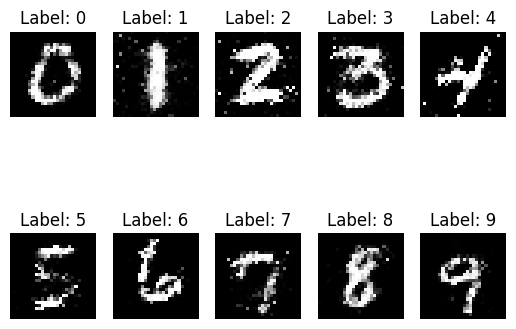

1/1 [==============================] - 0s 28ms/step
19701 [Discriminator loss: 0.648269, acc.: 57.81%] [Generator loss: 0.864841]
1/1 [==============================] - 0s 25ms/step
19702 [Discriminator loss: 0.711609, acc.: 51.56%] [Generator loss: 0.886905]
1/1 [==============================] - 0s 27ms/step
19703 [Discriminator loss: 0.663064, acc.: 59.38%] [Generator loss: 0.831274]
1/1 [==============================] - 0s 25ms/step
19704 [Discriminator loss: 0.681166, acc.: 53.12%] [Generator loss: 0.810611]
1/1 [==============================] - 0s 34ms/step
19705 [Discriminator loss: 0.664370, acc.: 54.69%] [Generator loss: 0.820104]
1/1 [==============================] - 0s 28ms/step
19706 [Discriminator loss: 0.653991, acc.: 57.81%] [Generator loss: 0.830797]
1/1 [==============================] - 0s 28ms/step
19707 [Discriminator loss: 0.663162, acc.: 62.50%] [Generator loss: 0.895759]
1/1 [==============================] - 0s 26ms/step
19708 [Discriminator loss: 0.596386, a

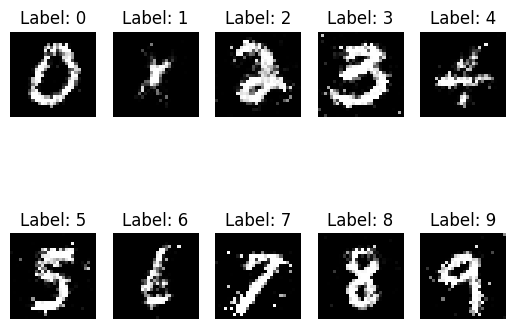

1/1 [==============================] - 0s 24ms/step
19801 [Discriminator loss: 0.678685, acc.: 60.94%] [Generator loss: 0.766779]
1/1 [==============================] - 0s 26ms/step
19802 [Discriminator loss: 0.691302, acc.: 54.69%] [Generator loss: 0.854017]
1/1 [==============================] - 0s 24ms/step
19803 [Discriminator loss: 0.721388, acc.: 53.12%] [Generator loss: 0.835085]
1/1 [==============================] - 0s 25ms/step
19804 [Discriminator loss: 0.681194, acc.: 53.12%] [Generator loss: 0.803232]
1/1 [==============================] - 0s 22ms/step
19805 [Discriminator loss: 0.698288, acc.: 53.12%] [Generator loss: 0.832470]
1/1 [==============================] - 0s 23ms/step
19806 [Discriminator loss: 0.626664, acc.: 64.06%] [Generator loss: 0.748115]
1/1 [==============================] - 0s 23ms/step
19807 [Discriminator loss: 0.668321, acc.: 50.00%] [Generator loss: 0.837953]
1/1 [==============================] - 0s 27ms/step
19808 [Discriminator loss: 0.645755, a

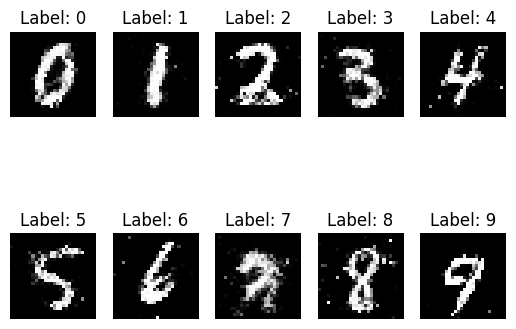

1/1 [==============================] - 0s 27ms/step
19901 [Discriminator loss: 0.703827, acc.: 46.88%] [Generator loss: 0.758882]
1/1 [==============================] - 0s 24ms/step
19902 [Discriminator loss: 0.624174, acc.: 67.19%] [Generator loss: 0.783422]
1/1 [==============================] - 0s 24ms/step
19903 [Discriminator loss: 0.652375, acc.: 59.38%] [Generator loss: 0.763516]
1/1 [==============================] - 0s 23ms/step
19904 [Discriminator loss: 0.679379, acc.: 54.69%] [Generator loss: 0.778953]
1/1 [==============================] - 0s 27ms/step
19905 [Discriminator loss: 0.629105, acc.: 60.94%] [Generator loss: 0.802839]
1/1 [==============================] - 0s 24ms/step
19906 [Discriminator loss: 0.634243, acc.: 62.50%] [Generator loss: 0.829488]
1/1 [==============================] - 0s 23ms/step
19907 [Discriminator loss: 0.658706, acc.: 57.81%] [Generator loss: 0.805568]
1/1 [==============================] - 0s 23ms/step
19908 [Discriminator loss: 0.646763, a

In [ ]:
train(generator,discriminator,gan_model,epochs=20000, batch_size=32, sample_interval=100)

## Output
Samples generated after 2500 epochs
<img src="outputs/c_gan_output.png">

In [ ]:
# Save the generator model in the native Keras format
generator.save('conditional_model.keras')

In [ ]:
from tensorflow.keras.models import load_model

# Load your generator model
generator_model = load_model('conditional_model.keras')

# Compile the loaded model with the appropriate settings
generator_model.compile(optimizer='adam', loss='your_loss_function', metrics=['accuracy'])


In [ ]:
generator_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 100)               1000      ['input_4[0][0]']             
                                                                                                  
 input_3 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 flatten_2 (Flatten)         (None, 100)                  0         ['embedding_1[0][0]']         
                                                                                            